In [155]:
##You will need to install of the following packages

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybedtools import BedTool
from scipy.stats import ttest_ind
import scipy.stats as sts
from scipy.special import betainc
import scipy
from statsmodels.stats.multitest import fdrcorrection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tqdm.auto import tqdm
from mpl_toolkits.mplot3d import Axes3D
from umap import UMAP
from scipy.stats import zscore
from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.stats import wilcoxon
from matplotlib_venn import venn2, venn2_circles
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

pd.set_option('display.max_rows', 100)

In [158]:
# Print versions
print(f"os version: {os.name}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {plt.matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"statsmodels version: {fdrcorrection.__module__.split('.')[0]}: {pd.__version__}")
print(f"scikit-learn version: {StandardScaler.__module__.split('.')[0]}: {np.__version__}")
print(f"umap-learn version: {UMAP.__module__.split('.')[0]}: {pd.__version__}")
print(f"matplotlib-venn version: {venn2.__module__.split('.')[0]}: {np.__version__}")

#These are the specific versions of the packages used in the original notebook:
#os version: posix
#pandas version: 1.5.3
#numpy version: 1.25.2
#matplotlib version: 3.9.2
#seaborn version: 0.13.2
#scipy version: 1.14.1
#statsmodels version: statsmodels: 1.5.3
#scikit-learn version: sklearn: 1.25.2
#umap-learn version: umap: 1.5.3
#matplotlib-venn version: matplotlib_venn: 1.25.2


os version: posix
pandas version: 1.5.3
numpy version: 1.25.2
matplotlib version: 3.9.2
seaborn version: 0.13.2
scipy version: 1.14.1
statsmodels version: statsmodels: 1.5.3
scikit-learn version: sklearn: 1.25.2
umap-learn version: umap: 1.5.3
matplotlib-venn version: matplotlib_venn: 1.25.2


In [2]:
# THIS SERIES OF COMMANDS WILL GENERATE THE ONCOPROTEIN SCORES #

def pval_after_fold_change_filter(df, log_fold_change_cutoff=2, pval_cutoff=.01):
    idx = df['log2_ratio_mean'] > log_fold_change_cutoff
    df['p_values_adjusted_after_filter'] = np.nan
    df['null_rejected_after_filter'] = False
    null_rejected, pvals = fdrcorrection(df.loc[idx, 'log2_ratio_pvalue'], alpha=pval_cutoff)
    df.loc[idx, 'null_rejected_after_filter'] = null_rejected
    df.loc[idx, 'p_values_adjusted_after_filter'] = pvals
    df['enriched'] = df['null_rejected'] & idx
    return df
    
def get_N_over_C_zscores(df, samples=1_000, seed=789947, cname='', log_fold_change_cutoff=2, pval_cutoff=.01):
    # 3rd approach: sampling
    # problem: We have to take and compare many samples to gain accuracy
    # which takes time to complete.
    
    Cterm_counts = df['Cterm_counts'].values
    Nterm_counts = df['Nterm_counts'].values
    
    np.random.seed(seed)
    
    print('samplin N')
    sampsn = np.random.dirichlet(Nterm_counts+1, samples)
    print('samplin C')
    sampsc = np.random.dirichlet(Cterm_counts+1, samples)
    print('log2 ratios')
    log2_ratios = np.log2(sampsn) - np.log2(sampsc)
    means = log2_ratios.mean(axis=0)
    stds = log2_ratios.std(axis=0, ddof=2)
    del log2_ratios
    zscores = means / stds
    
    df['log2_ratio_mean'] = means
    df['log2_ratio_std'] = stds
    df['log2_ratio_zscore'] = zscores
    df['log2_ratio_pvalue'] = scipy.stats.norm().cdf(-zscores)
    df['null_rejected'], df['p_values_adjusted'] = fdrcorrection(df['log2_ratio_pvalue'], alpha=pval_cutoff)
    df = pval_after_fold_change_filter(df, log_fold_change_cutoff=log_fold_change_cutoff, pval_cutoff=pval_cutoff)
    #I added this line to calculate a weighted magnitude:
    epsilon = 1e-10
    df['Weighted_Magnitude'] = df['log2_ratio_mean'] * -np.log10(df['log2_ratio_pvalue'] + epsilon)
    
    
    df.index = df['chrom'] + ':' + df['start'].astype(str) + '-' + df['stop'].astype(str)
    n_significant = np.sum(df['enriched'])
    print(f'Found {n_significant:,} peaks with significant enrichment for {cname}.')

    return df
    
def Count_N_C (bed, bed2, peakfile, samples=1_000, seed=789947, cname='', log_fold_change_cutoff=2, pval_cutoff=.01):
    Sample_bed = BedTool(bed)
    Sample_bed_2 = BedTool(bed2)
    Sample_peaks = BedTool(peakfile)
    
#Get sample Read Coutns:
    Sample =  pd.read_csv(Sample_bed.fn, sep='\t')
    Sample_reads = Sample.shape[0]
    Sample_2 = pd.read_csv(Sample_bed_2.fn, sep='\t')
    Sample_2_reads = Sample_2.shape[0]


#Calculate Counts for bed files
    
    Sample_overlap_int_sum = Sample_peaks.intersect(Sample_bed, wao=True) 
    Sample_overlap_int_sum =  pd.read_csv(Sample_overlap_int_sum.fn, sep='\t')
    Sample_overlap_int_sum.columns = ['chrom','start', 'stop', 'chrom2', 'start2', 'stop2', 'overlap']
    Sample_overlap_int_sum['counts'] = (Sample_overlap_int_sum['overlap'] > 0).astype(int)
    Sample_overlap_int_sum = Sample_overlap_int_sum.groupby(['chrom','start','stop']).agg({'counts': ['sum']}).reset_index()
    Sample_overlap_int_sum.columns = ['chrom','start','stop', 'Cterm_counts']
    Sample_overlap_int_sum = BedTool.from_dataframe(Sample_overlap_int_sum) 
    Sample_overlap_int_sum = Sample_overlap_int_sum.intersect(Sample_bed_2, wao=True)
    Sample_overlap_int_sum = pd.read_csv(Sample_overlap_int_sum.fn, sep='\t')
    Sample_overlap_int_sum.columns = ['chrom','start','stop', 'Cterm_counts', 'chrom2', 'start2', 'stop2', 'overlap']
    Sample_overlap_int_sum['counts'] = (Sample_overlap_int_sum['overlap'] > 0).astype(int)
    Sample_overlap_int_sum = Sample_overlap_int_sum.groupby(['chrom','start','stop', 'Cterm_counts']).agg({'counts': ['sum']}).reset_index()
    Sample_overlap_int_sum.columns = ['chrom','start','stop', 'Cterm_counts', 'Nterm_counts']
    
    Sample_overlap_int_sum['Cterm_norm'] = 1e6*Sample_overlap_int_sum['Cterm_counts']/Sample_overlap_int_sum['Cterm_counts'].sum()
    Sample_overlap_int_sum['Nterm_norm'] = 1e6*Sample_overlap_int_sum['Nterm_counts']/Sample_overlap_int_sum['Nterm_counts'].sum()
 
    output_df = get_N_over_C_zscores(
        Sample_overlap_int_sum,
        samples=samples,
        seed=seed,
        cname=cname,
        log_fold_change_cutoff=log_fold_change_cutoff,
        pval_cutoff=pval_cutoff,
    )
    return output_df

In [102]:
# Code for Figure 1C left panel
# The curated peak file MLLr_MasterPeaks_AllData_Revision_noIgG.bed is available on Github 
# The MLL/KMT2A N and C terminal CUT&RUN data must be downloaded from GEO under the accession codes GSE252378 and GSE159608
# The MLL/KMT2A N and C terminal CUT&RUN data can be combined using the Combine_MLL_BedFiles.sh and GenerateBedGraphsBigWigs.sh bash scripts
# Or skip this processing and load the premade MLL_OncoPeaks_WM_stat.csv and MLL_OncoPeaks_WM_average_ratio.txt available on GitHub

Sample_bed = ['../../for_melodie/KMT2Ar_CnR_201218_V2/DJ_Hs_MLL_Cterm_CD34_1208.bed']
bed2 = '../../for_melodie/KMT2Ar_CnR_201218_V2/DJ_Hs_MLL_Nterm_CD34_1208.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    CD34_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

samplin N
samplin C
log2 ratios
Found 3 peaks with significant enrichment for .


In [104]:
#CD34_NC_Score.to_csv('CD34_NC_Score.csv', index=True)
CD34_NC_Score = pd.read_csv("CD34_NC_Score.csv", sep=',', index_col=0)

In [103]:
# Code for Figure 1C right panel
# The curated peak file MLLr_MasterPeaks_AllData_Revision_noIgG.bed is available on Github 
# The MLL/KMT2A N and C terminal CUT&RUN data must be downloaded from GEO under the accession codes GSE252378 and GSE159608
# The MLL/KMT2A N and C terminal CUT&RUN data can be combined using the Combine_MLL_BedFiles.sh and GenerateBedGraphsBigWigs.sh bash scripts
# Or skip this processing and load the premade MLL_OncoPeaks_WM_stat.csv and MLL_OncoPeaks_WM_average_ratio.txt available on GitHub

Sample_bed = ['../../for_melodie/KMT2Ar_CnR_200331_V2/DJ_Hs_SEM_KMT2A_Cterm_200331.bed']
bed2 = '../../for_melodie/KMT2Ar_CnR_200331_V2/DJ_Hs_SEM_KMT2A_Nterm_200331.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    SEM_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

samplin N
samplin C
log2 ratios
Found 156 peaks with significant enrichment for .


In [105]:
#SEM_NC_Score.to_csv('SEM_NC_Score.csv', index=True)
SEM_NC_Score = pd.read_csv("SEM_NC_Score.csv", sep=',', index_col=0)

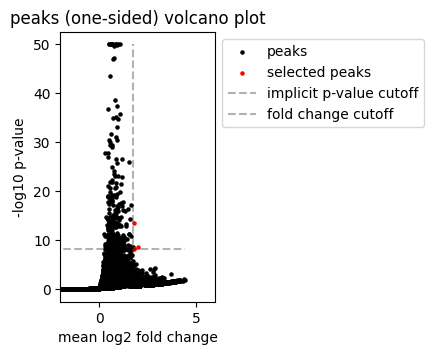

In [106]:
#Code for Figure 1C left panel

df = CD34_NC_Score
plt.figure(figsize=(2, 3.5))
log_fold_change_cutoff=1.75
idx = df['enriched']
l10pval = np.clip(-np.log10(df['log2_ratio_pvalue']), 0, 50)
implicit_pval_cutoff = l10pval[idx].min()
plt.scatter(df.loc[~idx, 'log2_ratio_mean'], l10pval[~idx], label='peaks', s=5, color='black')
plt.scatter(df.loc[idx, 'log2_ratio_mean'], l10pval[idx], label='selected peaks', s=5, color='r')
lb, ub = df['log2_ratio_mean'].min(), df['log2_ratio_mean'].max()
plt.hlines(implicit_pval_cutoff, lb, ub, color='black', alpha=.3, linestyles='dashed', label='implicit p-value cutoff')
plt.vlines(log_fold_change_cutoff, 0, l10pval.max(), color='black', alpha=.3, linestyles='dashed', label='fold change cutoff')
plt.xlim(-2, 6)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('mean log2 fold change')
plt.ylabel('-log10 p-value')
plt.title('peaks (one-sided) volcano plot')
#plt.savefig('Figure_Panels/Fig_1C_left.png', dpi=300, bbox_inches='tight') 
plt.show()

/home/derek.janssens/jupyter_bbc2_python3_python-3.11.3_/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


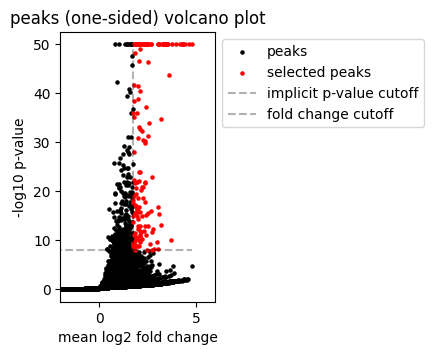

In [107]:
#Code for Figure 1C right panel

df = SEM_NC_Score
plt.figure(figsize=(2, 3.5))
log_fold_change_cutoff=1.75
idx = df['enriched']
l10pval = np.clip(-np.log10(df['log2_ratio_pvalue']), 0, 50)
implicit_pval_cutoff = l10pval[idx].min()
plt.scatter(df.loc[~idx, 'log2_ratio_mean'], l10pval[~idx], label='peaks', s=5, color='black')
plt.scatter(df.loc[idx, 'log2_ratio_mean'], l10pval[idx], label='selected peaks', s=5, color='r')
lb, ub = df['log2_ratio_mean'].min(), df['log2_ratio_mean'].max()
plt.hlines(implicit_pval_cutoff, lb, ub, color='black', alpha=.3, linestyles='dashed', label='implicit p-value cutoff')
plt.vlines(log_fold_change_cutoff, 0, l10pval.max(), color='black', alpha=.3, linestyles='dashed', label='fold change cutoff')
plt.xlim(-2, 6)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('mean log2 fold change')
plt.ylabel('-log10 p-value')
plt.title('peaks (one-sided) volcano plot')
#plt.savefig('Figure_Panels/Fig_1C_right.png', dpi=300, bbox_inches='tight') 
plt.show()

In [325]:
# THIS CELL SPECIFIES THE INPUT LIST FOR THE ONCOPROTEIN SCORE CALCULATOR #
# The curated peak file KMT2Ar_MasterPeaks_AllData_Revision_noIgG.bed is available on Github 
# The MLL/KMT2A N and C terminal CUT&RUN data must be downloaded from GEO under the accession codes GSE252378 and GSE159608
# The MLL/KMT2A N and C terminal CUT&RUN data can be combined using the Combine_MLL_BedFiles.sh and GenerateBedGraphsBigWigs.sh bash scripts
# Or skip this processing and load the premade MLL_OncoPeaks_WM_stat.csv and MLL_OncoPeaks_WM_average_ratio.txt available on GitHub

peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'
bed_files = {
    'p160':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p160_KMT2A_Cterm_230613.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p160_KMT2A_Nterm_230613.bed',
    ),
    'p179':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p179_KMT2A_Cterm_230613.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p179_KMT2A_Nterm_230613.bed',
    ),
    'p186':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p186_KMT2A_Cterm_230613.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p186_KMT2A_Nterm_230613.bed',
    ),
    'p214':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p214_KMT2A_Cterm_230613.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p214_KMT2A_Nterm_230613.bed',
    ),
    'p247':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p247_KMT2A_Cterm_230613.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p247_KMT2A_Nterm_230613.bed',
    ),
    'p279':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p279_KMT2A_Cterm_230613.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p279_KMT2A_Nterm_230613.bed',
    ),
    'p318':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p318_KMT2A_Cterm_230613.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p318_KMT2A_Nterm_230613.bed',
    ),
    'p454':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p454_KMT2A_Cterm_230613.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_p454_KMT2A_Nterm_230613.bed',
    ),
 
    'KOPN8':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_KOPN8_KMT2A_Cterm_200331.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_KOPN8_KMT2A_Nterm_200331.bed',
    ),
    
    'SEM':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_SEM_KMT2A_Cterm_200331.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_SEM_KMT2A_Nterm_200331.bed',
    ),
    
     'RS411':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_RS411_KMT2A_Cterm_200331.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_RS411_KMT2A_Nterm_200331.bed',
    ),
    
    'ML2':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_ML2_KMT2A_Cterm_200331.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_ML2_KMT2A_Nterm_200331.bed',
    ),
    
     'A40725':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A4_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A4_KMT2A_Nterm_200504.bed',
    ),
    
    'A58548':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A5_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A5_KMT2A_Nterm_200504.bed',
    ),
    
    'A67194':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A6_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A6_KMT2A_Nterm_200504.bed',
    ),
    
    'TB11':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB11_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB11_KMT2A_Nterm_200504.bed',
    ),
    
     'TB13':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB13_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB13_KMT2A_Nterm_200504.bed',
    ),
    
     'CD34':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_MLL_Cterm_CD34_1208.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_MLL_Nterm_CD34_1208.bed',
    ),
    
    'A109':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_MLL_Cterm_A109C_1208.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_MLL_Nterm_A109C_1208.bed',
    ),
    
     'A384':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_MLL_Cterm_A384C_1208.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_MLL_Nterm_A384C_1208.bed',
    ),
    
    'A107':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_MLL_Cterm_A107C_1208.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_MLL_Nterm_A107C_1208.bed',
    ),
    
    'TB000694':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB000694_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB000694_KMT2A_Nterm_200504.bed',
    ),
    
    'A93949':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A93949_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A93949_KMT2A_Nterm_200504.bed',
    ),
    
    'TB051939':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB051939_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB051939_KMT2A_Nterm_200504.bed',
    ),
    
    'TB920488':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB920488_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB920488_KMT2A_Nterm_200504.bed',
    ),
    
     'TB971992':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB971992_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB971992_KMT2A_Nterm_200504.bed',
    ),
    
     'A95941':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A95941_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A95941_KMT2A_Nterm_200504.bed',
    ),
    
    'TB040576':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB040576_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB040576_KMT2A_Nterm_200504.bed',
    ),
    
    'TB995291':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB995291_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB995291_KMT2A_Nterm_200504.bed',
    ),
    
    'TB986292':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB986292_KMT2A_Cterm_200504.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_TB986292_KMT2A_Nterm_200504.bed',
    ),
    
     'A70498':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A70498_KMT2A_Cterm_221101.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A70498_KMT2A_Nterm_221101.bed',
    ),
    
    'A93692':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A93692_KMT2A_Cterm_221101.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A93692_KMT2A_Nterm_221101.bed',
    ),
    
    'A89691':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A89691_KMT2A_Cterm_221101.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A89691_KMT2A_Nterm_221101.bed',
    ),
    
     'A82485':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A82485_KMT2A_Cterm_221101.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A82485_KMT2A_Nterm_221101.bed',
    ),
    
     'A73051':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A73051_KMT2A_Cterm_221101.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A73051_KMT2A_Nterm_221101.bed',
    ),
    
    'A80956':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A80956_KMT2A_Cterm_221101.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_A80956_KMT2A_Nterm_221101.bed',

    ),
    '5395':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_5395_KMT2A_Cterm_05T_040324.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_5395_KMT2A_Nterm_05T_040324.bed',
    ),
    '5652':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_5652_KMT2A_Cterm_05T_040324.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_5652_KMT2A_Nterm_05T_040324.bed',
    ),
    '148752':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_148752_500K_KMT2A_Cterm_240416.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_148752_500K_KMT2A_Nterm_240416.bed',
    ),
    '152985':(
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_152985_500K_KMT2A_Cterm_240416.bed',
        'Path/to/Combined/CUTnRUN/Files/DJ_Hs_152985_500K_KMT2A_Nterm_240416.bed',
    ),
}

In [3]:
#These lists match the sample order above, and will be used for labeling and coloring plots

Sample_Order = ['p160','p179','p186','p214','p247','p279','p318','p454','KOPN8','SEM','RS411','ML2','A40725','A58548','A67194','TB11','TB13','CD34',
                'A109','A384','A107','TB000694','A93949','TB051939','TB920488','TB971992','A95941','TB040576','TB995291','TB986292',
                'A70498','A93692','A89691','A82485','A73051','A80956','5395','5652','148752','152985']

MLL_Fusion = ['MLL-ENL','MLL-AF4','MLL-ENL','MLL-ENL','MLL-AF4','MLL-AF4','MLL-AF4', 'MLL-AF4','MLL-ENL','MLL-AF4','MLL-AF4','MLL-AFDN',
              'MLL-SEPT6','MLL-AF4','MLL-ENL','MLL-AF9','MLL-AF4','wildtype','MLL-AF10','MLL-AF10','MLL-AF9','MLL-AF10','MLL-AF9','MLL-AF4',
              'MLL-AF4','MLL-ENL','MLL-AF9','MLL-AF9','MLL-ENL','MLL-AF4','MLL-AFDN','MLL-AF10','MLL-AFDN','MLL-AFDN','MLL-AF10','MLL-AFDN',
              'MLL-EPS15','MLL-EPS15','MLL-ENL','MLL-ENL']

Switching_Numbers = ['','','','','','1','1','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','3','3',
                     '2','2']

Lineage_Subtype = ['Infant ALL','Infant ALL','Infant ALL','ALL','ALL','Infant ALL Relapse as AML','Infant AML Relapse from ALL','Infant ALL',
                   'Infant ALL','ALL','ALL','AML','AML','MPAL','AML','MPAL','ALL','CD34','AML','AML','AML','Infant ALL','AML','Infant ALL',
                   'Infant ALL','Infant ALL','AML','Infant ALL','Infant ALL','Infant ALL','AML','AML','AML','AML','AML','AML',
                   'Infant ALL Relapse as AML','Infant ALL Relapse as AML','Infant ALL Relapse as AML','Infant AML Relapse from ALL']


In [331]:
#This returns the Weighted_Magnitude

score_dfs = {
    cname:Count_N_C(bed[0], bed[1], peakfile, cname=cname, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)
    for cname, bed in tqdm(bed_files.items())
}
OncoPeaks_Weighted_Magnitude = pd.concat(
    [pd.DataFrame({cname:df['Weighted_Magnitude']}) for cname, df in score_dfs.items()],
    axis=1,
)
OncoPeaks_Weighted_Magnitude

  0%|          | 0/40 [00:00<?, ?it/s]

samplin N
samplin C
log2 ratios


  2%|▎         | 1/40 [00:39<25:42, 39.54s/it]

Found 126 peaks with significant enrichment for p160.
samplin N
samplin C
log2 ratios


  5%|▌         | 2/40 [01:22<26:16, 41.49s/it]

Found 289 peaks with significant enrichment for p179.
samplin N
samplin C
log2 ratios


  8%|▊         | 3/40 [02:03<25:31, 41.40s/it]

Found 176 peaks with significant enrichment for p186.
samplin N
samplin C
log2 ratios


 10%|█         | 4/40 [02:43<24:31, 40.87s/it]

Found 80 peaks with significant enrichment for p214.
samplin N
samplin C
log2 ratios


 12%|█▎        | 5/40 [03:29<24:52, 42.64s/it]

Found 346 peaks with significant enrichment for p247.
samplin N
samplin C
log2 ratios


 15%|█▌        | 6/40 [04:14<24:41, 43.58s/it]

Found 196 peaks with significant enrichment for p279.
samplin N
samplin C
log2 ratios


 18%|█▊        | 7/40 [04:57<23:51, 43.37s/it]

Found 233 peaks with significant enrichment for p318.
samplin N
samplin C
log2 ratios


 20%|██        | 8/40 [05:41<23:06, 43.34s/it]

Found 312 peaks with significant enrichment for p454.
samplin N
samplin C
log2 ratios


 22%|██▎       | 9/40 [06:24<22:23, 43.35s/it]

Found 147 peaks with significant enrichment for KOPN8.
samplin N
samplin C
log2 ratios


 25%|██▌       | 10/40 [07:08<21:41, 43.40s/it]

Found 156 peaks with significant enrichment for SEM.
samplin N
samplin C
log2 ratios


 28%|██▊       | 11/40 [07:53<21:14, 43.94s/it]

Found 189 peaks with significant enrichment for RS411.
samplin N
samplin C
log2 ratios


 30%|███       | 12/40 [08:26<19:03, 40.85s/it]

Found 6 peaks with significant enrichment for ML2.
samplin N
samplin C
log2 ratios


 32%|███▎      | 13/40 [09:11<18:49, 41.84s/it]

Found 7 peaks with significant enrichment for A4.
samplin N
samplin C
log2 ratios


 35%|███▌      | 14/40 [09:49<17:37, 40.66s/it]

Found 41 peaks with significant enrichment for A5.
samplin N
samplin C
log2 ratios


 38%|███▊      | 15/40 [10:33<17:22, 41.70s/it]

Found 1 peaks with significant enrichment for A6.
samplin N
samplin C
log2 ratios


 40%|████      | 16/40 [11:16<16:49, 42.06s/it]

Found 16 peaks with significant enrichment for TB11.
samplin N
samplin C
log2 ratios


 42%|████▎     | 17/40 [11:55<15:50, 41.30s/it]

Found 9 peaks with significant enrichment for TB13.
samplin N
samplin C
log2 ratios


 45%|████▌     | 18/40 [12:56<17:16, 47.12s/it]

Found 3 peaks with significant enrichment for CD34.
samplin N
samplin C
log2 ratios


 48%|████▊     | 19/40 [14:02<18:28, 52.76s/it]

Found 145 peaks with significant enrichment for A109.
samplin N
samplin C
log2 ratios


 50%|█████     | 20/40 [15:13<19:24, 58.24s/it]

Found 62 peaks with significant enrichment for A384.
samplin N
samplin C
log2 ratios


 52%|█████▎    | 21/40 [16:01<17:29, 55.21s/it]

Found 5 peaks with significant enrichment for A107.
samplin N
samplin C
log2 ratios


 55%|█████▌    | 22/40 [16:36<14:43, 49.09s/it]

Found 3 peaks with significant enrichment for TB000694.
samplin N
samplin C
log2 ratios


 57%|█████▊    | 23/40 [17:23<13:45, 48.54s/it]

Found 34 peaks with significant enrichment for A93949.
samplin N
samplin C
log2 ratios


 60%|██████    | 24/40 [18:01<12:06, 45.41s/it]

Found 77 peaks with significant enrichment for TB051939.
samplin N
samplin C
log2 ratios


 62%|██████▎   | 25/40 [18:47<11:25, 45.72s/it]

Found 7 peaks with significant enrichment for TB920488.
samplin N
samplin C
log2 ratios


 65%|██████▌   | 26/40 [19:30<10:27, 44.81s/it]

Found 220 peaks with significant enrichment for TB971992.
samplin N
samplin C
log2 ratios


 68%|██████▊   | 27/40 [20:16<09:48, 45.23s/it]

Found 136 peaks with significant enrichment for A95941.
samplin N
samplin C
log2 ratios


 70%|███████   | 28/40 [20:57<08:44, 43.72s/it]

Found 110 peaks with significant enrichment for TB040576.
samplin N
samplin C
log2 ratios


 72%|███████▎  | 29/40 [21:32<07:32, 41.18s/it]

Found 84 peaks with significant enrichment for TB995291.
samplin N
samplin C
log2 ratios


 75%|███████▌  | 30/40 [22:07<06:33, 39.39s/it]

Found 93 peaks with significant enrichment for TB986292.
samplin N
samplin C
log2 ratios


 78%|███████▊  | 31/40 [23:05<06:43, 44.85s/it]

Found 15 peaks with significant enrichment for A70498.
samplin N
samplin C
log2 ratios


 80%|████████  | 32/40 [23:52<06:03, 45.49s/it]

Found 210 peaks with significant enrichment for A93692.
samplin N
samplin C
log2 ratios


 82%|████████▎ | 33/40 [24:47<05:38, 48.32s/it]

Found 134 peaks with significant enrichment for A89691.
samplin N
samplin C
log2 ratios


 85%|████████▌ | 34/40 [25:31<04:43, 47.25s/it]

Found 116 peaks with significant enrichment for A82485.
samplin N
samplin C
log2 ratios


 88%|████████▊ | 35/40 [26:25<04:05, 49.10s/it]

Found 0 peaks with significant enrichment for A73051.
samplin N
samplin C
log2 ratios


 90%|█████████ | 36/40 [27:11<03:12, 48.19s/it]

Found 56 peaks with significant enrichment for A80956.
samplin N
samplin C
log2 ratios


 92%|█████████▎| 37/40 [28:05<02:29, 49.90s/it]

Found 25 peaks with significant enrichment for 5395.
samplin N
samplin C
log2 ratios


 95%|█████████▌| 38/40 [28:56<01:40, 50.27s/it]

Found 70 peaks with significant enrichment for 5652.
samplin N
samplin C
log2 ratios


 98%|█████████▊| 39/40 [30:52<01:10, 70.03s/it]

Found 46 peaks with significant enrichment for 148752.
samplin N
samplin C
log2 ratios


100%|██████████| 40/40 [32:33<00:00, 48.85s/it]

Found 0 peaks with significant enrichment for 152985.


,p160,p179,p186,p214,p247,p279,p318,p454,KOPN8,SEM,...,A70498,A93692,A89691,A82485,A73051,A80956,5395,5652,148752,152985
chr1:21155-23454,-0.139956,-0.017685,NaN,0.168484,-0.008941,-0.012843,0.202544,0.236289,NaN,-0.085532,...,0.056328,NaN,0.338610,NaN,0.365480,NaN,-0.057240,-0.006123,-0.025786,0.155033
chr1:23747-26284,-0.096273,-0.008816,-0.040641,-0.028886,-0.050191,-0.129320,-0.065708,-0.078454,-0.058909,-0.086031,...,-0.033957,0.117567,-0.038859,-0.056282,-0.003311,-0.071072,-0.051401,-0.033743,-0.029439,0.018986
chr1:27133-31137,0.020423,-0.033845,0.284058,0.407206,-0.015267,-0.020435,0.048403,0.646924,-0.034555,-0.010347,...,0.008024,-0.002748,0.173174,0.037827,0.224221,-0.073480,0.284317,-0.014967,-0.005613,0.108663
chr1:31144-33892,-0.044973,-0.009160,-0.044087,-0.026373,0.060523,-0.071199,-0.023803,-0.051480,-0.027739,2.282502,...,0.066127,-0.025290,0.049717,-0.026299,-0.038235,0.016392,-0.032246,-0.005788,-0.008806,-0.015982
chr1:33992-35427,-0.099352,-0.024063,-0.096771,-0.023208,-0.099430,-0.076182,-0.017330,-0.130266,-0.019100,-0.067562,...,0.198536,-0.061558,-0.063065,-0.009935,0.078318,-0.088428,0.095597,-0.051051,0.061934,-0.032000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY_KI270740v1_random:12017-12684,-0.195325,-0.100959,-0.218536,-0.205836,-0.122433,-0.218389,-0.186161,-0.218803,0.313888,-0.100230,...,0.033627,-0.185498,0.290335,-0.034562,0.003477,2.331514,-0.054009,-0.095170,-0.066373,0.243359
chrY_KI270740v1_random:13178-14101,-0.201259,-0.212446,-0.229763,-0.199156,-0.137654,-0.225182,-0.191755,-0.226370,0.307569,-0.056789,...,0.926963,0.775659,2.827042,-0.181013,-0.086910,-0.076027,-0.029368,-0.067450,0.191459,0.044076
chrY_KI270740v1_random:17838-18958,-0.202201,-0.107543,0.171791,-0.206457,-0.214270,-0.230670,-0.186946,-0.228604,0.300275,-0.113696,...,0.082488,-0.005198,0.465508,-0.137123,0.002170,-0.067579,-0.048551,-0.076460,-0.051578,-0.044235
chrY_KI270740v1_random:23846-24940,-0.203714,-0.221592,0.177444,-0.140534,-0.202329,-0.211507,-0.190565,-0.218336,0.361099,-0.102447,...,-0.182362,0.747041,-0.186833,-0.014331,0.304579,-0.168558,-0.016961,-0.072795,-0.064839,-0.044660


In [332]:
OncoPeaks_select = pd.concat(
    [pd.DataFrame({cname:df['null_rejected_after_filter']}) for cname, df in score_dfs.items()],
    axis=1,
)
idx = OncoPeaks_select.any(axis=1)

n_selected = np.sum(idx)
n_total = len(idx)
frac_sel = n_selected / n_total
print(f'Using {n_selected:,} of {n_total:,} ({frac_sel:.2%}) peaks.')

OncoPeaks_WM_stat = pd.concat(
    [pd.DataFrame({cname:df.loc[idx, 'Weighted_Magnitude']}) for cname, df in score_dfs.items()],
    axis=1,
)
average_ratio = OncoPeaks_WM_stat.mean().values

Using 1,692 of 298,980 (0.57%) peaks.


In [372]:
average_ratio = OncoPeaks_WM_stat.mean().values

In [24]:
# This saves the two Oncoprotein Score tables for later use
#np.savetxt('MLL_OncoPeaks_WM_average_ratio.txt', average_ratio)
#OncoPeaks_WM_stat.to_csv('MLL_OncoPeaks_WM_stat.csv', index=True)


In [3]:
# This loads the two previsouly generate "Oncoprotein Score" tables available on GitHub. 
OncoPeaks_WM_stat = pd.read_csv("MLL_OncoPeaks_WM_stat.csv", sep=',', index_col=0)
average_ratio = np.loadtxt('MLL_OncoPeaks_WM_average_ratio.txt')
OncoPeaks_WM_stat.head(5)

,p160,p179,p186,p214,p247,p279,p318,p454,KOPN8,SEM,...,A70498,A93692,A89691,A82485,A73051,A80956,5395,5652,148752,152985
chr1:12337273-12347527,3.071647,15.932375,5.928155,0.042608,4.425297,16.455251,0.180630,26.509950,-0.037506,0.092909,...,-0.007166,0.032459,0.813539,0.507062,0.204590,-0.059694,0.040143,4.136764,0.012291,-0.010115
chr1:12375611-12382513,1.679312,2.152669,4.159570,0.896787,4.353450,8.519791,0.336633,5.670679,-0.079631,0.230149,...,-0.019851,-0.075876,0.281914,0.129686,1.333798,0.100427,0.502240,14.136590,0.250061,0.019034
chr1:12432973-12437401,8.419165,2.628350,0.052073,3.138738,0.243009,14.215742,-0.072371,14.403262,-0.028912,-0.007760,...,-0.033035,0.407495,0.217144,-0.056361,0.197066,-0.092790,0.428251,5.772661,0.799452,0.436413
chr1:12470612-12482527,6.270654,8.023291,0.695442,4.638810,4.090221,18.273777,1.458933,22.219636,-0.011948,1.069668,...,0.167282,0.113218,-0.026106,-0.021164,0.183109,-0.037602,1.240493,7.388615,0.229890,-0.017538
chr1:12612876-12621934,14.006232,14.487303,17.678986,6.336551,8.378889,13.954631,0.001029,19.431653,-0.055264,0.185288,...,-0.032630,-0.024104,0.378615,-0.059686,-0.026068,0.046478,12.405796,12.000247,0.937147,-0.015226


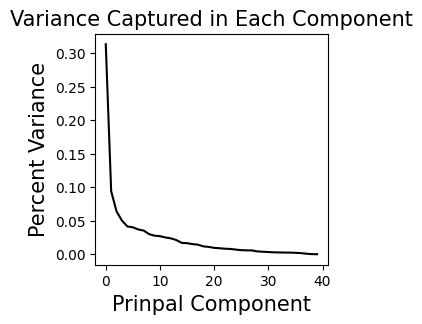

In [5]:
# Code for Supplementary Figure 1A

cutoff = 0
components = [1, 2]
colors = average_ratio
input_df = OncoPeaks_WM_stat.transpose()

pca = PCA(whiten=False)
x_pca = pca.fit_transform(input_df)

plt.figure(figsize=(3,3))
plt.plot(pca.explained_variance_ratio_, color = "black")

plt.tick_params(axis='both', which='major', labelsize='10')

plt.title('Variance Captured in Each Component', fontsize=15)

plt.xlabel('Prinpal Component', fontsize=15)
plt.ylabel('Percent Variance', fontsize=15)

#plt.savefig('Figure_Panels/Supplementary_Fig_1A.png', dpi=300, bbox_inches='tight')

plt.show()


In [11]:
input_df = OncoPeaks_WM_stat.transpose()

# Running PCA
pca = PCA(n_components=4)  # You can adjust this based on your needs
pca_result = pca.fit_transform(input_df)  # Exclude the third variable

# Running UMAP on PCA results
umap_model = UMAP(n_neighbors=5, min_dist=0.45, n_components=2)  # You can adjust parameters based on your needs
umap_result = umap_model.fit_transform(pca_result)

# Convert UMAP result to DataFrame
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])
umap_df['MLL_Fusion'] = MLL_Fusion
umap_df['Lineage_Subtype'] = Lineage_Subtype
umap_df['Sample_Order'] = Sample_Order
umap_df['avg_magnitude'] = average_ratio


/tmp/ipykernel_19131/1788047415.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(1, 11), wcss, 'bo-', color="black")  # 'bo-' indicates blue circle markers with a solid line


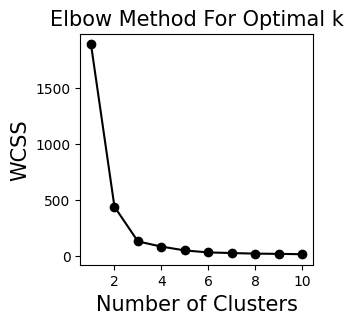

In [12]:
# Code for Supplementary Figure 1B
wcss = []
for i in range(1, 11):  # Modify this range if you want to test a different number of clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(umap_df[['UMAP1', 'UMAP2']])
    wcss.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

# Create a figure with a specified size
plt.figure(figsize=(3, 3))

# Plot WCSS for each number of clusters
plt.plot(range(1, 11), wcss, 'bo-', color="black")  # 'bo-' indicates blue circle markers with a solid line

# Style the plot to match the previous output format for PCA variance
plt.tick_params(axis='both', which='major', labelsize=10)

# Title and labels with consistent style
plt.title('Elbow Method For Optimal k', fontsize=15)
plt.xlabel('Number of Clusters', fontsize=15)
plt.ylabel('WCSS', fontsize=15)

# Save the figure in the specified path with DPI=300
#plt.savefig('Figure_Panels/Supplementary_Fig_1B.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [13]:
# Create a KMeans instance with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
# Fit the model and predict clusters
umap_df['Cluster'] = kmeans.fit_predict(umap_df[['UMAP1', 'UMAP2']])

# Convert the 'Cluster' column to string
umap_df['Cluster'] = umap_df['Cluster'].astype(str)

In [148]:
umap_df['MLL_Fusion'] = MLL_Fusion

In [149]:
umap_df.head(5)

,UMAP1,UMAP2,MLL_Fusion,Lineage_Subtype,Sample_Order,avg_magnitude,Cluster
0,2.626965,3.825049,MLL-ENL,Infant ALL,p160,5.054322,1
1,-2.903770,5.797665,MLL-AF4,Infant ALL,p179,7.987329,2
2,2.321848,4.147960,MLL-ENL,Infant ALL,p186,5.778651,1
3,2.013849,5.362910,MLL-ENL,ALL,p214,3.463927,1
4,-3.041629,5.358982,MLL-AF4,ALL,p247,7.932832,2


In [150]:
#This saves the UMAP Dataframe
#umap_df.to_csv('MLL_Oncoprotein_Levels_UMAP.csv', index=False)

In [6]:
umap_df = pd.read_csv("MLL_Oncoprotein_Levels_UMAP.csv", sep=',')
umap_df.head(5)

,UMAP1,UMAP2,MLL_Fusion,Lineage_Subtype,Sample_Order,avg_magnitude,Cluster
0,2.626965,3.825049,MLL-ENL,Infant ALL,p160,5.054322,1
1,-2.903770,5.797665,MLL-AF4,Infant ALL,p179,7.987329,2
2,2.321848,4.147960,MLL-ENL,Infant ALL,p186,5.778651,1
3,2.013849,5.362910,MLL-ENL,ALL,p214,3.463927,1
4,-3.041629,5.358982,MLL-AF4,ALL,p247,7.932832,2


/tmp/ipykernel_9876/2584912064.py:10: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue='Lineage_Subtype', hue_order = hue_order, s=120, palette=colorblind_2) #, palette=colorblind_2 # Increased dot size


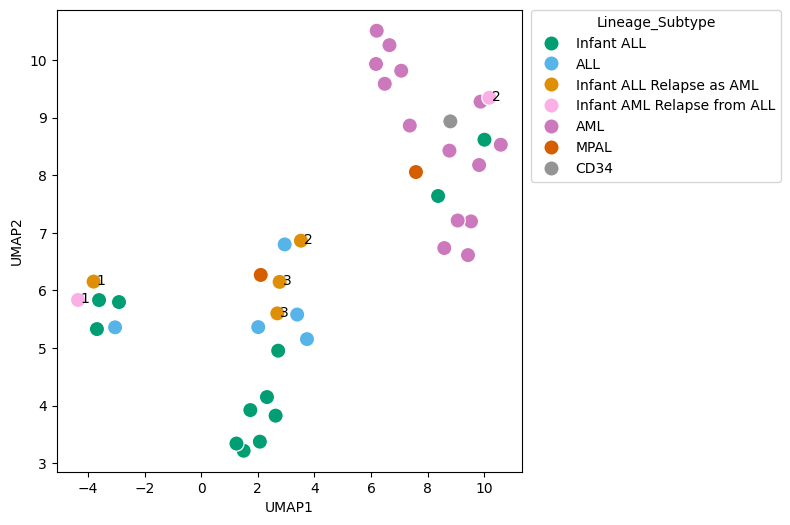

In [151]:
#Code to make Figure 1D

all_colors = sns.color_palette("colorblind")

colorblind_2 = [all_colors[2]] + [all_colors[9]] + [all_colors[1]] + [all_colors[6]] + [all_colors[4]] + [all_colors[3]] + [all_colors[7]] + [all_colors[7]]
hue_order = ['Infant ALL', 'ALL', 'Infant ALL Relapse as AML', 'Infant AML Relapse from ALL', 'AML', 'MPAL', 'CD34']
4
# Visualization using UMAP results for Lineage_Subtype
plt.figure(figsize=(6, 6))  # Square plot
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue='Lineage_Subtype', hue_order = hue_order, s=120, palette=colorblind_2) #, palette=colorblind_2 # Increased dot size
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Lineage_Subtype')
for i in range(umap_df.shape[0]):
    plt.text(x=umap_df.UMAP1[i]+0.1,y=umap_df.UMAP2[i]-0.05,s=Switching_Numbers[i]) #umap_df.index[i]
#plt.savefig("Figure_Panels/Fig_1D.png", dpi=300, bbox_inches='tight')  # Save the plot
plt.show()

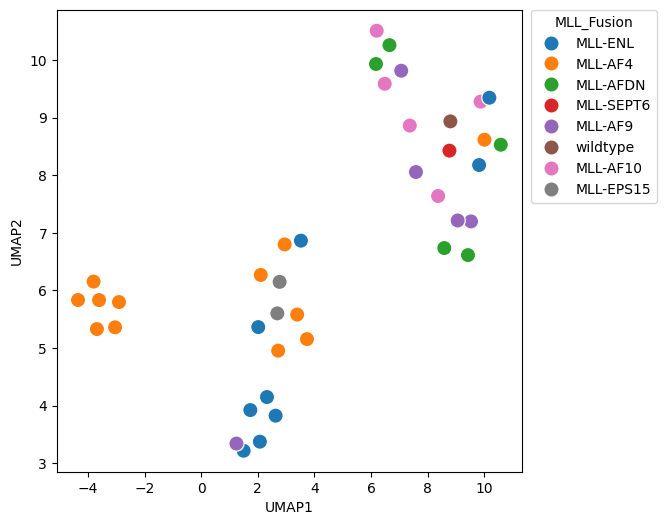

In [152]:
#Code to make Figure 1E

sns.reset_defaults()

hue_order = ['MLL-ENL', 'MLL-AF4', 'MLL-AFDN', 'MLL-SEPT6', 'MLL-AF9', 'wildtype', 'MLL-AF10', 'MLL-EPS15']

# Visualization using UMAP results for KMT2A_Fusion
plt.figure(figsize=(6, 6))  # Square plot
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue='MLL_Fusion', hue_order=hue_order, s=120)  # Increased dot size
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='MLL_Fusion')
#plt.savefig("Figure_Panels/Fig_1E.png", dpi=300, bbox_inches='tight')  # Save the plot
plt.show()


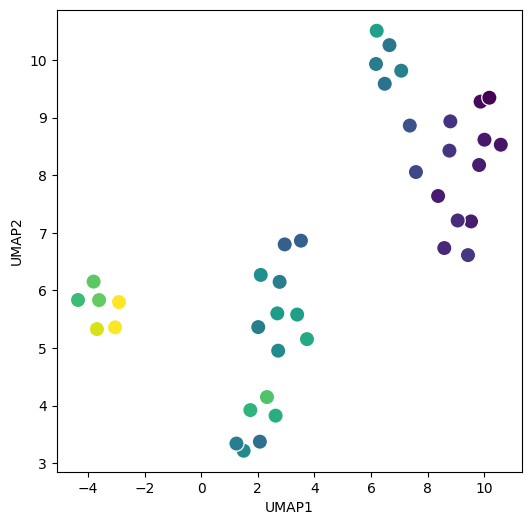

In [153]:
#Code to make Figure 1F

# Visualization using UMAP results and 'color' as a continuous variable
plt.figure(figsize=(6, 6))  # Square plot
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue=colors, s=120, palette="viridis")  # 'color' should be the column name with continuous values
#cbar = plt.colorbar()  # Get the colorbar to customize
#cbar.set_label('Magnitude')  # Label the colorbar
plt.legend().set_visible(False)  # Hide discrete legend since we have a colorbar
#plt.savefig(f"Figure_Panels/Fig_1F.png", dpi=300, bbox_inches='tight')  # Save the plot
plt.show()


T-test 0 vs 1: t-statistic = -1.537, p-value = 1.407e-01
T-test 0 vs 2: t-statistic = -6.399, p-value = 7.840e-05
T-test 0 vs 3: t-statistic = 8.295, p-value = 2.223e-07
T-test 1 vs 2: t-statistic = -5.741, p-value = 1.562e-05
T-test 1 vs 3: t-statistic = 10.280, p-value = 1.189e-10
T-test 2 vs 3: t-statistic = 16.771, p-value = 5.204e-12

Bonferroni corrected p-values:
0 vs 1: corrected p-value = 8.441e-01 (reject null hypothesis: False)
0 vs 2: corrected p-value = 4.704e-04 (reject null hypothesis: True)
0 vs 3: corrected p-value = 1.334e-06 (reject null hypothesis: True)
1 vs 2: corrected p-value = 9.370e-05 (reject null hypothesis: True)
1 vs 3: corrected p-value = 7.133e-10 (reject null hypothesis: True)
2 vs 3: corrected p-value = 3.122e-11 (reject null hypothesis: True)


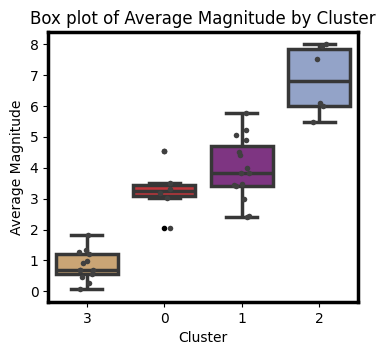

In [39]:
#Code for Figure 1G

# Define the color palette for clusters
color_palette = {
    "0": "#D51F26", "1": "#89288F", "2": "#8A9FD1", "3": "#D8A767",
}

# Ensure 'Cluster' is of type string for the color palette to work
umap_df['Cluster'] = umap_df['Cluster'].astype(str)

# Specify order for the x-axis categories
sorted_order = ["3", "0", "1", "2"]  # Ensure this matches your desired order

# Define properties for outliers in boxplot (black dots)
flierprops = dict(marker='o', markerfacecolor='black', markeredgecolor='black', markersize=3)

# Create the boxplot with a thicker outline and assign 'hue' to avoid the warning
plt.figure(figsize=(4, 3.5))
ax = sns.boxplot(data=umap_df, x='Cluster', y='avg_magnitude', hue='Cluster', palette=color_palette, 
                 order=sorted_order, linewidth=2.5, flierprops=flierprops, legend=False)

# Add the stripplot
sns.stripplot(data=umap_df, x="Cluster", y="avg_magnitude", color="0.25", size=4, jitter=True, order=sorted_order)

# Define the cluster pairs for comparison
cluster_pairs = [("0", "1"), ("0", "2"), ("0", "3"), ("1", "2"), ("1", "3"), ("2", "3")]

# Store p-values for Bonferroni correction
p_values = []

# Perform t-tests for each pair and store the p-values
for pair in cluster_pairs:
    cluster1 = umap_df[umap_df['Cluster'] == pair[0]]['avg_magnitude']
    cluster2 = umap_df[umap_df['Cluster'] == pair[1]]['avg_magnitude']
    t_stat, p_value = ttest_ind(cluster1, cluster2)
    p_values.append(p_value)
    print(f"T-test {pair[0]} vs {pair[1]}: t-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")

# Apply Bonferroni correction to the p-values
reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')

# Print the corrected p-values with Bonferroni correction
print("\nBonferroni corrected p-values:")
for i, pair in enumerate(cluster_pairs):
    print(f"{pair[0]} vs {pair[1]}: corrected p-value = {pvals_corrected[i]:.3e} (reject null hypothesis: {reject[i]})")
    
# Increase the linewidth of the plot borders (for axes and box lines)
for _, spine in ax.spines.items():
    spine.set_linewidth(2.5)

# Set plot title and labels
plt.title('Box plot of Average Magnitude by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Magnitude')

# Save the plot if needed
#plt.savefig('Figure_Panels/Fig_1G.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


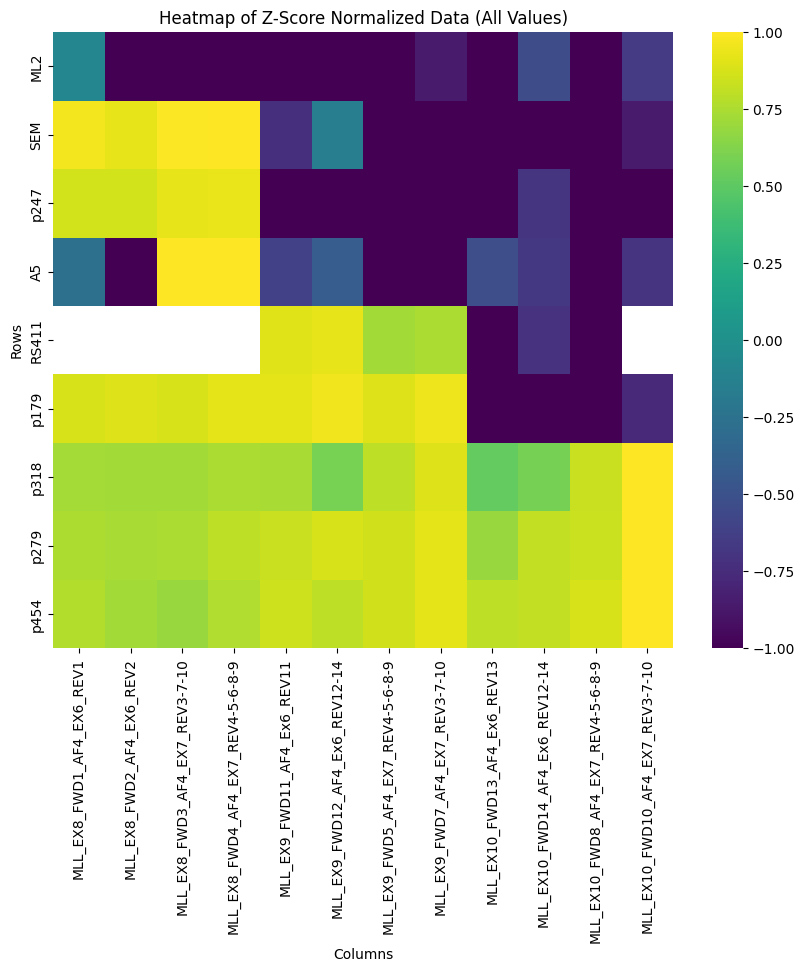

In [14]:
# Code Supplementary Figure 1C

MLL_AF4_Fusion_Junction_QPCR = pd.read_csv("MLL-AF4_Fusion_Exon_Junction_Mapping.csv", sep=',', index_col=0)

df = MLL_AF4_Fusion_Junction_QPCR
                                
df = df.transpose()

# Replace 'Undetermined' with 40 and 'Blank' with NaN
df = df.replace({'Undetermined': 40, 'Blank': np.nan})

# Convert all values in the dataframe to numbers
df = df.apply(pd.to_numeric, errors='coerce')

# Flatten the dataframe, calculate z-scores, and reshape it back
df_flattened = df.values.flatten()
df_zscored = zscore(df_flattened, nan_policy='omit')
df_normalized = pd.DataFrame(df_zscored.reshape(df.shape), index=df.index, columns=df.columns)

# Define the desired column order as a list
desired_order = ['ML2', 'SEM', 'p247', 'A5', 'RS411', 'p179', 'p318', 'p279', 'p454']  # Replace with your actual column names

# Ensure all columns in the list are present in the dataframe
desired_order = [col for col in desired_order if col in df_normalized.columns]

# Reorder the columns based on the specified list
df_normalized = df_normalized[desired_order]

# Transpose the dataframe
df_normalized = df_normalized.transpose()

# Multiply all values in df_normalized by -1
df_normalized = df_normalized * -1

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_normalized, cmap='viridis', annot=False, cbar=True, vmin=-1, vmax=1)  # Set annot to False to remove number overlays
plt.title('Heatmap of Z-Score Normalized Data (All Values)')
plt.xlabel('Columns')
plt.ylabel('Rows')
#plt.savefig('Figure_Panels/Supplementary_Fig_1C.png')
plt.show()


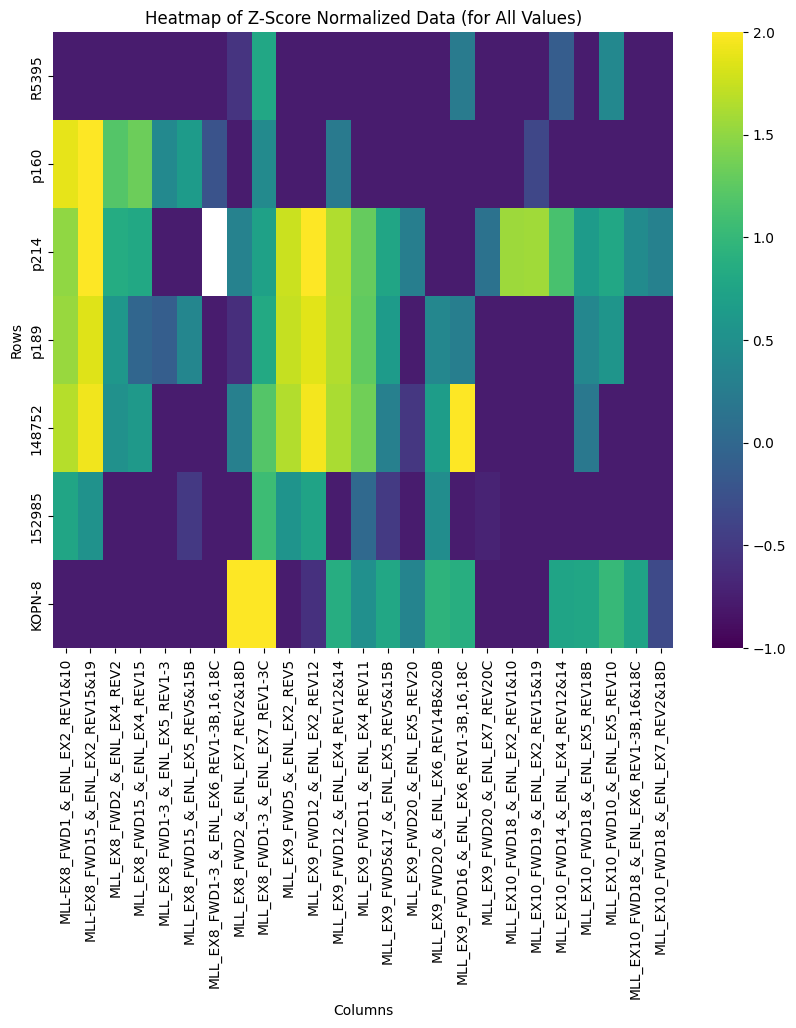

In [19]:
MLL_ENL_Fusion_Junction_QPCR = pd.read_csv("MLL-ENL_Fusion_Exon_Junction_Mapping.csv", sep=',', index_col=0)

# Assuming the dataframe is already loaded into KMT2A_AFDN_Fusion_Junction_QPCR
df = MLL_ENL_Fusion_Junction_QPCR
                                
df = df.transpose()

# Replace 'Undetermined' with 40 and 'Blank' with NaN
df = df.replace({'Undetermined': 40, 'Blank': np.nan})

# Convert all values in the dataframe to numbers
df = df.apply(pd.to_numeric, errors='coerce')

# Flatten the dataframe, calculate z-scores, and reshape it back
df_flattened = df.values.flatten()
df_zscored = zscore(df_flattened, nan_policy='omit')
df_normalized = pd.DataFrame(df_zscored.reshape(df.shape), index=df.index, columns=df.columns)

# Define the desired column order as a list
desired_order = ['R5395', 'p160', 'p214',  'p189', '148752', '152985','KOPN-8']  # Replace with your actual column names

# Ensure all columns in the list are present in the dataframe
desired_order = [col for col in desired_order if col in df_normalized.columns]

# Reorder the columns based on the specified list
df_normalized = df_normalized[desired_order]

# Transpose the dataframe
df_normalized = df_normalized.transpose()

# Multiply all values in df_normalized by -1
df_normalized = df_normalized * -1

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_normalized, cmap='viridis', annot=False, cbar=True, vmin=-1, vmax=2)  # Set annot to False to remove number overlays
plt.title('Heatmap of Z-Score Normalized Data (for All Values)')
plt.xlabel('Columns')
plt.ylabel('Rows')
#plt.savefig('Figure_Panels/Supplementary_Fig_1D.png')
plt.show()


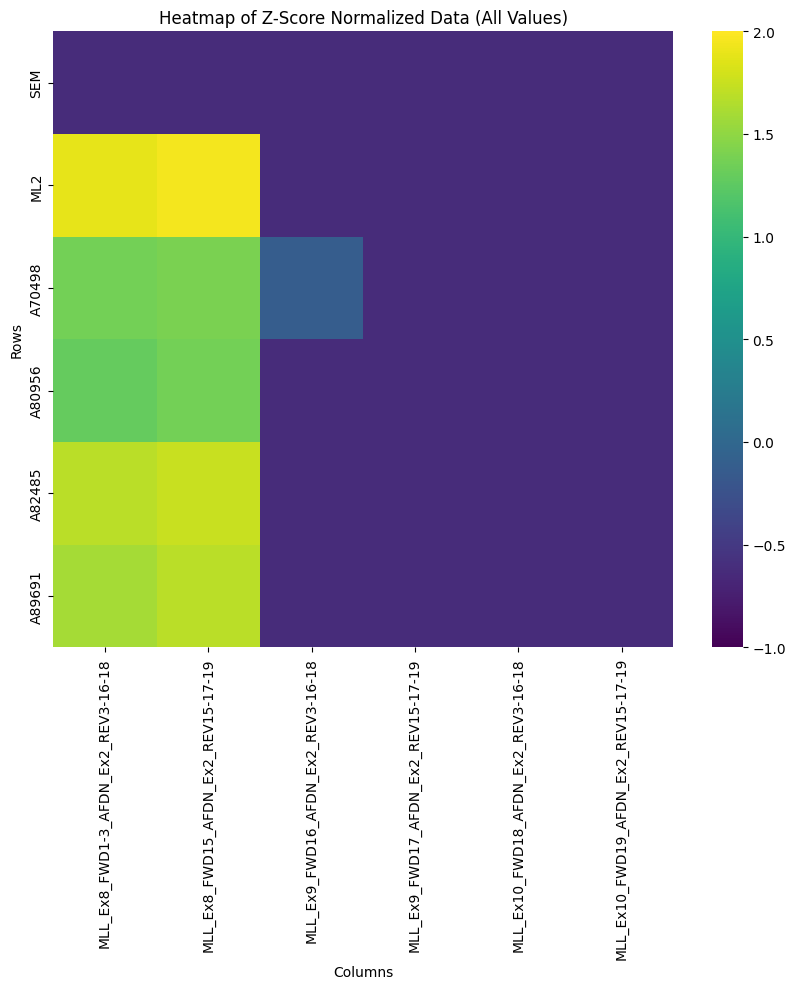

In [17]:
MLL_AFDN_Fusion_Junction_QPCR = pd.read_csv("MLL-AFDN_Fusion_Exon_Junction_Mapping.csv", sep=',', index_col=0)

# Assuming the dataframe is already loaded into KMT2A_AFDN_Fusion_Junction_QPCR
df = MLL_AFDN_Fusion_Junction_QPCR
                                
df = df.transpose()

# Replace 'Undetermined' with 40 and 'Blank' with NaN
df = df.replace({'Undetermined': 40, 'Blank': np.nan})

# Convert all values in the dataframe to numbers
df = df.apply(pd.to_numeric, errors='coerce')

# Flatten the dataframe, calculate z-scores, and reshape it back
df_flattened = df.values.flatten()
df_zscored = zscore(df_flattened, nan_policy='omit')
df_normalized = pd.DataFrame(df_zscored.reshape(df.shape), index=df.index, columns=df.columns)

# Define the desired column order as a list
desired_order = ['SEM', 'ML2', 'A70498', 'A80956', 'A82485', 'A89691'] 

# Ensure all columns in the list are present in the dataframe
desired_order = [col for col in desired_order if col in df_normalized.columns]

# Reorder the columns based on the specified list
df_normalized = df_normalized[desired_order]

# Transpose the dataframe
df_normalized = df_normalized.transpose()

# Multiply all values in df_normalized by -1
df_normalized = df_normalized * -1

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_normalized, cmap='viridis', annot=False, cbar=True, vmin=-1, vmax=2)  # Set annot to False to remove number overlays
plt.title('Heatmap of Z-Score Normalized Data (All Values)')
plt.xlabel('Columns')
plt.ylabel('Rows')
#plt.savefig('Figure_Panels/Supplementary_Fig_1E.png')
plt.show()

In [38]:
# This script will print the oncoprotien scores for all peaks overlapping with a gene of interest 
# These values were used as the gene specific oncoprotein scores for each sample. 

gene_name = "ZNF521"

# Gene name can be replaced by "HOXA9","JMJD1C","MEIS1", etc. 

# Step 1: Load and prepare the gene list
ArchR_hg38_Gene_List = pd.read_csv('rowDataGSM_hg38.csv', sep=',')
ArchR_hg38_Gene_List = ArchR_hg38_Gene_List.iloc[:, [1, 2, 3, 4, 5]]
ArchR_hg38_Gene_List.columns = ['chrom', 'start', 'stop', 'strand', 'gene']

# Handle strand logic for genes and concatenate
ArchR_hg38_Gene_List_1 = ArchR_hg38_Gene_List[ArchR_hg38_Gene_List['strand'] == 1]
ArchR_hg38_Gene_List_2 = ArchR_hg38_Gene_List[ArchR_hg38_Gene_List['strand'] == 2]
ArchR_hg38_Gene_List_2 = ArchR_hg38_Gene_List_2.iloc[:, [0, 2, 1, 3, 4]]
ArchR_hg38_Gene_List_2.columns = ['chrom', 'start', 'stop', 'strand', 'gene']

# Combine and filter genes within a 2.5M distance
hg38_Gene_List = pd.concat([ArchR_hg38_Gene_List_1, ArchR_hg38_Gene_List_2])
hg38_Gene_List = hg38_Gene_List.sort_values(['chrom', 'start'], ascending=[True, True])
hg38_Gene_List['Real'] = [1 if (x - y) < 2500000 else 0 for x, y in zip(hg38_Gene_List['stop'], hg38_Gene_List['start'])]
hg38_Gene_List_1 = hg38_Gene_List[hg38_Gene_List['Real'] == 1]

# Filter for the specific gene
gene_row = hg38_Gene_List_1[hg38_Gene_List_1['gene'] == gene_name]
if gene_row.empty:
    raise ValueError(f"No matching gene found for {gene_name}")

# Convert the gene row to a BED format
gene_bed = BedTool.from_dataframe(gene_row[['chrom', 'start', 'stop']])

# Step 2: Prepare the peak data from OncoPeaks_WM_stat
df = OncoPeaks_WM_stat

# Split the index into 'chrom', 'start', and 'stop'
chrom_start_stop = df.index.to_series().str.split(':', expand=True)
chrom_start_stop[['start', 'stop']] = chrom_start_stop[1].str.split('-', expand=True)

# Convert 'start' and 'stop' to numeric, to avoid any NaN issues
chrom_start_stop['start'] = pd.to_numeric(chrom_start_stop['start'], errors='coerce')
chrom_start_stop['stop'] = pd.to_numeric(chrom_start_stop['stop'], errors='coerce')

# Now assign the newly split values into the original DataFrame
df['chrom'] = chrom_start_stop[0].values  # 'chrom' is in the first split
df['start'] = chrom_start_stop['start'].values
df['stop'] = chrom_start_stop['stop'].values

# Drop any rows with NaN values in 'start' or 'stop' (to avoid potential issues)
df.dropna(subset=['start', 'stop'], inplace=True)

# Step 3: Convert df to BED format using only necessary columns ('chrom', 'start', 'stop')
oncopeaks_bed = BedTool.from_dataframe(df[['chrom', 'start', 'stop']])

# Step 4: Find intersections between the peaks and the gene bed
intersecting_bed = oncopeaks_bed.intersect(gene_bed, u=True, wa=True)
intersecting_df = intersecting_bed.to_dataframe()

# Ensure the output has at least 'chrom', 'start', and 'stop' columns
if len(intersecting_df.columns) < 3:
    raise ValueError("Unexpected intersection output: 'chrom', 'start', and 'stop' columns are missing.")

# Step 5: Restore the extra columns from the original DataFrame
extra_cols = [col for col in df.columns if col not in ['chrom', 'start', 'stop']]
expected_column_names = ['chrom', 'start', 'stop'] + extra_cols

# Assign the intersecting BED data back to the original dataframe structure
intersecting_df.columns = ['chrom', 'start', 'stop']
intersecting_df = pd.merge(intersecting_df, df[expected_column_names], on=['chrom', 'start', 'stop'], how='left')

# Step 6: Create the 'chrom:start-stop' index
intersecting_df.index = intersecting_df['chrom'] + ':' + intersecting_df['start'].astype(str) + '-' + intersecting_df['stop'].astype(str)

# Drop the original 'chrom', 'start', and 'stop' columns as they are now part of the index
intersecting_df.drop(columns=['chrom', 'start', 'stop'], inplace=True)

# Step 7: Filter the final columns to keep only the relevant ones
columns_to_keep = ['A5', 'SEM', 'p247', 'RS411', 'p179', 'p318', 'p279', 'p454', 'A80956', 'A70498', 'A82485', 'A89691', 'ML2', '148752', '152985', 'p186', 'p160', 'p214', 'KOPN8', '5395', '5652']
intersecting_df = intersecting_df[columns_to_keep]

# Step 8: Save to CSV if needed, Output or display the results

# intersecting_df.to_csv('MBNL1_Oncoprotein_Scores.csv', index=False)

# Print the final intersecting DataFrame with the proper index
print(intersecting_df)


                               A5       SEM          p247         RS411  \
chr18:25098730-25108940 -0.009743 -0.068291 -1.340085e-02 -5.568955e-02   
chr18:25110745-25129237 -0.040316 -0.054431 -5.275352e-02 -4.556570e-02   
chr18:25139222-25158639  1.901114 -0.060563 -2.796410e-02 -2.136970e-02   
chr18:25158848-25362589  0.550915 -0.006800 -6.435260e-07 -9.244750e-07   

                             p179          p318      p279          p454  \
chr18:25098730-25108940  1.231891 -5.533138e-02  0.005929 -9.523478e-02   
chr18:25110745-25129237 -0.054339 -1.935519e-03 -0.016975  7.114878e-01   
chr18:25139222-25158639 -0.051111 -5.805968e-04  0.318201 -4.101444e-02   
chr18:25158848-25362589 -0.009558 -4.995168e-10 -0.018284 -2.511111e-08   

                            A80956     A70498  ...     A89691       ML2  \
chr18:25098730-25108940  -0.018909   0.649301  ...   0.491440  0.066098   
chr18:25110745-25129237   0.382692   0.254666  ...  -0.021936 -0.072139   
chr18:25139222-25158639

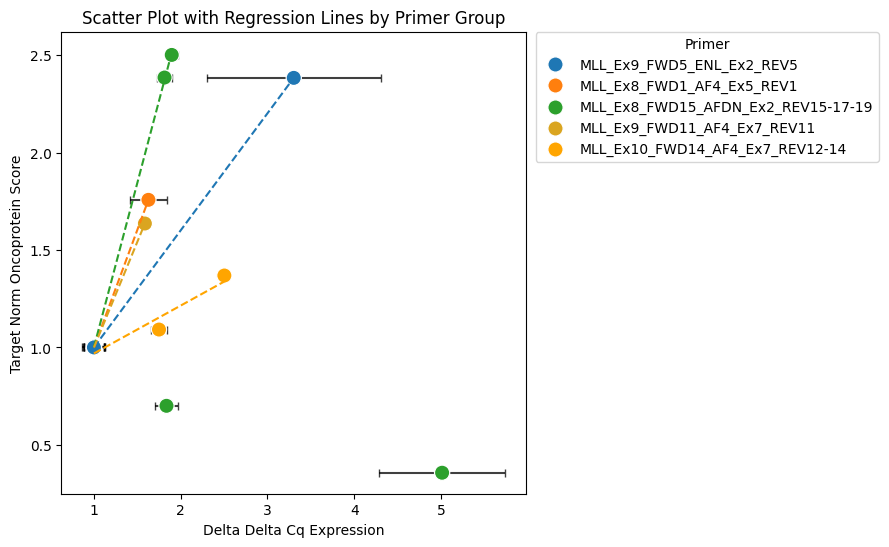

<Figure size 600x600 with 0 Axes>

In [65]:
Oncogene_Oncoprotein_QPCR = pd.read_csv("QPCR_Oncogene_Oncoprotein_Replicates.csv", sep=',', index_col=0)

df = Oncogene_Oncoprotein_QPCR.transpose()
df['Delta Delta Cq Expression'] = pd.to_numeric(df['Delta Delta Cq Expression'], errors='coerce')
df['Delta Delta Cq St. Deviation'] = pd.to_numeric(df['Delta Delta Cq St. Deviation'], errors='coerce')
df['Oncoprotein Score'] = pd.to_numeric(df['Oncoprotein Score'], errors='coerce')
df['Target Norm Oncoprotein Score'] = pd.to_numeric(df['Target Norm Oncoprotein Score'], errors='coerce')

df = df.drop(index='152985')


# Define columns for x-axis, y-axis, error bars, and hue
xcol = 'Delta Delta Cq Expression'
ycol = 'Target Norm Oncoprotein Score'
xerr = 'Delta Delta Cq St. Deviation'
hue = 'Primer'

hue_order = ['MLL_Ex9_FWD5_ENL_Ex2_REV5', 'MLL_Ex8_FWD1_AF4_Ex5_REV1', 'MLL_Ex8_FWD15_AFDN_Ex2_REV15-17-19', 
             'MLL_Ex9_FWD11_AF4_Ex7_REV11', 'MLL_Ex10_FWD14_AF4_Ex7_REV12-14']

# Create a custom palette using specific colors from the Seaborn default palette and adding custom colors
# Specify your desired color indices
color_indices = [0, 1, 2]

# Get the default seaborn color palette
default_palette = sns.color_palette()

# Create a custom palette using the specified color indices
custom_palette = [default_palette[i] for i in color_indices]

# Define the additional colors
additional_colors = ['#DAA520', '#FFA500']  # Goldenrod and Orange

# Add the additional colors to the custom palette
custom_palette.extend(additional_colors)
# Initialize the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot error bars first
ax.errorbar(df[xcol], df[ycol], xerr=df[xerr].to_numpy(), fmt='none', ecolor='black', alpha=0.75, capsize=3, zorder=1)

# Plot scatter points
sns.scatterplot(data=df, x=xcol, y=ycol, hue=hue, hue_order=hue_order, s=120, palette=custom_palette, zorder=2, ax=ax)

# Loop through each unique hue and plot a regression line, with specific exclusions
for primer in hue_order:
    if primer == 'MLL_Ex8_FWD15_AFDN_Ex2_REV15-17-19':
        # Exclude specific indices for this group
        group_data = df[(df[hue] == primer) & (~df.index.isin(['ML2', 'A70498']))] #
    else:
        group_data = df[df[hue] == primer]
    
    sns.regplot(data=group_data, x=xcol, y=ycol, scatter=False, ci=None, 
                color=custom_palette[hue_order.index(primer)], 
                line_kws={'linestyle': '--', 'linewidth': 1.5}, ax=ax)

# Customize legend and plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title=hue)
plt.xlabel('Delta Delta Cq Expression')
plt.ylabel('Target Norm Oncoprotein Score')
plt.title('Scatter Plot with Regression Lines by Primer Group')
#plt.tight_layout()
#plt.savefig('Figure_Panels/Fig_1H.png')

plt.figure(figsize=(6,6))

# Save and show the plot

plt.show()


T-test 0 vs 1: t-statistic = -0.583, p-value = 5.669e-01
T-test 0 vs 2: t-statistic = -3.778, p-value = 3.612e-03
T-test 0 vs 3: t-statistic = 5.025, p-value = 1.040e-04
T-test 1 vs 2: t-statistic = -2.955, p-value = 8.135e-03
T-test 1 vs 3: t-statistic = 5.937, p-value = 2.894e-06
T-test 2 vs 3: t-statistic = 11.463, p-value = 2.021e-09

Bonferroni corrected p-values:
0 vs 1: corrected p-value = 1.000e+00 (reject null hypothesis: False)
0 vs 2: corrected p-value = 2.167e-02 (reject null hypothesis: True)
0 vs 3: corrected p-value = 6.239e-04 (reject null hypothesis: True)
1 vs 2: corrected p-value = 4.881e-02 (reject null hypothesis: True)
1 vs 3: corrected p-value = 1.736e-05 (reject null hypothesis: True)
2 vs 3: corrected p-value = 1.212e-08 (reject null hypothesis: True)


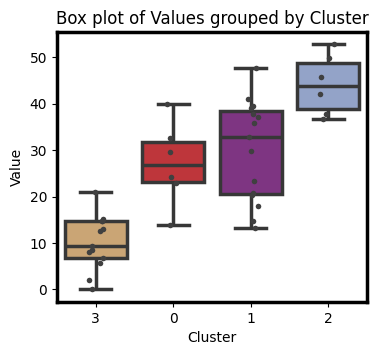

In [99]:
# Assuming the dataframes umap_df and OncoPeaks_WM_stat are already loaded

# Step 1: Create a dictionary to group 'Sample_Order' by 'Cluster'
cluster_groups = umap_df.groupby('Cluster')['Sample_Order'].apply(list).to_dict()

#MBNL1 = chr3:152170789-152420359
#MEIS1 = chr2:66408623-66599345
#JMJD1C = chr10:63337520-63637208
#MEF2C = chr5:88721596-88962685
#HOXA9 = chr7:27085104-27214094
#IRX1 = chr5:3591892-3610979

#coordinates
index_to_select = 'chr3:152170789-152420359'  # replace with the actual index
selected_row = OncoPeaks_WM_stat.loc[index_to_select]

# Step 2: Pair the values from the selected row with the column names
sample_values = {col: selected_row[col] for col in OncoPeaks_WM_stat.columns}

# Step 3: Create a new dataframe for plotting
plot_data = []
for cluster, samples in cluster_groups.items():
    for sample in samples:
        if sample in sample_values:
            plot_data.append({'Cluster': cluster, 'Value': sample_values[sample]})

plot_df = pd.DataFrame(plot_data)

# Define the color palette for clusters
color_palette = {
    "0": "#D51F26", "1": "#89288F", "2": "#8A9FD1", "3": "#D8A767",
}

# Ensure 'Cluster' is of type string for the color palette to work
plot_df['Cluster'] = plot_df['Cluster'].astype(str)

# Specify order for the x-axis categories
sorted_order = ["3", "0", "1", "2"]  # Make sure this matches the order you want

# Step 4: Create the boxplot with a thicker outline and custom flierprops
plt.figure(figsize=(4, 3.5))
flierprops = dict(marker='o', markerfacecolor='black', markeredgecolor='black', markersize=3)

# Set hue equal to 'Cluster' to avoid the warning
ax = sns.boxplot(data=plot_df, x='Cluster', y='Value', palette=color_palette, 
                 order=sorted_order, hue='Cluster', linewidth=2.5, flierprops=flierprops, legend=False)

# Add 'flyers' using stripplot
sns.stripplot(data=plot_df, x="Cluster", y="Value", color="0.25", size=4, jitter=True, order=sorted_order)

# Step 5: Perform t-tests and Bonferroni correction
cluster_pairs = [("0", "1"), ("0", "2"), ("0", "3"), ("1", "2"), ("1", "3"), ("2", "3")]
p_values = []

for pair in cluster_pairs:
    cluster1 = plot_df[plot_df['Cluster'] == pair[0]]['Value']
    cluster2 = plot_df[plot_df['Cluster'] == pair[1]]['Value']
    t_stat, p_value = ttest_ind(cluster1, cluster2)
    p_values.append(p_value)
    print(f"T-test {pair[0]} vs {pair[1]}: t-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")

# Apply Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')

# Print the corrected p-values
print("\nBonferroni corrected p-values:")
for i, pair in enumerate(cluster_pairs):
    print(f"{pair[0]} vs {pair[1]}: corrected p-value = {pvals_corrected[i]:.3e} (reject null hypothesis: {reject[i]})")

# Step 7: Increase the linewidth of the plot borders
for _, spine in ax.spines.items():
    spine.set_linewidth(2.5)

# Step 8: Set plot title and labels
plt.title('Box plot of Values grouped by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Value')

# Step 9: Show the plot
#plt.savefig('Figure_Panels/Gene_Specific_Oncoprotein_Score_Box_Plot.png', dpi=300, bbox_inches='tight') #Fig_2B, Suppplementary_Figs
plt.show()


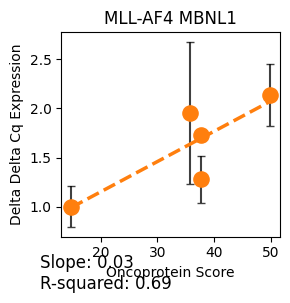

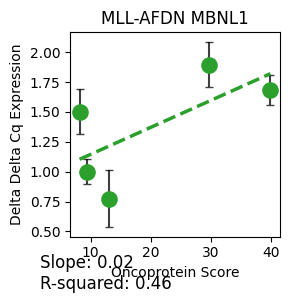

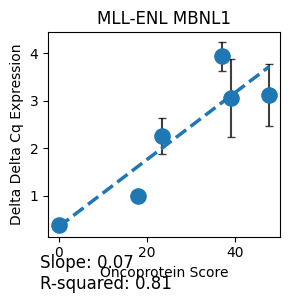

In [93]:
# Load the CSV file
X = pd.read_csv("MBNL1_QPCR_Oncoprotein_Table_052924.csv", sep=',', index_col=0)

# Transpose the dataframe
X = X.transpose()

# Convert all values to numbers
X = X.apply(pd.to_numeric, errors='coerce')

# Rename the fourth column
new_column_name = 'Oncoprotein Score'
columns = X.columns.tolist()
columns[3] = new_column_name  # Change the fourth column title
X.columns = columns

# Drop rows where the value in the specified column is less than 1
column_to_check = 'Delta Delta Cq Expression'  # Specify the column to check
X = X[X[column_to_check] > 0]

# Define the rows to keep based on the index
AF4_Samples = ['A5', 'SEM', 'p247', 'RS411', 'p179', 'p318', 'p279', 'p454']
AFDN_Samples = ['A80956', 'A70498', 'A82485', 'A89691', 'ML2']
ENL_Samples = ['148752', '152985', 'p186', 'p160', 'p214', 'KOPN8']

# Check and keep only the existing specified rows
AF4_Samples_QPCR = X.loc[X.index.intersection(AF4_Samples)]
AFDN_Samples_QPCR = X.loc[X.index.intersection(AFDN_Samples)]
ENL_Samples_QPCR = X.loc[X.index.intersection(ENL_Samples)]

xcol = 'Oncoprotein Score'
ycol = 'Delta Delta Cq Expression'
yerr = 'Delta Delta Cq St. Deviation'

# Function to create the plot
def create_plot(data, title, color): #, filename
    slope, intercept, r_value, p_value, std_err = linregress(data[xcol], data[ycol])
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.errorbar(data[xcol], data[ycol], yerr=data[yerr].to_numpy(), fmt='none', ecolor='black', alpha=0.75, capsize=3, zorder=1)
    sns.regplot(data=data, x=xcol, y=ycol, scatter_kws={'s': 120, 'color': color, 'alpha': 1}, line_kws={'color': color, 'linestyle': '--', 'linewidth': 2.5}, ci=None, ax=ax)
    textstr = f'Slope: {slope:.2f}\nR-squared: {r_value**2:.2f}'
    plt.gcf().text(0.15, 0.02, textstr, fontsize=12)
    plt.xlabel('Oncoprotein Score')
    plt.ylabel('Delta Delta Cq Expression')
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(filename)
    plt.show()

# Plot for AF4
create_plot(AF4_Samples_QPCR, 'MLL-AF4 MBNL1', sns.color_palette()[1], )#'Figure_Panels/Fig_2C.png')

# Plot for AFDN
create_plot(AFDN_Samples_QPCR, 'MLL-AFDN MBNL1', sns.color_palette()[2],) #'Figure_Panels/Fig_2C.png')

# Plot for ENL
create_plot(ENL_Samples_QPCR, 'MLL-ENL MBNL1', sns.color_palette()[0],) #'Figure_Panels/Fig_2C.png')


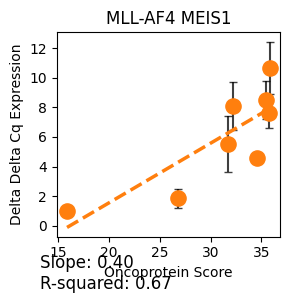

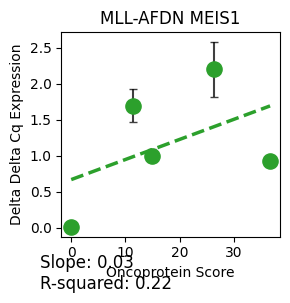

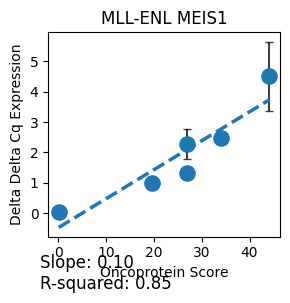

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the CSV file
X = pd.read_csv("MEIS1_QPCR_Oncoprotein_Table_052924.csv", sep=',', index_col=0)

# Transpose the dataframe
X = X.transpose()

# Convert all values to numbers
X = X.apply(pd.to_numeric, errors='coerce')

# Rename the fourth column
new_column_name = 'Oncoprotein Score'
columns = X.columns.tolist()
columns[3] = new_column_name  # Change the fourth column title
X.columns = columns

# Drop rows where the value in the specified column is less than 1
column_to_check = 'Delta Delta Cq Expression'  # Specify the column to check
X = X[X[column_to_check] > 0]

# Define the rows to keep based on the index
AF4_Samples = ['A5', 'SEM', 'p247', 'RS411', 'p179', 'p318', 'p279', 'p454']
AFDN_Samples = ['A80956', 'A70498', 'A82485', 'A89691', 'ML2']
ENL_Samples = ['148752', '152985', 'p186', 'p160', 'p214', 'KOPN8']

# Check and keep only the existing specified rows
AF4_Samples_QPCR = X.loc[X.index.intersection(AF4_Samples)]
AFDN_Samples_QPCR = X.loc[X.index.intersection(AFDN_Samples)]
ENL_Samples_QPCR = X.loc[X.index.intersection(ENL_Samples)]

xcol = 'Oncoprotein Score'
ycol = 'Delta Delta Cq Expression'
yerr = 'Delta Delta Cq St. Deviation'

# Function to create the plot
def create_plot(data, title, color): #, filename
    slope, intercept, r_value, p_value, std_err = linregress(data[xcol], data[ycol])
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.errorbar(data[xcol], data[ycol], yerr=data[yerr].to_numpy(), fmt='none', ecolor='black', alpha=0.75, capsize=3, zorder=1)
    sns.regplot(data=data, x=xcol, y=ycol, scatter_kws={'s': 120, 'color': color, 'alpha': 1}, line_kws={'color': color, 'linestyle': '--', 'linewidth': 2.5}, ci=None, ax=ax)
    textstr = f'Slope: {slope:.2f}\nR-squared: {r_value**2:.2f}'
    plt.gcf().text(0.15, 0.02, textstr, fontsize=12)
    plt.xlabel('Oncoprotein Score')
    plt.ylabel('Delta Delta Cq Expression')
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(filename)
    plt.show()

# Plot for AF4
create_plot(AF4_Samples_QPCR, 'MLL-AF4 MEIS1', sns.color_palette()[1], )#'Figure_Panels/Supplementary_Fig_2C.png')

# Plot for AFDN
create_plot(AFDN_Samples_QPCR, 'MLL-AFDN MEIS1', sns.color_palette()[2],) #'Figure_Panels/Supplementary_Fig_2C.png')

# Plot for ENL
create_plot(ENL_Samples_QPCR, 'MLL-ENL MEIS1', sns.color_palette()[0],) #'Figure_Panels/Supplementary_Fig_2C.png')


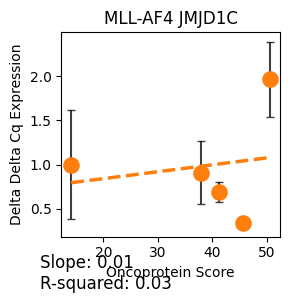

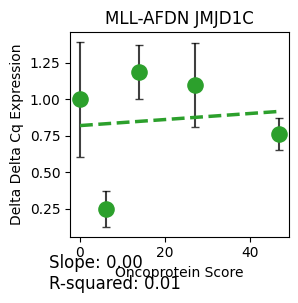

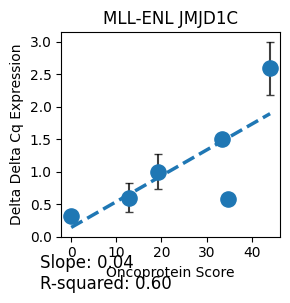

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the CSV file
X = pd.read_csv("JMJD1C_QPCR_Oncoprotein_Table_052924.csv", sep=',', index_col=0)

# Transpose the dataframe
X = X.transpose()

# Convert all values to numbers
X = X.apply(pd.to_numeric, errors='coerce')

# Rename the fourth column
new_column_name = 'Oncoprotein Score'
columns = X.columns.tolist()
columns[3] = new_column_name  # Change the fourth column title
X.columns = columns

# Drop rows where the value in the specified column is less than 1
column_to_check = 'Delta Delta Cq Expression'  # Specify the column to check
X = X[X[column_to_check] > 0]

# Define the rows to keep based on the index
AF4_Samples = ['A5', 'SEM', 'p247', 'RS411', 'p179', 'p318', 'p279', 'p454']
AFDN_Samples = ['A80956', 'A70498', 'A82485', 'A89691', 'ML2']
ENL_Samples = ['148752', '152985', 'p186', 'p160', 'p214', 'KOPN8']

# Check and keep only the existing specified rows
AF4_Samples_QPCR = X.loc[X.index.intersection(AF4_Samples)]
AFDN_Samples_QPCR = X.loc[X.index.intersection(AFDN_Samples)]
ENL_Samples_QPCR = X.loc[X.index.intersection(ENL_Samples)]

xcol = 'Oncoprotein Score'
ycol = 'Delta Delta Cq Expression'
yerr = 'Delta Delta Cq St. Deviation'

# Function to create the plot
def create_plot(data, title, color): #, filename
    slope, intercept, r_value, p_value, std_err = linregress(data[xcol], data[ycol])
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.errorbar(data[xcol], data[ycol], yerr=data[yerr].to_numpy(), fmt='none', ecolor='black', alpha=0.75, capsize=3, zorder=1)
    sns.regplot(data=data, x=xcol, y=ycol, scatter_kws={'s': 120, 'color': color, 'alpha': 1}, line_kws={'color': color, 'linestyle': '--', 'linewidth': 2.5}, ci=None, ax=ax)
    textstr = f'Slope: {slope:.2f}\nR-squared: {r_value**2:.2f}'
    plt.gcf().text(0.15, 0.02, textstr, fontsize=12)
    plt.xlabel('Oncoprotein Score')
    plt.ylabel('Delta Delta Cq Expression')
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(filename)
    plt.show()

# Plot for AF4
create_plot(AF4_Samples_QPCR, 'MLL-AF4 JMJD1C', sns.color_palette()[1], )#'Figure_Panels/Supplementary_Fig_2F.png')

# Plot for AFDN
create_plot(AFDN_Samples_QPCR, 'MLL-AFDN JMJD1C', sns.color_palette()[2],) #'Figure_Panels/Supplementary_Fig_2F.png')

# Plot for ENL
create_plot(ENL_Samples_QPCR, 'MLL-ENL JMJD1C', sns.color_palette()[0],) #'Figure_Panels/Supplementary_Fig_2F.png')


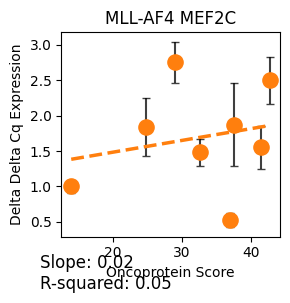

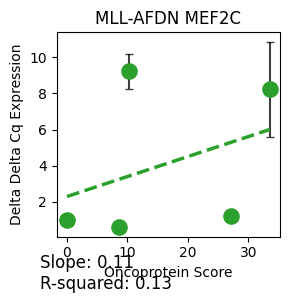

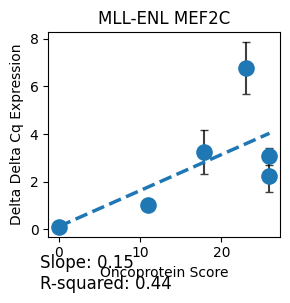

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the CSV file
X = pd.read_csv("MEF2C_QPCR_Oncoprotein_Table_052924.csv", sep=',', index_col=0)

# Transpose the dataframe
X = X.transpose()

# Convert all values to numbers
X = X.apply(pd.to_numeric, errors='coerce')

# Rename the fourth column
new_column_name = 'Oncoprotein Score'
columns = X.columns.tolist()
columns[3] = new_column_name  # Change the fourth column title
X.columns = columns

# Drop rows where the value in the specified column is less than 1
column_to_check = 'Delta Delta Cq Expression'  # Specify the column to check
X = X[X[column_to_check] > 0]

# Define the rows to keep based on the index
AF4_Samples = ['A5', 'SEM', 'p247', 'RS411', 'p179', 'p318', 'p279', 'p454']
AFDN_Samples = ['A80956', 'A70498', 'A82485', 'A89691', 'ML2']
ENL_Samples = ['148752', '152985', 'p186', 'p160', 'p214', 'KOPN8']

# Check and keep only the existing specified rows
AF4_Samples_QPCR = X.loc[X.index.intersection(AF4_Samples)]
AFDN_Samples_QPCR = X.loc[X.index.intersection(AFDN_Samples)]
ENL_Samples_QPCR = X.loc[X.index.intersection(ENL_Samples)]

xcol = 'Oncoprotein Score'
ycol = 'Delta Delta Cq Expression'
yerr = 'Delta Delta Cq St. Deviation'

# Function to create the plot
def create_plot(data, title, color): #, filename
    slope, intercept, r_value, p_value, std_err = linregress(data[xcol], data[ycol])
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.errorbar(data[xcol], data[ycol], yerr=data[yerr].to_numpy(), fmt='none', ecolor='black', alpha=0.75, capsize=3, zorder=1)
    sns.regplot(data=data, x=xcol, y=ycol, scatter_kws={'s': 120, 'color': color, 'alpha': 1}, line_kws={'color': color, 'linestyle': '--', 'linewidth': 2.5}, ci=None, ax=ax)
    textstr = f'Slope: {slope:.2f}\nR-squared: {r_value**2:.2f}'
    plt.gcf().text(0.15, 0.02, textstr, fontsize=12)
    plt.xlabel('Oncoprotein Score')
    plt.ylabel('Delta Delta Cq Expression')
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(filename)
    plt.show()

# Plot for AF4
create_plot(AF4_Samples_QPCR, 'MLL-AF4 MEF2C', sns.color_palette()[1], )#'Figure_Panels/Supplementary_Fig_2I.png')

# Plot for AFDN
create_plot(AFDN_Samples_QPCR, 'MLL-AFDN MEF2C', sns.color_palette()[2],) #'Figure_Panels/Supplementary_Fig_2I.png')

# Plot for ENL
create_plot(ENL_Samples_QPCR, 'MLL-ENL MEF2C', sns.color_palette()[0],) #'Figure_Panels/Supplementary_Fig_2I.png')


In [108]:
#This setion applies the oncoprotein score function to MLL::AF4 samples with sample specific peak sets (SSPS)
#We identify the list of MLL oncoprotein and normal MLL binding sites. 

Sample_bed = ['DJ_Hs_SEM_KMT2A_Cterm_200331.bed']
bed2 = 'DJ_Hs_SEM_KMT2A_Nterm_200331.bed'
peakfile = 'DJ_Hs_SEM_KMT2A_All_Peaks.bed'

for bed in Sample_bed:
    SEM_NC_Score_SSPS = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_p279_KMT2A_Cterm_230613.bed']
bed2 = 'DJ_Hs_p279_KMT2A_Nterm_230613.bed'
peakfile = 'DJ_Hs_p279_KMT2A_All_Peaks.bed'

for bed in Sample_bed:
    p279_NC_Score_SSPS = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_p318_KMT2A_Cterm_230613.bed']
bed2 = 'DJ_Hs_p318_KMT2A_Nterm_230613.bed'
peakfile = 'DJ_Hs_p318_KMT2A_All_Peaks.bed'

for bed in Sample_bed:
    p318_NC_Score_SSPS = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_p454_KMT2A_Cterm_230613.bed']
bed2 = 'DJ_Hs_p454_KMT2A_Nterm_230613.bed'
peakfile = 'DJ_Hs_p454_KMT2A_All_Peaks.bed'

for bed in Sample_bed:
    p454_NC_Score_SSPS = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

samplin N
samplin C
log2 ratios
Found 491 peaks with significant enrichment for .
samplin N
samplin C
log2 ratios
Found 272 peaks with significant enrichment for .
samplin N
samplin C
log2 ratios
Found 246 peaks with significant enrichment for .
samplin N
samplin C
log2 ratios
Found 438 peaks with significant enrichment for .


In [115]:
# The Quatify_Coverage function to process each sample
def Quatify_Coverage(bed, df):
    Sample_bed = BedTool(bed)
    Sample_NC_Score_bed = df
    
    # Calculate Coverage for bed file
    Sample_tbp_coverage = pd.read_csv(Sample_bed.fn, sep='\t')
    Sample_tbp_coverage = Sample_tbp_coverage.iloc[:, :3]
    Sample_tbp_coverage.columns = ['chrom', 'start', 'stop']
    Sample_tbp_coverage = Sample_tbp_coverage.drop_duplicates(subset=['chrom', 'start', 'stop'])
    Sample_Unique = Sample_tbp_coverage
    Sample_tbp_coverage['bp'] = Sample_tbp_coverage['stop'] - Sample_tbp_coverage['start']
    Sample_tbp_coverage = Sample_tbp_coverage["bp"].sum()

    # Determine the bp overlap
    Sample_NC_Score_bed = Sample_NC_Score_bed[['chrom', 'start', 'stop', 'enriched', 'Weighted_Magnitude']]
    Sample_NC_Score_bed = BedTool.from_dataframe(Sample_NC_Score_bed)
    Sample_Unique_bed = BedTool.from_dataframe(Sample_Unique)
    Sample_overlap_int_sum = Sample_NC_Score_bed.intersect(Sample_Unique_bed, wao=True)
    Sample_overlap_int_sum = pd.read_csv(Sample_overlap_int_sum.fn, sep='\t')
    Sample_overlap_int_sum.columns = ['chrom', 'start', 'stop', 'enriched', 'Weighted_Magnitude', 'chrom2', 'start2', 'stop2', 'blah1', 'overlap']
    Sample_overlap_int_sum = Sample_overlap_int_sum.groupby(['chrom', 'start', 'stop', 'enriched', 'Weighted_Magnitude']).agg({'overlap': 'sum'}).reset_index()
    Sample_overlap_int_sum.columns = ['chrom', 'start', 'stop', 'enriched', 'Weighted_Magnitude', 'Sample_sum']
    Sample_overlap_int_sum['Sample_signal'] = (Sample_overlap_int_sum['Sample_sum'] * ((1 / Sample_tbp_coverage) * 1000000000)) + 1
    Sample_overlap_int_sum['peak_size'] = Sample_overlap_int_sum['stop'] - Sample_overlap_int_sum['start']
    Sample_overlap_int_sum['Sample_sum_norm'] = ((Sample_overlap_int_sum['Sample_sum'] / Sample_overlap_int_sum['peak_size']) * ((1 / Sample_tbp_coverage) * 1000000000)) + 1
    
    return Sample_overlap_int_sum

# Function to combine and annotate the data
def combine_data(input_files):
    combined_data = []
    for sample_name, (bed_file, df) in input_files.items():
        processed_df = Quatify_Coverage(bed_file, df)
        processed_df['Sample'] = sample_name
        combined_data.append(processed_df)
    return pd.concat(combined_data, axis=0)

# Function to calculate p-values
def calculate_p_values(data, samples):
    p_values = {}
    for sample in samples:
        sample_data = data[data['Sample'] == sample]
        true_values = sample_data[sample_data['enriched'] == True]['Sample_sum_norm']
        false_values = sample_data[sample_data['enriched'] == False]['Sample_sum_norm']
        if len(true_values) > 0 and len(false_values) > 0:
            stat, p_val = ttest_ind(true_values, false_values)
            p_values[sample] = p_val
        else:
            p_values[sample] = np.nan
    return p_values

# Function to plot the boxplot with p-values
def plot_boxplot(data, p_values, output_file=None):
    samples = ['SEM', 'p318', 'p279', 'p454']
    data['Sample_sum_norm'] = pd.to_numeric(data['Sample_sum_norm'], errors='coerce')
    data['Sample'] = pd.Categorical(data['Sample'], categories=samples, ordered=True)

    plt.figure(figsize=(5, 5))
    sns.boxplot(data=data, x='Sample', y='Sample_sum_norm', hue='enriched', fliersize=0,
                palette={False: 'black', True: 'red'}, linewidth=1.5)

    plt.yscale('log')
    plt.ylim(10 ** -0.2, 10 ** 2.2)

    for i, sample in enumerate(samples):
        sample_data = data[data['Sample'] == sample]
        p_val = p_values[sample]
        true_values = sample_data[sample_data['enriched'] == True]['Sample_sum_norm']
        false_values = sample_data[sample_data['enriched'] == False]['Sample_sum_norm']
        q3_true = true_values.quantile(0.75)
        q3_false = false_values.quantile(0.75)
        q3_max = max(q3_true, q3_false)
        plt.text(i, q3_max * 4, f'p={p_val:.2e}', ha='center', va='bottom', fontsize=10, color='black')

    plt.xlabel('Sample')
    plt.ylabel('Sample Sum Norm')
    plt.title('Box Plot of Sample Sum Norm by Sample and Enriched Status')
    plt.legend(title='Enriched', bbox_to_anchor=(1.05, 1), loc='upper left')

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')

    plt.show()

# Main workflow function
def process_and_plot(input_files, output_file=None):
    # Step 1: Combine the data
    combined_data = combine_data(input_files)
    
    # Step 2: Calculate p-values
    samples = ['SEM', 'p318', 'p279', 'p454']
    p_values = calculate_p_values(combined_data, samples)
    
    # Step 3: Plot the data
    plot_boxplot(combined_data, p_values, output_file=output_file)




In [109]:
# The Quatify_Coverage function to process each sample
def Quatify_Coverage(bed, df):
    Sample_bed = BedTool(bed)
    Sample_NC_Score_bed = df
    
    # Calculate Coverage for bed file
    Sample_tbp_coverage = pd.read_csv(Sample_bed.fn, sep='\t')
    Sample_tbp_coverage = Sample_tbp_coverage.iloc[:, :3]
    Sample_tbp_coverage.columns = ['chrom', 'start', 'stop']
    Sample_tbp_coverage = Sample_tbp_coverage.drop_duplicates(subset=['chrom', 'start', 'stop'])
    Sample_Unique = Sample_tbp_coverage
    Sample_tbp_coverage['bp'] = Sample_tbp_coverage['stop'] - Sample_tbp_coverage['start']
    Sample_tbp_coverage = Sample_tbp_coverage["bp"].sum()

    # Determine the bp overlap
    Sample_NC_Score_bed = Sample_NC_Score_bed[['chrom', 'start', 'stop', 'enriched', 'Weighted_Magnitude']]
    Sample_NC_Score_bed = BedTool.from_dataframe(Sample_NC_Score_bed)
    Sample_Unique_bed = BedTool.from_dataframe(Sample_Unique)
    Sample_overlap_int_sum = Sample_NC_Score_bed.intersect(Sample_Unique_bed, wao=True)
    
    # Modify the read_csv call to explicitly convert 'Sample_sum_norm' to numeric
    Sample_overlap_int_sum = pd.read_csv(Sample_overlap_int_sum.fn, sep='\t', dtype={'Sample_sum_norm': 'float'}, low_memory=False)
    
    Sample_overlap_int_sum.columns = ['chrom', 'start', 'stop', 'enriched', 'Weighted_Magnitude', 'chrom2', 'start2', 'stop2', 'blah1', 'overlap']
    
    Sample_overlap_int_sum = Sample_overlap_int_sum.groupby(['chrom', 'start', 'stop', 'enriched', 'Weighted_Magnitude']).agg({'overlap': 'sum'}).reset_index()
    Sample_overlap_int_sum.columns = ['chrom', 'start', 'stop', 'enriched', 'Weighted_Magnitude', 'Sample_sum']
    Sample_overlap_int_sum['Sample_signal'] = (Sample_overlap_int_sum['Sample_sum'] * ((1 / Sample_tbp_coverage) * 1000000000)) + 1
    Sample_overlap_int_sum['peak_size'] = Sample_overlap_int_sum['stop'] - Sample_overlap_int_sum['start']
    
    # Ensure 'Sample_sum_norm' is treated as a numeric column
    Sample_overlap_int_sum['Sample_sum_norm'] = ((Sample_overlap_int_sum['Sample_sum'] / Sample_overlap_int_sum['peak_size']) * ((1 / Sample_tbp_coverage) * 1000000000)) + 1
    Sample_overlap_int_sum['Sample_sum_norm'] = pd.to_numeric(Sample_overlap_int_sum['Sample_sum_norm'], errors='coerce')
    
    return Sample_overlap_int_sum

# Function to combine and annotate the data
def combine_data(input_files):
    combined_data = []
    for sample_name, (bed_file, df) in input_files.items():
        processed_df = Quatify_Coverage(bed_file, df)
        processed_df['Sample'] = sample_name
        combined_data.append(processed_df)
    return pd.concat(combined_data, axis=0)

# Function to calculate p-values
def calculate_p_values(data, samples):
    p_values = {}
    for sample in samples:
        sample_data = data[data['Sample'] == sample]
        true_values = sample_data[sample_data['enriched'] == True]['Sample_sum_norm']
        false_values = sample_data[sample_data['enriched'] == False]['Sample_sum_norm']
        if len(true_values) > 0 and len(false_values) > 0:
            stat, p_val = ttest_ind(true_values, false_values)
            p_values[sample] = p_val
        else:
            p_values[sample] = np.nan
    return p_values

# Function to plot the boxplot with p-values
def plot_boxplot(data, p_values, output_file=None):
    samples = ['SEM', 'p318', 'p279', 'p454']
    data['Sample_sum_norm'] = pd.to_numeric(data['Sample_sum_norm'], errors='coerce')
    data['Sample'] = pd.Categorical(data['Sample'], categories=samples, ordered=True)

    plt.figure(figsize=(5, 5))
    sns.boxplot(data=data, x='Sample', y='Sample_sum_norm', hue='enriched', fliersize=0,
                palette={False: 'black', True: 'red'}, linewidth=1.5)

    plt.yscale('log')
    plt.ylim(10 ** -0.2, 10 ** 2.2)

    for i, sample in enumerate(samples):
        sample_data = data[data['Sample'] == sample]
        p_val = p_values[sample]
        true_values = sample_data[sample_data['enriched'] == True]['Sample_sum_norm']
        false_values = sample_data[sample_data['enriched'] == False]['Sample_sum_norm']
        q3_true = true_values.quantile(0.75)
        q3_false = false_values.quantile(0.75)
        q3_max = max(q3_true, q3_false)
        plt.text(i, q3_max * 4, f'p={p_val:.2e}', ha='center', va='bottom', fontsize=10, color='black')

    plt.xlabel('Sample')
    plt.ylabel('Sample Sum Norm')
    plt.title('Box Plot of Sample Sum Norm by Sample and Enriched Status')
    plt.legend(title='Enriched', bbox_to_anchor=(1.05, 1), loc='upper left')

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')

    plt.show()

# Main workflow function
def process_and_plot(input_files, output_file=None):
    # Step 1: Combine the data
    combined_data = combine_data(input_files)
    
    # Step 2: Calculate p-values
    samples = ['SEM', 'p318', 'p279', 'p454']
    p_values = calculate_p_values(combined_data, samples)
    
    # Step 3: Plot the data
    plot_boxplot(combined_data, p_values, output_file=output_file)


In [110]:
# THIS CELL SPECIFIES THE INPUT LIST FOR THE Quantifying DOT1L, ENL, AF4 and H3K4me3 #
# The DOT1L, ENL, AF4, and H3K4me3 CUT&Tag data can be downloaded from GEO under the accession codes GSE252378 and GSE159608 
# The CUT&Tag data can be combined using the Combine_CnT_Replicate_BedFiles.sh and GenerateBedGraphsBigWigs.sh bash scripts

Dot1L_input_files = {
    'SEM':('SH_Hs_SEM_Dot1_D4O_0502.bed', SEM_NC_Score_SSPS),
    'p279':('DJ_Hs_p279_Dot1L_combined.bed', p279_NC_Score_SSPS),
    'p318':('DJ_Hs_p318_Dot1L_combined.bed', p318_NC_Score_SSPS),
    'p454':('DJ_Hs_p454_Dot1L_combined.bed', p454_NC_Score_SSPS)
}

ENL_input_files = {
    'SEM':('SH_Hs_SEM_MLL_ENL_0502.bed', SEM_NC_Score_SSPS),
    'p279':('DJ_Hs_p279_ENL_combined.bed', p279_NC_Score_SSPS),
    'p318':('DJ_Hs_p318_ENL_combined.bed', p318_NC_Score_SSPS),
    'p454':('DJ_Hs_p454_ENL_combined.bed', p454_NC_Score_SSPS)
}

AF4_input_files = {
    'SEM':('DJ_Hs_SEM_AFF1_Combined.bed', SEM_NC_Score_SSPS),
    'p279':('DJ_Hs_p279_AFF1_Combined.bed', p279_NC_Score_SSPS),
    'p318':('DJ_Hs_p318_AFF1_Combined.bed', p318_NC_Score_SSPS),
    'p454':('DJ_Hs_p454_AFF1_Combined.bed', p454_NC_Score_SSPS)
}

H3K4me3_input_files = {
    'SEM':('DJ_Hs_SEM_K4me3_combined.bed', SEM_NC_Score_SSPS),
    'p279':('DJ_Hs_p279_K4me3_combined.bed', p279_NC_Score_SSPS),
    'p318':('DJ_Hs_p318_K4me3_combined.bed', p318_NC_Score_SSPS),
    'p454':('DJ_Hs_p454_K4me3_combined.bed', p454_NC_Score_SSPS)
}

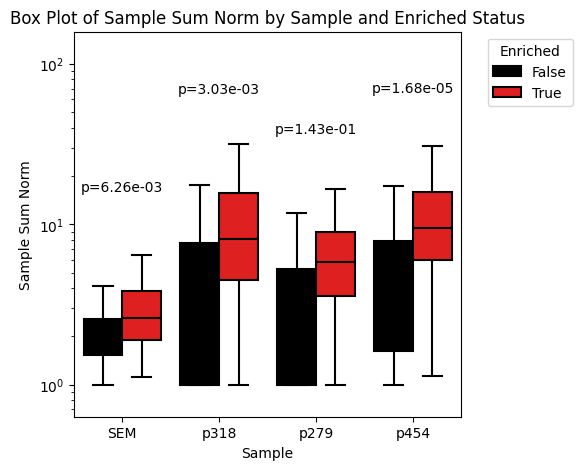

In [111]:
# Process and plot the data
process_and_plot(Dot1L_input_files) #, output_file='Figure_Panels/Supplementary_Fig_2K.png'

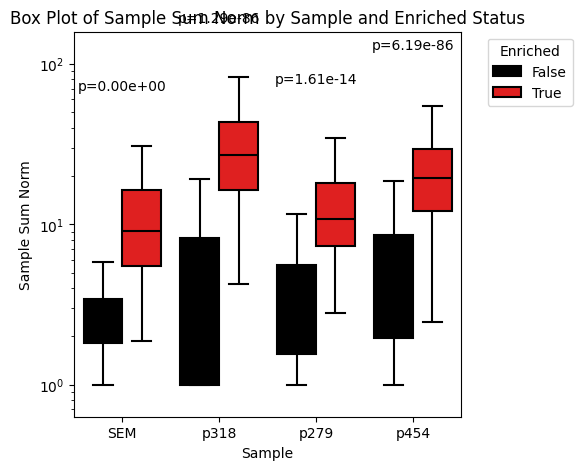

In [112]:
# Process and plot the data
process_and_plot(ENL_input_files) #, output_file='Figure_Panels/Fig_2D.png'


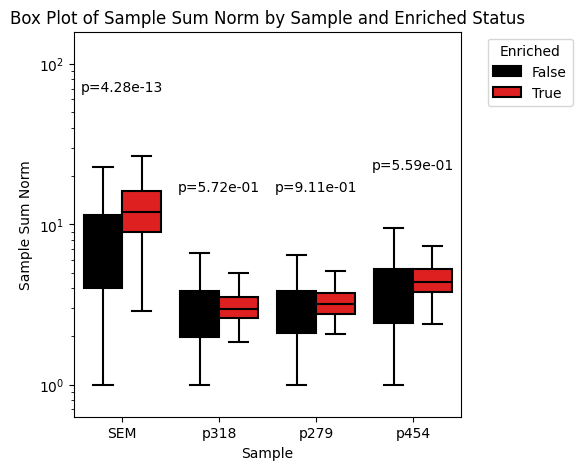

In [113]:
# Process and plot the data
process_and_plot(AF4_input_files) #, output_file='Figure_Panels/Supplementary_Fig_2J.png'


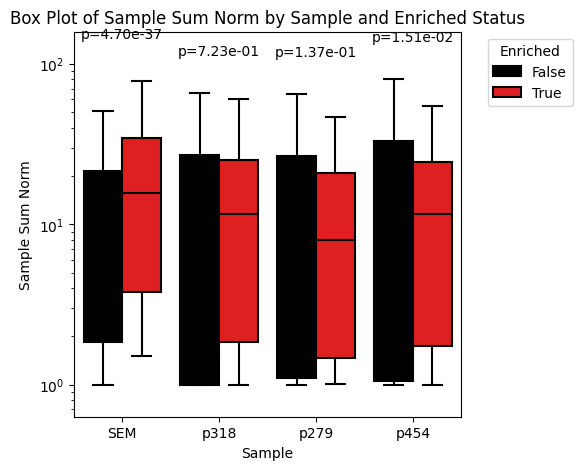

In [114]:
# Process and plot the data
process_and_plot(H3K4me3_input_files) #, output_file='Figure_Panels_for_Revision/Supplementary_Fig_2L.png'


In [42]:
# This loads the Two previsouly generate Oncoprotein Score tables available on GitHub. 
OncoPeaks_WM_stat = pd.read_csv("MLL_OncoPeaks_WM_stat.csv", sep=',', index_col=0)
average_ratio = np.loadtxt('MLL_OncoPeaks_WM_average_ratio.txt')
OncoPeaks_WM_stat.head(5)

,p160,p179,p186,p214,p247,p279,p318,p454,KOPN8,SEM,...,A70498,A93692,A89691,A82485,A73051,A80956,5395,5652,148752,152985
chr1:12337273-12347527,3.071647,15.932375,5.928155,0.042608,4.425297,16.455251,0.180630,26.509950,-0.037506,0.092909,...,-0.007166,0.032459,0.813539,0.507062,0.204590,-0.059694,0.040143,4.136764,0.012291,-0.010115
chr1:12375611-12382513,1.679312,2.152669,4.159570,0.896787,4.353450,8.519791,0.336633,5.670679,-0.079631,0.230149,...,-0.019851,-0.075876,0.281914,0.129686,1.333798,0.100427,0.502240,14.136590,0.250061,0.019034
chr1:12432973-12437401,8.419165,2.628350,0.052073,3.138738,0.243009,14.215742,-0.072371,14.403262,-0.028912,-0.007760,...,-0.033035,0.407495,0.217144,-0.056361,0.197066,-0.092790,0.428251,5.772661,0.799452,0.436413
chr1:12470612-12482527,6.270654,8.023291,0.695442,4.638810,4.090221,18.273777,1.458933,22.219636,-0.011948,1.069668,...,0.167282,0.113218,-0.026106,-0.021164,0.183109,-0.037602,1.240493,7.388615,0.229890,-0.017538
chr1:12612876-12621934,14.006232,14.487303,17.678986,6.336551,8.378889,13.954631,0.001029,19.431653,-0.055264,0.185288,...,-0.032630,-0.024104,0.378615,-0.059686,-0.026068,0.046478,12.405796,12.000247,0.937147,-0.015226


/tmp/ipykernel_27991/2181372610.py:20: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(data=x_pca_df, x=xcol, y=ycol, hue='MLL_Fusion', s=120, palette=custom_palette)


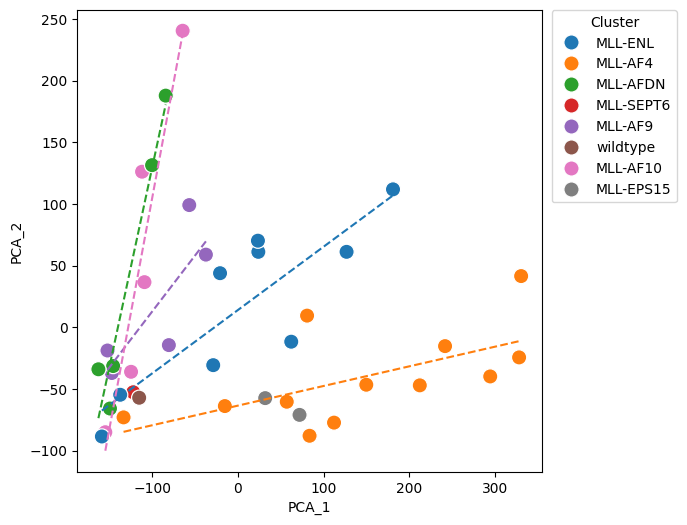

In [43]:
# Your existing data and setup
cutoff = 0
components = [1, 2]
colors = average_ratio
input_df = OncoPeaks_WM_stat.transpose()

# Perform PCA
pca = PCA(whiten=False)
x_pca = pca.fit_transform(input_df)
plt.figure(figsize=(6,6))
x_pca_df = pd.DataFrame(x_pca, columns=[f'PCA_{i+1}' for i in range(x_pca.shape[1])])
x_pca_df['MLL_Fusion'] = MLL_Fusion  # Add the 'MLL_Fusion' column to the DataFrame
xcol, ycol = f'PCA_{components[0]}', f'PCA_{components[1]}'

# Define a custom color palette with enough colors
num_clusters = x_pca_df['MLL_Fusion'].nunique()
custom_palette = sns.color_palette('tab10', num_clusters) + ['#DAA520', '#FFA500']

# Plot scatter points
sns.scatterplot(data=x_pca_df, x=xcol, y=ycol, hue='MLL_Fusion', s=120, palette=custom_palette)

# Loop through each unique hue and plot a regression line, excluding "MLL-EPS15"
for cluster in x_pca_df['MLL_Fusion'].unique():
    if cluster != "MLL-EPS15":
        cluster_data = x_pca_df[x_pca_df['MLL_Fusion'] == cluster]
        sns.regplot(
            data=cluster_data, x=xcol, y=ycol, scatter=False, ci=None, 
            color=custom_palette[list(x_pca_df['MLL_Fusion'].unique()).index(cluster)], 
            line_kws={'linestyle': '--', 'linewidth': 1.5}
        )

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Cluster')
#plt.savefig('Figure_Panels/Fig_3A.png', dpi=300, bbox_inches='tight')
plt.show()


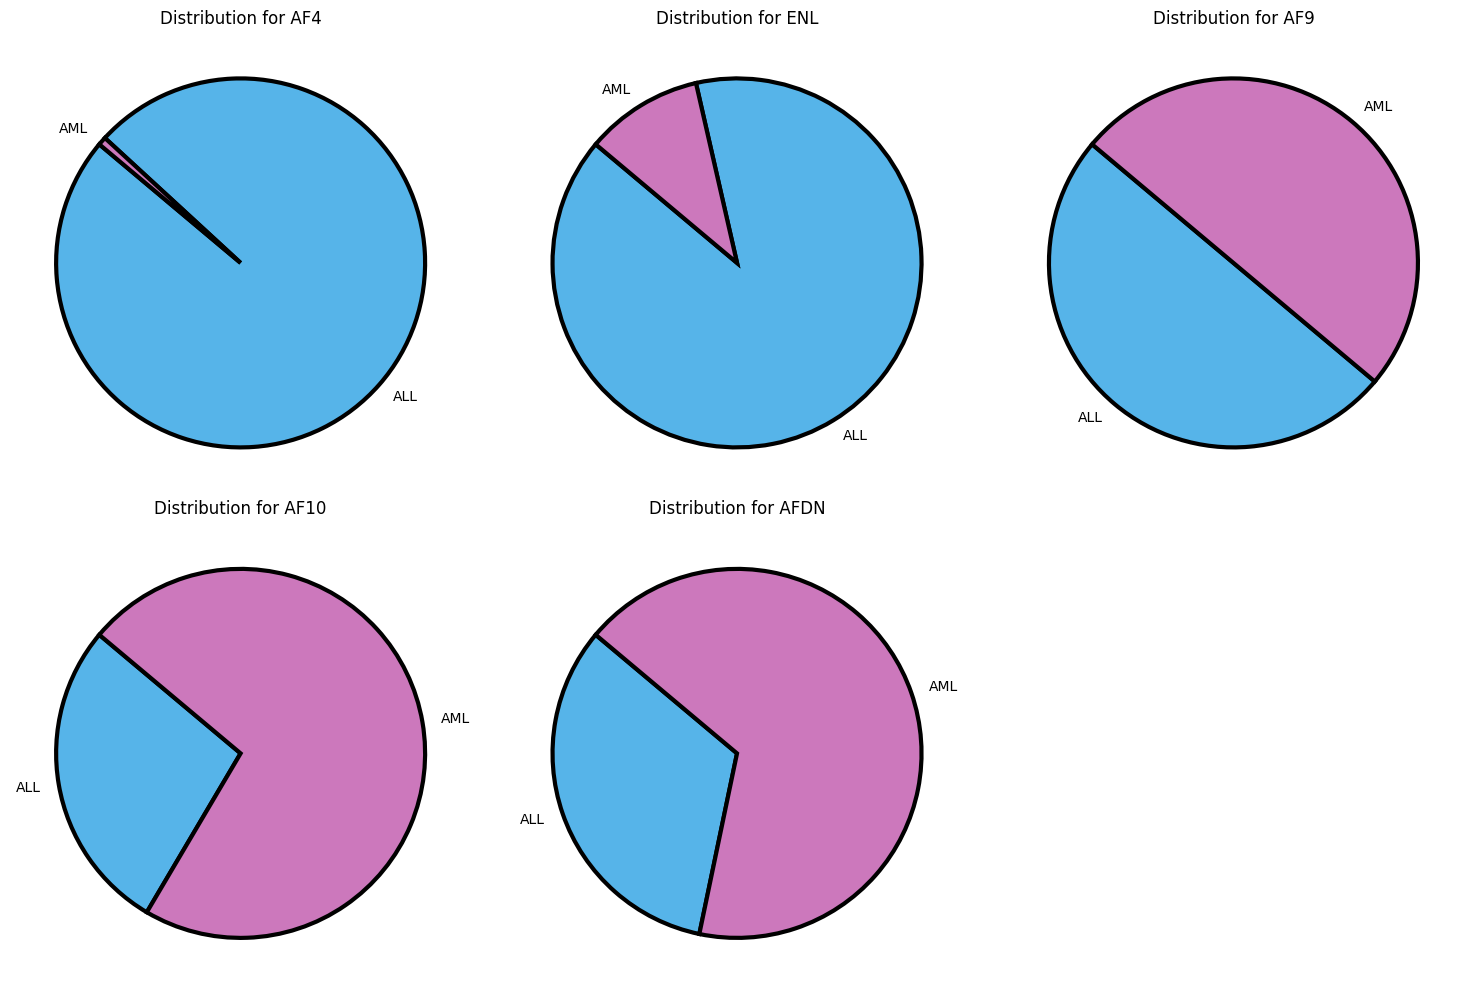

In [44]:
# Updated Numbers from Meyers et al. 2023
data = {
    'Gene': ['AF10', 'AF10', 'AF10',     'AF9', 'AF9', '  AF9', 'AFDN', 'AFDN',   'AFDN', 'AF4', 'AF4', 'AF4', 'ENL', 'ENL', 'ENL'],
    'Age': ['Adult', 'Infant', 'Ped', 'Adult', 'Infant', 'Ped', 'Adult', 'Infant', 'Ped', 'Adult', 'Infant', 'Ped', 'Adult', 'Infant', 'Ped'],
    'ALL': [3,        59,        17,       8,       157,     91,      10,         3,     31,     535,      477,   215,       66,      234,    100],
    'AML': [44,       54,       109,       109,      56,    107,      45,        3,     42,      5,        3,    1,        16,      2,    28]
}
df_cleaned = pd.DataFrame(data)

# Order the genes in the desired sequence
gene_order = ['AF4', 'ENL', 'AF9', 'AF10', 'AFDN']

# Order the genes for pie charts
genes_row1 = ['AF4', 'ENL', 'AF9']
genes_row2 = ['AF10', 'AFDN']

# Group the data by 'Gene' and sum for each 'Gene' entry
gene_groups = df_cleaned.groupby('Gene')[['ALL', 'AML']].sum()

# Define color palette
all_colors = sns.color_palette("colorblind")
custom_colors = [all_colors[9], all_colors[4]]

# Create a figure with subplots - 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the size as needed

# Flatten the axis array for easy iteration
axs = axs.flatten()

# Plot pie charts for the first row
for i, gene in enumerate(genes_row1 + genes_row2):  # Concatenate the gene lists
    ax = axs[i]
    counts = gene_groups.loc[gene]
    ax.pie(counts, labels=counts.index, startangle=140, colors=custom_colors,
           wedgeprops=dict(edgecolor='black', linewidth=3))  # Increased edge line width here
    ax.set_title(f'Distribution for {gene}')

# If there are any subplots not used, we can hide them
for i in range(len(genes_row1 + genes_row2), len(axs)):
    axs[i].axis('off')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Save the figure as a PNG file
#plt.savefig('Figure_Panels/Fig_3A.png')

# Show the plot
plt.show()


Gene
  AF9    54.040404
AF10     72.377622
AF4       0.728155
AF9      50.000000
AFDN     67.164179
ENL      10.313901
Name: AML_Percentage, dtype: float64
AF4     0.159273
ENL     0.513490
AF9     0.907782
AF10    3.747876
AFDN    3.239102
dtype: float64
Correlation coefficient: 0.9009900728048226
P-value: 0.03683788171693744


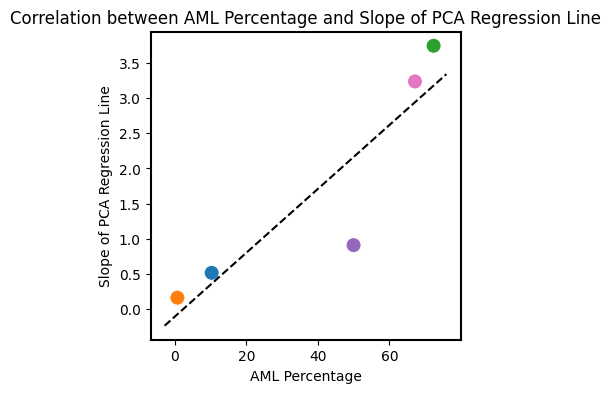

In [45]:
#from scipy.stats import linregress
# Calculate the 'AML' percentage for each gene
gene_groups['AML_Percentage'] = gene_groups['AML'] / (gene_groups['ALL'] + gene_groups['AML']) * 100
aml_percentages = gene_groups['AML_Percentage']
print(aml_percentages)

# Assuming x_pca_df and 'KMT2A_Fusion' values are already defined
slopes = {}
for gene in gene_order:  # Use the ordered list of genes that corresponds to fusion partners
    # Get the subset of PCA data for the fusion partner corresponding to the gene
    fusion_label = f'MLL-{gene}'
    subset = x_pca_df[x_pca_df['MLL_Fusion'] == fusion_label]
    
    # Perform linear regression and save the slope
    if not subset.empty:  # Check if there is data for the fusion partner
        slope, intercept, r_value, p_value, std_err = linregress(subset[xcol], subset[ycol])
        slopes[gene] = slope
    else:
        slopes[gene] = None  # Use None or np.nan for missing data

# Convert slopes to a pandas series for correlation calculation
slopes_series = pd.Series(slopes)
print(slopes_series)

#from scipy.stats import pearsonr

# Prepare a DataFrame from the percentages and slopes for correlation
correlation_df = pd.DataFrame({
    'AML_Percentage': aml_percentages.reindex(slopes_series.index),
    'Slope': slopes_series
}).dropna()  # Drop any rows with NaN values which indicate missing data

# Calculate correlation
correlation_coefficient, p_value = pearsonr(correlation_df['AML_Percentage'], correlation_df['Slope'])

# Print the correlation and p-value
print(f'Correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

# Reset to default settings, if necessary
sns.reset_defaults()

# Load the default Seaborn color palette
default_palette = sns.color_palette()

# Select specific colors; note Python is 0-indexed so positions are offset by 1
# Colors at positions: 1 (0), 2 (1), 3 (2), 5 (4), and 6 (5)
custom_colors = [default_palette[i] for i in [1, 0, 4, 6, 2]]
custom_colors = [default_palette[i] for i in [1, 0, 4, 6, 2]]
custom_palette = sns.set_palette(custom_colors)


# Create a custom color palette
#reordered_colors = [custom_colors[i] for i in [1, 0, 2, 3, 4]]
#custom_palette = sns.set_palette(reordered_colors)

#sns.set_palette(reordered_colors)

# Assuming correlation_df is already defined and contains 'AML_Percentage' and 'Slope'

# Perform linear regression for the plot
slope, intercept, r_value, p_value, std_err = linregress(correlation_df['AML_Percentage'], correlation_df['Slope'])

# Create a scatter plot
plt.figure(figsize=(4, 4))
sns.scatterplot(data=correlation_df, x='AML_Percentage', y='Slope', hue='Slope', palette=custom_colors, s=120)

# Add a regression line
x_vals = np.array(plt.xlim())  # Get the current limit for x-axis
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color='black')
#plt.axhline(threshold, color='red', linestyle='--', linewidth=2)

# Assuming data and a plotting function such as scatter are previously defined
# For example: plt.scatter(data_x, data_y)

# Make axes lines thicker and set their color to black
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_edgecolor('black')  # Set the edge color of the spines to black

# Customize the plot
plt.title('Correlation between AML Percentage and Slope of PCA Regression Line')
plt.xlabel('AML Percentage')
plt.ylabel('Slope of PCA Regression Line')

# Remove the legend
legend = ax.get_legend()
if legend:
    legend.remove()

# Save the plot to a file
#plt.savefig('Figure_Panels/Fig_3B.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

/tmp/ipykernel_27991/4264778859.py:28: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(data=x_pca_df, x=xcol, y=ycol, hue='MLL_Fusion', s=120, palette=custom_palette)


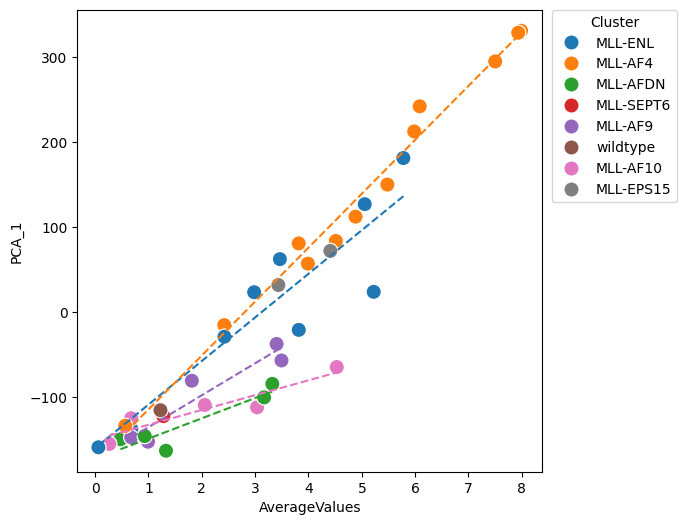

In [46]:
components = [1, 2]

# Perform PCA
pca = PCA(whiten=False)
x_pca = pca.fit_transform(OncoPeaks_WM_stat.transpose())

# Create a DataFrame with PCA results
x_pca_df = pd.DataFrame(x_pca, columns=[f'PCA_{i+1}' for i in range(x_pca.shape[1])])
x_pca_df['MLL_Fusion'] = MLL_Fusion  # Add the 'MLL_Fusion' column to the DataFrame
x_pca_df['AverageValues'] = average_ratio  # Add the 'AverageValues' as a new column

# Define the columns to be used in the plot
xcol = 'AverageValues'
ycol = f'PCA_{components[0]}'

# Define a custom color palette with enough colors
num_clusters = x_pca_df['MLL_Fusion'].nunique()
custom_palette = sns.color_palette('tab10', num_clusters) + ['#DAA520', '#FFA500']

plt.figure(figsize=(6,6))

# Plot scatter points with 'AverageValues' on the y-axis using the custom palette
sns.scatterplot(data=x_pca_df, x=xcol, y=ycol, hue='MLL_Fusion', s=120, palette=custom_palette)

# Plot regression lines for each 'MLL_Fusion' cluster
for cluster in x_pca_df['MLL_Fusion'].unique():
    if cluster != "MLL-EPS15":
        cluster_data = x_pca_df[x_pca_df['MLL_Fusion'] == cluster]
        cluster_index = list(x_pca_df['MLL_Fusion'].unique()).index(cluster)
        sns.regplot(data=cluster_data, x=xcol, y=ycol, scatter=False, ci=None, color=custom_palette[cluster_index], line_kws={'linestyle': '--', 'linewidth': 1.5})

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Cluster')
#plt.savefig('Figure_Panels/Supplementary_Fig_3A.png', dpi=300, bbox_inches='tight')
plt.show()


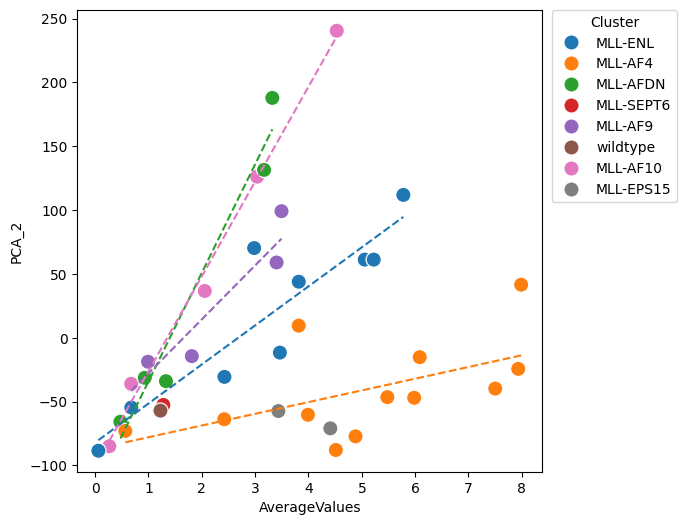

In [47]:
components = [1, 2]

# Perform PCA
pca = PCA(whiten=False)
x_pca = pca.fit_transform(OncoPeaks_WM_stat.transpose())

# Create a DataFrame with PCA results
x_pca_df = pd.DataFrame(x_pca, columns=[f'PCA_{i+1}' for i in range(x_pca.shape[1])])
x_pca_df['MLL_Fusion'] = MLL_Fusion  # Add the 'MLL_Fusion' column to the DataFrame
x_pca_df['AverageValues'] = average_ratio  # Add the 'AverageValues' as a new column

# Define the columns to be used in the plot
xcol = 'AverageValues'
ycol = f'PCA_{components[1]}'

# Define a custom color palette with enough colors
num_clusters = x_pca_df['MLL_Fusion'].nunique()
custom_palette = sns.color_palette('tab10', num_clusters) + ['#DAA520', '#FFA500']

plt.figure(figsize=(6,6))

# Map cluster names to custom palette
cluster_to_color = {cluster: custom_palette[i] for i, cluster in enumerate(x_pca_df['MLL_Fusion'].unique())}

# Plot scatter points with 'AverageValues' on the y-axis using the custom palette
sns.scatterplot(data=x_pca_df, x=xcol, y=ycol, hue='MLL_Fusion', s=120, palette=cluster_to_color)

# Plot regression lines for each 'KMT2A_Fusion' cluster
for cluster in x_pca_df['MLL_Fusion'].unique():
    if cluster != "MLL-EPS15":
        cluster_data = x_pca_df[x_pca_df['MLL_Fusion'] == cluster]
        sns.regplot(
            data=cluster_data, x=xcol, y=ycol, scatter=False, ci=None, 
            color=cluster_to_color[cluster], line_kws={'linestyle': '--', 'linewidth': 1.5}
        )

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Cluster')
#plt.savefig('Figure_Panels/Supplementary_Fig_3B.png', dpi=300, bbox_inches='tight')
plt.show()


In [48]:
# This loads the Two previsouly generate Oncoprotein Score tables available on GitHub. 
OncoPeaks_WM_stat = pd.read_csv("MLL_OncoPeaks_WM_stat.csv", sep=',', index_col=0)
average_ratio = np.loadtxt('MLL_OncoPeaks_WM_average_ratio.txt')
OncoPeaks_WM_stat.head(5)

,p160,p179,p186,p214,p247,p279,p318,p454,KOPN8,SEM,...,A70498,A93692,A89691,A82485,A73051,A80956,5395,5652,148752,152985
chr1:12337273-12347527,3.071647,15.932375,5.928155,0.042608,4.425297,16.455251,0.180630,26.509950,-0.037506,0.092909,...,-0.007166,0.032459,0.813539,0.507062,0.204590,-0.059694,0.040143,4.136764,0.012291,-0.010115
chr1:12375611-12382513,1.679312,2.152669,4.159570,0.896787,4.353450,8.519791,0.336633,5.670679,-0.079631,0.230149,...,-0.019851,-0.075876,0.281914,0.129686,1.333798,0.100427,0.502240,14.136590,0.250061,0.019034
chr1:12432973-12437401,8.419165,2.628350,0.052073,3.138738,0.243009,14.215742,-0.072371,14.403262,-0.028912,-0.007760,...,-0.033035,0.407495,0.217144,-0.056361,0.197066,-0.092790,0.428251,5.772661,0.799452,0.436413
chr1:12470612-12482527,6.270654,8.023291,0.695442,4.638810,4.090221,18.273777,1.458933,22.219636,-0.011948,1.069668,...,0.167282,0.113218,-0.026106,-0.021164,0.183109,-0.037602,1.240493,7.388615,0.229890,-0.017538
chr1:12612876-12621934,14.006232,14.487303,17.678986,6.336551,8.378889,13.954631,0.001029,19.431653,-0.055264,0.185288,...,-0.032630,-0.024104,0.378615,-0.059686,-0.026068,0.046478,12.405796,12.000247,0.937147,-0.015226


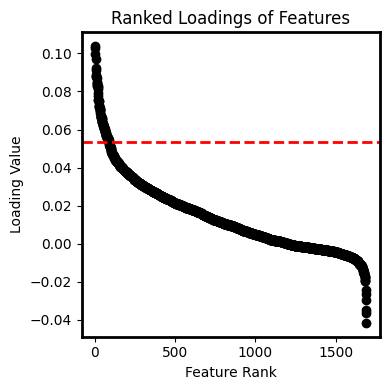

['RNF220', 'VAV3', 'VAV3-AS1', 'PTPRC', 'MIR181A1HG', 'MIR181B1', 'MIR181A1', 'LINC01222', 'LINC01221', 'CDK1', 'NRBF2', 'JMJD1C', 'MIR1296', 'JMJD1C-AS1', 'REEP3', 'KLLN', 'PTEN', 'DNTT', 'ZC3H12C', 'UBASH3B', 'LOC101928100', 'KLRK1', 'KLRC4-KLRK1', 'KLRC4', 'KLRC3', 'ETV6', 'CDKN1B', 'APOLD1', 'DDX47', 'MIR613', 'BCAT1', 'SOCS2-AS1', 'SOCS2', 'CRADD', 'LOC101928731', 'MED13L', 'MIR620', 'WDR66', 'BCL7A', 'FLT3', 'PAN3', 'FLT1', 'ELF1', 'WBP4', 'RB1', 'LPAR6', 'DLEU2', 'MIR16-1', 'MIR15A', 'DLEU1', 'ATP8B4', 'ZNF280D', 'LOC145783', 'TCF12', 'LINC01578', 'CHD2', 'MIR3175', 'NF1', 'OMG', 'EVI2B', 'EVI2A', 'BABAM2', 'LINC01122', 'BCL11A', 'MEIS1-AS3', 'MEIS1', 'MEIS1-AS2', 'LINC01798', 'ZEB2', 'ZEB2-AS1', 'LINC01412', 'TEX41', 'LAMP5-AS1', 'LAMP5', 'RUNX1', 'LOC101928269', 'ERG', 'ANKRD28', 'TBC1D5', 'ARPP21', 'FOXP1', 'MIR1284', 'MBNL1', 'MBNL1-AS1', 'TMEM14EP', 'IGF2BP2', 'IGF2BP2-AS1', 'MIR548AQ', 'TRA2B', 'CPEB2-DT', 'CPEB2', 'LOC101929095', 'PROM1', 'TAPT1', 'TAPT1-AS1', 'C4orf36', 

,Feature,Loading,Loading Squared,Rank,gene
0,chr1:198964424-199025101,0.103803,0.010775,1,"LINC01222, LINC01221"
1,chr9:77931156-78040906,0.103025,0.010614,2,GNAQ
2,chr13:28194009-28301278,0.099928,0.009986,3,"PAN3, FLT1"
3,chr9:37107573-37365579,0.097272,0.009462,4,ZCCHC7
4,chr4:16152184-16245766,0.092323,0.008524,5,"TAPT1, TAPT1-AS1"


In [52]:
# Assuming OncoPeaks_WM_stat and colors are defined earlier in your code.
input_df = OncoPeaks_WM_stat.transpose()

# Step 1: Load and prepare the gene list
ArchR_hg38_Gene_List =  pd.read_csv('rowDataGSM_hg38.csv', sep=',')
ArchR_hg38_Gene_List = ArchR_hg38_Gene_List.iloc[:, [1, 2, 3, 4, 5]]
ArchR_hg38_Gene_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
ArchR_hg38_Gene_List_1 = ArchR_hg38_Gene_List[ArchR_hg38_Gene_List['strand']==1]
ArchR_hg38_Gene_List_2 = ArchR_hg38_Gene_List[ArchR_hg38_Gene_List['strand']==2]
ArchR_hg38_Gene_List_2 = ArchR_hg38_Gene_List_2.iloc[:, [0, 2, 1, 3, 4]]
ArchR_hg38_Gene_List_2.columns = ['chrom', 'start', 'stop', 'strand','gene' ]
hg38_Gene_List = pd.concat([ArchR_hg38_Gene_List_1, ArchR_hg38_Gene_List_2])
hg38_Gene_List = hg38_Gene_List.sort_values(['chrom', 'start'],
              ascending = [True, True])
hg38_Gene_List['Real'] = [1 if (x - y)<2500000 else 0 for x,y in zip(hg38_Gene_List['stop'], hg38_Gene_List['start'])]
hg38_Gene_List_1 = hg38_Gene_List[hg38_Gene_List['Real']==1]

hg38_Gene_List_1 = hg38_Gene_List_1.iloc[:, [0, 1, 2, 3, 4]]

hg38_Gene_List_2 = hg38_Gene_List[hg38_Gene_List['Real']==0]

hg38_Gene_List_bed = BedTool.from_dataframe(hg38_Gene_List_1)

# Perform PCA
pca = PCA(whiten=False)
x_pca = pca.fit_transform(input_df)

# Specify the component of interest
pc_number = 1  # Python uses 0-indexing, so this will be the first principal component (PCA_1)

# Ensure that 'features' corresponds to the number of features/columns in 'input_df'
features = input_df.columns  # This should correspond to original features before transposing

# Extract loadings for the specified component
# The 'pca.components_' should have a shape of (n_components, n_features)
if pca.components_.shape[1] != len(features):
    raise ValueError("The PCA component size does not match the number of features.")

loadings = pca.components_[pc_number - 1]  # Subtract 1 for 0-based index
loading_squared = loadings ** 2  # Square to get variance contributions

# Create a DataFrame of loadings
loadings_df = pd.DataFrame({
    'Feature': features,  # Make sure this matches the number of features in 'input_df'
    'Loading': loadings,
    'Loading Squared': loading_squared
})


# Assuming 'loadings_df' is already sorted with the 'Loading' column available
# Calculate the mean and standard deviation for the loadings
mean_loadings = loadings_df['Loading'].mean()
std_loadings = loadings_df['Loading'].std()

# Set the threshold at two standard deviations above the mean
threshold = mean_loadings + (std_loadings * 2)

# Sort the DataFrame by 'Loading' in descending order
loadings_df_sorted = loadings_df.sort_values('Loading', ascending=False).reset_index(drop=True)

# Add a 'Rank' column to the sorted DataFrame
loadings_df_sorted['Rank'] = loadings_df_sorted.index + 1

# Plot the ranked loadings
plt.figure(figsize=(4, 4))
plt.scatter(loadings_df_sorted['Rank'], loadings_df_sorted['Loading'], color='black')

# Draw a horizontal line for the threshold
plt.axhline(threshold, color='red', linestyle='--', linewidth=2)

plt.title('Ranked Loadings of Features')
plt.xlabel('Feature Rank')
plt.ylabel('Loading Value')

#plt.savefig('Figure_Panels/Fig_3C.png', dpi=300, bbox_inches='tight')

# Make axes and line thicker
ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.show()
# Select features with loadings above the threshold
significant_features = loadings_df_sorted[loadings_df_sorted['Loading'] >= threshold]

# Extract chromosome, start, and stop positions
X = significant_features['Feature'].astype(str).str.extract(r'(chr.*):(\d+)-(\d+)')
X.columns = ['chrom', 'start', 'stop']
X['start'] = pd.to_numeric(X['start'])
X['stop'] = pd.to_numeric(X['stop'])
X = BedTool.from_dataframe(X)

# Assuming hg38_Gene_List_bed is your gene list in BedTool format
# hg38_Gene_List_bed = BedTool('path_to_hg38_gene_list.bed')

# Perform the intersection
X = X.intersect(hg38_Gene_List_bed, wao=True)
X = pd.read_csv(X.fn, sep='\t', header=None)

# Rename columns to avoid conflict
X.columns = ['chrom', 'start', 'stop', 'chrom_2', 'start_2', 'stop_2', 'strand', 'gene', 'overlap']

# Create 'Feature' column for merging
X['Feature'] = X['chrom'] + ':' + X['start'].astype(str) + '-' + X['stop'].astype(str)

# Group by 'Feature' and combine gene names separated by a comma and a space
X_grouped = X.groupby('Feature')['gene'].apply(lambda x: ', '.join(x)).reset_index()

# Merge combined gene names back to the original dataframe
result = significant_features.merge(X_grouped, on='Feature', how='left')

# Select features above the Kaiser's threshold for PCA loadings
X = significant_features['Feature'].astype(str).str.extract(r'(chr.*):(\d+)-(\d+)')
X.columns = ['chrom', 'start', 'stop']
X['start'] = pd.to_numeric(X['start'])
X['stop'] = pd.to_numeric(X['stop'])
X = BedTool.from_dataframe(X)

X = hg38_Gene_List_bed.intersect(X, u=True)
X = pd.read_csv(X.fn, sep='\t', header=None)
X.columns = ['chrom', 'start', 'stop', 'strand', 'gene']
list_of_PC1_genes = X['gene'].values.tolist()
print(list_of_PC1_genes)

#result.to_csv('Figure_Panels/Supplementary_Information_Table_PC1_Genes.csv', index=False)

# Display the result
result.head(5)



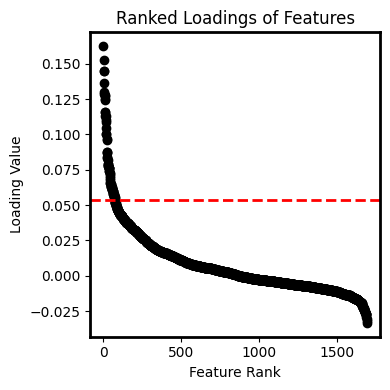

['RNF220', 'IL12RB2', 'CASC10', 'MIR1915', 'SKIDA1', 'MLLT10', 'DNAJC1', 'LOC100130992', 'COMMD3', 'COMMD3-BMI1', 'BMI1', 'SPAG6', 'JMJD1C', 'MIR1296', 'JMJD1C-AS1', 'REEP3', 'LOC374443', 'CLEC2D', 'CLECL1', 'CD69', 'CLEC2A', 'LINC02470', 'CLEC12A-AS1', 'CLEC12A', 'LINC00938', 'ARID2', 'SOCS2-AS1', 'SOCS2', 'CRADD', 'LOC101928731', 'DACH1', 'LOC283683', 'NIPA1', 'GOLGA8M', 'GOLGA8R', 'GOLGA8O', 'LINC02256', 'GOLGA8N', 'ARHGAP11A', 'CCDC144NL', 'CCDC144NL-AS1', 'LOC339260', 'ZNF521', 'TCF4', 'MEIS1-AS3', 'MEIS1', 'MEIS1-AS2', 'LINC01798', 'ZEB2', 'ZEB2-AS1', 'LINC01412', 'BAZ2B', 'LOC643072', 'LINC00899', 'PRR34', 'PRR34-AS1', 'MIRLET7BHG', 'MIR3619', 'MIRLET7A3', 'MIR4763', 'MIRLET7B', 'TBC1D5', 'SATB1', 'SATB1-AS1', 'EIF4E3', 'GPR27', 'MBNL1', 'MBNL1-AS1', 'TMEM14EP', 'SNCA', 'SNCA-AS1', 'MMRN1', 'GUCY1A1', 'GUCY1B1', 'LOC648987', 'ANXA2R', 'LOC153684', 'LOC100506639', 'PDE4D', 'TNPO1', 'MEF2C', 'MEF2C-AS1', 'H2AFY', 'SENP6', 'NKAIN2', 'MYB', 'SNX10', 'LOC441204', 'SKAP2', 'HOXA1', 'H

,Feature,Loading,Loading Squared,Rank,gene
0,chr7:26655269-26767358,0.162427,0.026383,1,SKAP2
1,chr15:28707474-28837319,0.152559,0.023274,2,GOLGA8M
2,chr15:22613681-22766644,0.144973,0.021017,3,LOC283683
3,chr7:26770107-26874733,0.144838,0.020978,4,SKAP2
4,chr6:75582079-75683971,0.136338,0.018588,5,SENP6


In [50]:
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming OncoPeaks_WM_stat and colors are defined earlier in your code.
input_df = OncoPeaks_WM_stat.transpose()

# Perform PCA
pca = PCA(whiten=False)
x_pca = pca.fit_transform(input_df)

# Specify the component of interest
pc_number = 2  # Python uses 0-indexing, so this will be the first principal component (PCA_1)

# Ensure that 'features' corresponds to the number of features/columns in 'input_df'
features = input_df.columns  # This should correspond to original features before transposing

# Extract loadings for the specified component
# The 'pca.components_' should have a shape of (n_components, n_features)
if pca.components_.shape[1] != len(features):
    raise ValueError("The PCA component size does not match the number of features.")

loadings = pca.components_[pc_number - 1]  # Subtract 1 for 0-based index
loading_squared = loadings ** 2  # Square to get variance contributions

# Create a DataFrame of loadings
loadings_df = pd.DataFrame({
    'Feature': features,  # Make sure this matches the number of features in 'input_df'
    'Loading': loadings,
    'Loading Squared': loading_squared
})


# Assuming 'loadings_df' is already sorted with the 'Loading' column available
# Calculate the mean and standard deviation for the loadings
mean_loadings = loadings_df['Loading'].mean()
std_loadings = loadings_df['Loading'].std()

# Set the threshold at two standard deviations above the mean
threshold = mean_loadings + (std_loadings * 2)

# Sort the DataFrame by 'Loading' in descending order
loadings_df_sorted = loadings_df.sort_values('Loading', ascending=False).reset_index(drop=True)

# Add a 'Rank' column to the sorted DataFrame
loadings_df_sorted['Rank'] = loadings_df_sorted.index + 1

# Plot the ranked loadings
plt.figure(figsize=(4, 4))
plt.scatter(loadings_df_sorted['Rank'], loadings_df_sorted['Loading'], color='black')

# Draw a horizontal line for the threshold
plt.axhline(threshold, color='red', linestyle='--', linewidth=2)

plt.title('Ranked Loadings of Features')
plt.xlabel('Feature Rank')
plt.ylabel('Loading Value')

#plt.savefig('Figure_Panels/Fig_3D.png', dpi=300, bbox_inches='tight')

# Make axes and line thicker
ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.show()
# Select features with loadings above the threshold
significant_features = loadings_df_sorted[loadings_df_sorted['Loading'] >= threshold]

import pandas as pd
from pybedtools import BedTool

# Extract chromosome, start, and stop positions
X = significant_features['Feature'].astype(str).str.extract(r'(chr.*):(\d+)-(\d+)')
X.columns = ['chrom', 'start', 'stop']
X['start'] = pd.to_numeric(X['start'])
X['stop'] = pd.to_numeric(X['stop'])
X = BedTool.from_dataframe(X)

# Assuming hg38_Gene_List_bed is your gene list in BedTool format
# hg38_Gene_List_bed = BedTool('path_to_hg38_gene_list.bed')

# Perform the intersection
X = X.intersect(hg38_Gene_List_bed, wao=True)
X = pd.read_csv(X.fn, sep='\t', header=None)

# Rename columns to avoid conflict
X.columns = ['chrom', 'start', 'stop', 'chrom_2', 'start_2', 'stop_2', 'strand', 'gene', 'overlap']

# Create 'Feature' column for merging
X['Feature'] = X['chrom'] + ':' + X['start'].astype(str) + '-' + X['stop'].astype(str)

# Group by 'Feature' and combine gene names separated by a comma and a space
X_grouped = X.groupby('Feature')['gene'].apply(lambda x: ', '.join(x)).reset_index()

# Merge combined gene names back to the original dataframe
result = significant_features.merge(X_grouped, on='Feature', how='left')

#result.to_csv('Figure_Panels/Supplementary_Information_Table_PC2_Genes.csv', index=False)

# Select features above the Kaiser's threshold for PCA loadings
X = significant_features['Feature'].astype(str).str.extract(r'(chr.*):(\d+)-(\d+)')
X.columns = ['chrom', 'start', 'stop']
X['start'] = pd.to_numeric(X['start'])
X['stop'] = pd.to_numeric(X['stop'])
X = BedTool.from_dataframe(X)

X = hg38_Gene_List_bed.intersect(X, u=True)
X = pd.read_csv(X.fn, sep='\t', header=None)
X.columns = ['chrom', 'start', 'stop', 'strand', 'gene']
list_of_PC2_genes = X['gene'].values.tolist()
print(list_of_PC2_genes)

# Display the result
result.head(5)


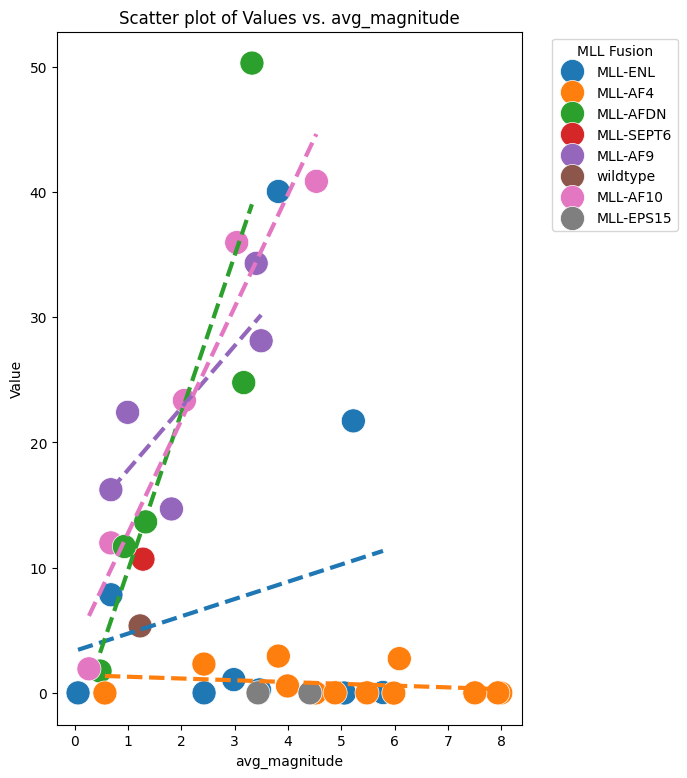

In [39]:
# Assuming the dataframes umap_df and OncoPeaks_WM_stat are already loaded

# Step 1: Create a dictionary to group 'avg_magnitude' by 'Cluster'
cluster_groups = umap_df.groupby('Cluster')['avg_magnitude'].apply(list).to_dict()

#MBNL1 = chr3:152170789-152420359
#MEIS1 = chr2:66408623-66599345
#JMJD1C = chr10:63337520-63637208
#MEF2C = chr5:88721596-88962685
#HOXA9 = chr7:27085104-27214094
#IRX1 = chr5:3591892-3610979
#FLT3 = chr13:28062154-28110626
#TAPT1 = chr4:16152184-16245766
#ZNF521 = chr18:25158848-25362589

# Step 2: Specify a row based on the index in OncoPeaks_WM_stat
index_to_select = 'chr18:25158848-25362589'  # replace with the actual index
selected_row = OncoPeaks_WM_stat.loc[index_to_select]

# Step 3: Pair the values from the selected row with 'avg_magnitude'
sample_values = {col: selected_row[col] for col in OncoPeaks_WM_stat.columns}

# Step 4: Create a new dataframe for plotting
plot_data = []

for cluster, magnitudes in cluster_groups.items():
    for magnitude in magnitudes:
        sample_name = umap_df.loc[umap_df['avg_magnitude'] == magnitude, 'Sample_Order'].values[0]
        if sample_name in sample_values:
            fusion_value = umap_df.loc[umap_df['Sample_Order'] == sample_name, 'MLL_Fusion'].values[0]
            plot_data.append({'avg_magnitude': magnitude, 'Value': sample_values[sample_name], 'Fusion': fusion_value})

plot_df = pd.DataFrame(plot_data)

# Define the specific order for the 'MLL_Fusion' categories
fusion_order = ['MLL-ENL', 'MLL-AF4', 'MLL-AFDN', 'MLL-SEPT6', 'MLL-AF9', 'wildtype', 'MLL-AF10', 'MLL-EPS15']

# Define the color palette for clusters in the specific order
custom_palette = sns.color_palette('tab10', len(fusion_order))

# Ensure 'Fusion' is of type string and in the specified order for the color palette to work
plot_df['Fusion'] = pd.Categorical(plot_df['Fusion'], categories=fusion_order, ordered=True)

# Create the scatter plot
plt.figure(figsize=(6, 9))
ax = sns.scatterplot(data=plot_df, x='avg_magnitude', y='Value', hue='Fusion', palette=custom_palette, s=300, edgecolor='w', linewidth=0.5)

# Loop through each unique hue and plot a regression line to the scatterplot based on the MLL_Fusion groupings, excluding "MLL-EPS15"
for fusion in plot_df['Fusion'].cat.categories:
    if fusion != "MLL-EPS15":
        fusion_data = plot_df[plot_df['Fusion'] == fusion]
        sns.regplot(
            data=fusion_data, x='avg_magnitude', y='Value', scatter=False, ci=None, 
            color=custom_palette[list(fusion_order).index(fusion)], 
            line_kws={'linestyle': '--', 'linewidth': 3}
        )

# Set plot title and labels as required
plt.title('Scatter plot of Values vs. avg_magnitude')
plt.xlabel('avg_magnitude')
plt.ylabel('Value')

# Move the legend off the plot
plt.legend(title='MLL Fusion', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot if needed
#plt.savefig('Figure_Panels/Fig_4B.png', dpi=300, bbox_inches='tight') #Modify for Fig_4C,F&I and Supplementary_Fig3E,F,G,H,L

# Show the plot
plt.show()


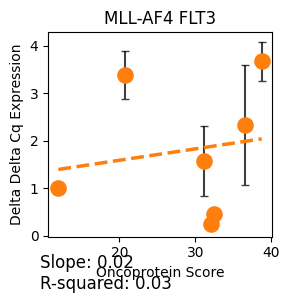

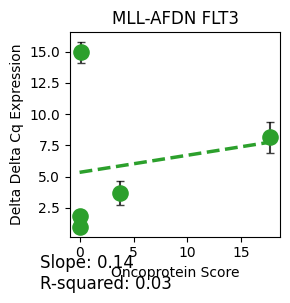

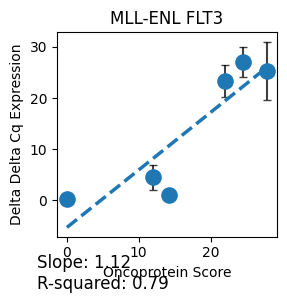

In [97]:
# Load the CSV file
X = pd.read_csv("FLT3_QPCR_Oncoprotein_Table_052924.csv", sep=',', index_col=0)

# Transpose the dataframe
X = X.transpose()

# Convert all values to numbers
X = X.apply(pd.to_numeric, errors='coerce')

# Rename the fourth column
new_column_name = 'Oncoprotein Score'
columns = X.columns.tolist()
columns[3] = new_column_name  # Change the fourth column title
X.columns = columns

# Drop rows where the value in the specified column is less than 1
column_to_check = 'Delta Delta Cq Expression'  # Specify the column to check
X = X[X[column_to_check] > 0]

# Define the rows to keep based on the index
AF4_Samples = ['A5', 'SEM', 'p247', 'RS411', 'p179', 'p318', 'p279', 'p454']
AFDN_Samples = ['A80956', 'A70498', 'A82485', 'A89691', 'ML2']
ENL_Samples = ['148752', '152985', 'p186', 'p160', 'p214', 'KOPN8']

# Check and keep only the existing specified rows
AF4_Samples_QPCR = X.loc[X.index.intersection(AF4_Samples)]
AFDN_Samples_QPCR = X.loc[X.index.intersection(AFDN_Samples)]
ENL_Samples_QPCR = X.loc[X.index.intersection(ENL_Samples)]

xcol = 'Oncoprotein Score'
ycol = 'Delta Delta Cq Expression'
yerr = 'Delta Delta Cq St. Deviation'

# Function to create the plot
def create_plot(data, title, color): #, filename
    slope, intercept, r_value, p_value, std_err = linregress(data[xcol], data[ycol])
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.errorbar(data[xcol], data[ycol], yerr=data[yerr].to_numpy(), fmt='none', ecolor='black', alpha=0.75, capsize=3, zorder=1)
    sns.regplot(data=data, x=xcol, y=ycol, scatter_kws={'s': 120, 'color': color, 'alpha': 1}, line_kws={'color': color, 'linestyle': '--', 'linewidth': 2.5}, ci=None, ax=ax)
    textstr = f'Slope: {slope:.2f}\nR-squared: {r_value**2:.2f}'
    plt.gcf().text(0.15, 0.02, textstr, fontsize=12)
    plt.xlabel('Oncoprotein Score')
    plt.ylabel('Delta Delta Cq Expression')
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(filename)
    plt.show()

# Plot for AF4
create_plot(AF4_Samples_QPCR, 'MLL-AF4 FLT3', sns.color_palette()[1], )#'Figure_Panels/Fig_4D.png')

# Plot for AFDN
create_plot(AFDN_Samples_QPCR, 'MLL-AFDN FLT3', sns.color_palette()[2],) #'Figure_Panels/Fig_4D.png')

# Plot for ENL
create_plot(ENL_Samples_QPCR, 'MLL-ENL FLT3', sns.color_palette()[0],) #'Figure_Panels/Fig_4D.png')


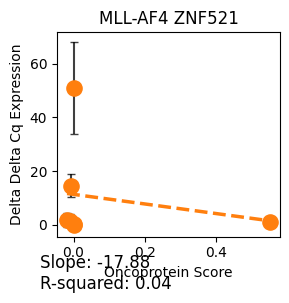

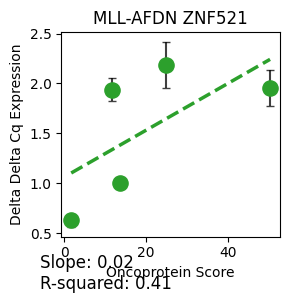

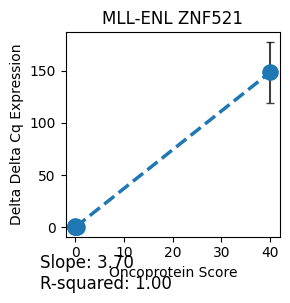

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the CSV file
X = pd.read_csv("ZNF521_QPCR_Oncoprotein_Table_052924.csv", sep=',', index_col=0)

# Transpose the dataframe
X = X.transpose()

# Convert all values to numbers
X = X.apply(pd.to_numeric, errors='coerce')

# Rename the fourth column
new_column_name = 'Oncoprotein Score'
columns = X.columns.tolist()
columns[3] = new_column_name  # Change the fourth column title
X.columns = columns

# Drop rows where the value in the specified column is less than 1
column_to_check = 'Delta Delta Cq Expression'  # Specify the column to check
X = X[X[column_to_check] > 0]

# Define the rows to keep based on the index
AF4_Samples = ['A5', 'SEM', 'p247', 'RS411', 'p179', 'p318', 'p279', 'p454']
AFDN_Samples = ['A80956', 'A70498', 'A82485', 'A89691', 'ML2']
ENL_Samples = ['148752', '152985', 'p186', 'p160', 'p214', 'KOPN8']

# Check and keep only the existing specified rows
AF4_Samples_QPCR = X.loc[X.index.intersection(AF4_Samples)]
AFDN_Samples_QPCR = X.loc[X.index.intersection(AFDN_Samples)]
ENL_Samples_QPCR = X.loc[X.index.intersection(ENL_Samples)]

xcol = 'Oncoprotein Score'
ycol = 'Delta Delta Cq Expression'
yerr = 'Delta Delta Cq St. Deviation'

# Function to create the plot
def create_plot(data, title, color): #, filename
    slope, intercept, r_value, p_value, std_err = linregress(data[xcol], data[ycol])
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.errorbar(data[xcol], data[ycol], yerr=data[yerr].to_numpy(), fmt='none', ecolor='black', alpha=0.75, capsize=3, zorder=1)
    sns.regplot(data=data, x=xcol, y=ycol, scatter_kws={'s': 120, 'color': color, 'alpha': 1}, line_kws={'color': color, 'linestyle': '--', 'linewidth': 2.5}, ci=None, ax=ax)
    textstr = f'Slope: {slope:.2f}\nR-squared: {r_value**2:.2f}'
    plt.gcf().text(0.15, 0.02, textstr, fontsize=12)
    plt.xlabel('Oncoprotein Score')
    plt.ylabel('Delta Delta Cq Expression')
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(filename)
    plt.show()

# Plot for AF4
create_plot(AF4_Samples_QPCR, 'MLL-AF4 ZNF521', sns.color_palette()[1], )#'Figure_Panels/Fig_4G.png')

# Plot for AFDN
create_plot(AFDN_Samples_QPCR, 'MLL-AFDN ZNF521', sns.color_palette()[2],) #'Figure_Panels/Fig_4G.png')

# Plot for ENL
create_plot(ENL_Samples_QPCR, 'MLL-ENL ZNF521', sns.color_palette()[0],) #'Figure_Panels/Fig_4G.png')


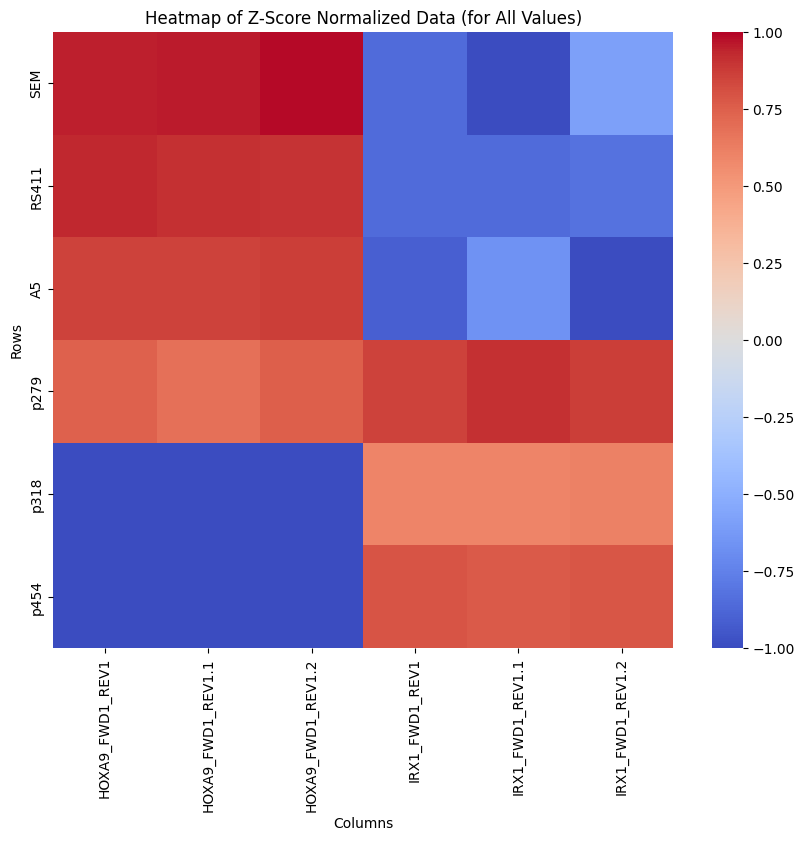

In [56]:
MLL_AF4_HOXA9_IRX1_CT = pd.read_csv("MLL_AF4_HOXA9_IRX1_CT.csv", sep=',', index_col=0)

# Remove empty columns
MLL_AF4_HOXA9_IRX1_CT = MLL_AF4_HOXA9_IRX1_CT.dropna(axis=1, how='all')


MLL_AF4_HOXA9_IRX1_CT = MLL_AF4_HOXA9_IRX1_CT.transpose()

# Replace 'Undetermined' with 40 and 'Blank' with NaN
MLL_AF4_HOXA9_IRX1_CT = MLL_AF4_HOXA9_IRX1_CT.replace({'Undetermined': 40, 'Blank': np.nan})

# Convert all values in the dataframe to numbers
MLL_AF4_HOXA9_IRX1_CT = MLL_AF4_HOXA9_IRX1_CT.apply(pd.to_numeric, errors='coerce')

MLL_AF4_HOXA9_IRX1_CT [MLL_AF4_HOXA9_IRX1_CT  < 15] = np.nan

## HEATMAP SCALED BY Z-SCORE NORMALIZATION FOR ALL VALUES ##

# Assuming the dataframe is already loaded into KMT2A_AFDN_Fusion_Junction_QPCR
df = MLL_AF4_HOXA9_IRX1_CT

# Replace 'Undetermined' with 40 and 'Blank' with NaN
df = df.replace({'Undetermined': 40, 'Blank': np.nan})

# Flatten the dataframe, calculate z-scores, and reshape it back
df_flattened = df.values.flatten()
df_zscored = zscore(df_flattened, nan_policy='omit')
df_normalized = pd.DataFrame(df_zscored.reshape(df.shape), index=df.index, columns=df.columns)

# Define the desired column order as a list
desired_order = ['SEM', 'RS411', 'A5', 'p279', 'p318', 'p454']  # Replace with your actual column names

# Ensure all columns in the list are present in the dataframe
desired_order = [col for col in desired_order if col in df_normalized.columns]

# Reorder the columns based on the specified list
df_normalized = df_normalized[desired_order]

# Transpose the dataframe
df_normalized = df_normalized.transpose()

# Multiply all values in df_normalized by -1
df_normalized = df_normalized * -1

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_normalized, cmap='coolwarm', annot=False, cbar=True, vmin=-1, vmax=1)  # Set annot to False to remove number overlays
plt.title('Heatmap of Z-Score Normalized Data (for All Values)')
plt.xlabel('Columns')
plt.ylabel('Rows')
#plt.savefig('Figure_Panels/Fig_4J.png')
plt.show()


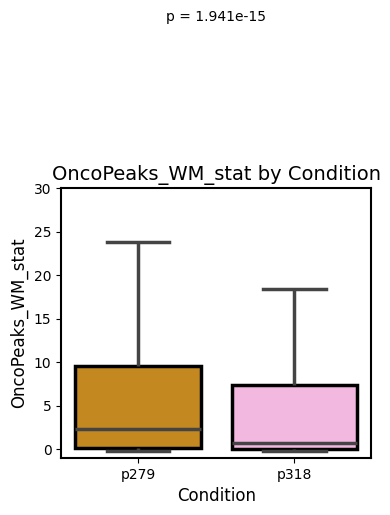

In [8]:
# Assuming OncoPeaks_WM_stat is your DataFrame

# Select only the columns 'p279' and 'p318'
selected_data = OncoPeaks_WM_stat[['p279', 'p318']]

# Melt the data for seaborn boxplot
melted_data = selected_data.melt(var_name='Condition', value_name='Log2 Ratio Mean')

# Use the colorblind palette for colors
all_colors = sns.color_palette("colorblind")
colorblind_2 = [all_colors[1], all_colors[6]]

# Adjust the figure size as needed
plt.figure(figsize=(4, 3.5))

# Plotting with seaborn using the colorblind palette
ax = sns.boxplot(x='Condition', y='Log2 Ratio Mean', data=melted_data, hue='Condition', palette=colorblind_2, showfliers=False, linewidth=2.5, boxprops=dict(edgecolor="black"), legend=False)
#sns.stripplot(x='Condition', y='Log2 Ratio Mean', data=melted_data, color='black', alpha=0.6, jitter=True)
#ax.set_ylim(melted_data['Log2 Ratio Mean'].min()-1, melted_data['Log2 Ratio Mean'].max()+1)  # Adjust the range based on the actual data
ax.set_ylim(-1, 30)  # Adjust the range based on the actual data

# Perform the Wilcoxon signed-rank test
stat, p_value = wilcoxon(selected_data['p279'], selected_data['p318'])

# Add statistical annotation manually
x1, x2 = 0, 1
y, h, col = melted_data['Log2 Ratio Mean'].max() + 1, 1, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, f'p = {p_value:.3e}', ha='center', va='bottom', color=col)

# Increase the linewidth of the plot borders for aesthetics
for _, spine in ax.spines.items():
    spine.set_linewidth(1.5)

# Label the axes and set a title
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('OncoPeaks_WM_stat', fontsize=12)
ax.set_title('OncoPeaks_WM_stat by Condition', fontsize=14)

# Optionally, you can save the plot if needed
#plt.savefig('Figure_Panels/Fig_5A.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


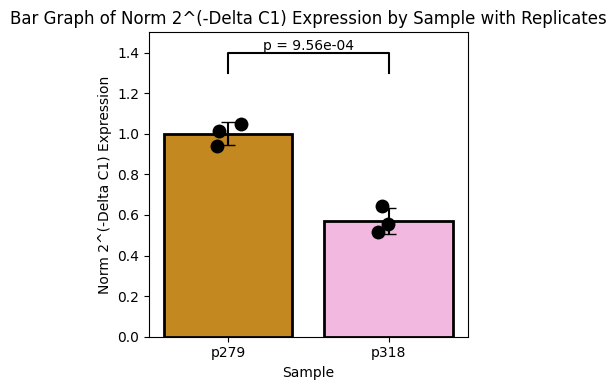

In [62]:
# Load the data
Oncogene_Oncoprotein_QPCR = pd.read_csv("QPCR_Oncogene_Oncoprotein_Replicates.csv", sep=',', index_col=0)

# Transpose the DataFrame
df = Oncogene_Oncoprotein_QPCR.transpose()

# Convert necessary columns to numeric
df['Norm 2^(-Delta C1) Rep1'] = pd.to_numeric(df['Norm 2^(-Delta C1) Rep1'], errors='coerce')
df['Norm 2^(-Delta C1) Rep2'] = pd.to_numeric(df['Norm 2^(-Delta C1) Rep2'], errors='coerce')
df['Norm 2^(-Delta C1) Rep3'] = pd.to_numeric(df['Norm 2^(-Delta C1) Rep3'], errors='coerce')

# Step 1: Filter rows and create a copy
df_filtered = df.loc[df.index.isin(['p279', 'p318'])].copy()

# Reorder the rows to ensure p279 comes first
df_filtered = df_filtered.loc[['p279', 'p318']]

# Drop columns with any NaN values
df_filtered = df_filtered.dropna(axis=1)

# Reset the index to bring 'Sample' back as a column
df_filtered = df_filtered.reset_index()

# Rename columns to match the variables
df_filtered.columns = ['Sample', 'Primer', 'Norm 2^(-Delta C1) Rep1', 'Norm 2^(-Delta C1) Rep2', 'Norm 2^(-Delta C1) Rep3', 
                       'Delta Delta Cq Expression', 'Delta Delta Cq St. Deviation', 'Oncoprotein Score', 'Target Norm Oncoprotein Score']

# Melt the dataframe to have replicates as rows
df_melted = pd.melt(df_filtered, id_vars=['Sample'], 
                    value_vars=['Norm 2^(-Delta C1) Rep1', 'Norm 2^(-Delta C1) Rep2', 'Norm 2^(-Delta C1) Rep3'],
                    var_name='Replicate', value_name='Expression')

# Calculate means and standard deviations based on individual replicates
df_means = df_melted.groupby('Sample')['Expression'].mean().reset_index()
df_std = df_melted.groupby('Sample')['Expression'].std().reset_index()

# Perform t-test between p279 and p318 based on replicate values
p279_values = df_melted[df_melted['Sample'] == 'p279']['Expression']
p318_values = df_melted[df_melted['Sample'] == 'p318']['Expression']

# Perform t-test using individual replicate values
t_stat, p_val = ttest_ind(p279_values, p318_values)

# Set the colors for the bars
all_colors = sns.color_palette("colorblind")
colorblind_2 = [all_colors[1], all_colors[6]]  # Colors for p279 and p318
custom_palette = sns.color_palette(colorblind_2)

# Create the bar graph with error bars
plt.figure(figsize=(4, 4))
barplot = sns.barplot(
    data=df_means, 
    x='Sample', 
    y='Expression', 
    hue='Sample',  # Assign x variable to hue
    palette=custom_palette, 
    edgecolor='black', 
    linewidth=2, 
    capsize=0.1,
    err_kws={'linewidth': 1.5},  # Replace errwidth with err_kws
    legend=False  # Suppress the legend
)

# Add error bars manually based on std deviation
for i, sample in enumerate(['p279', 'p318']):
    mean_val = df_means[df_means['Sample'] == sample]['Expression'].values[0]
    std_val = df_std[df_std['Sample'] == sample]['Expression'].values[0]
    plt.errorbar(i, mean_val, yerr=std_val, fmt='none', ecolor='black', capsize=5)

# Overlay individual replicates as large black dots in a strip plot
sns.stripplot(
    data=df_melted, 
    x='Sample', 
    y='Expression', 
    hue=None,  # Don't assign hue, just plot the dots
    color='black', 
    size=10, 
    jitter=True  # Slightly offset the dots to avoid overlap
)

# Add p-value above the bars
x1, x2 = 0, 1
y, h, col = df_means['Expression'].max() + 0.3, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5, y + h, f"p = {p_val:.2e}", ha='center', va='bottom', color=col)

# Customize the plot
plt.ylim(0, 1.5)
plt.xlabel('Sample')
plt.ylabel('Norm 2^(-Delta C1) Expression')
plt.title('Bar Graph of Norm 2^(-Delta C1) Expression by Sample with Replicates')
plt.tight_layout()

# Save the plot
#plt.savefig('Figure_Panels/Fig_5B.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


/tmp/ipykernel_32897/779483681.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(


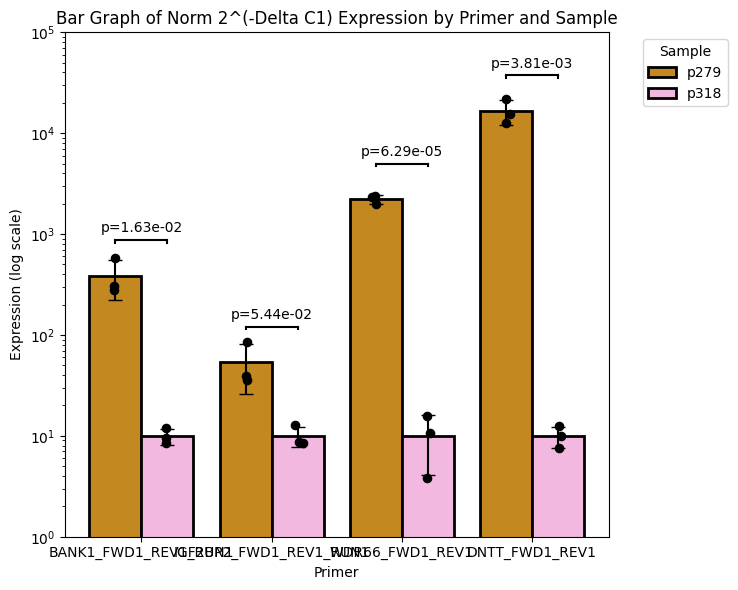

In [76]:
# Load the CSV file
X = pd.read_csv("p318_p279_QPCR_Oncoprotein_Replicates.csv", sep=',', index_col=0, header=None)

# Transpose the dataframe
X = X.transpose()
X = X.dropna(axis=0, how='all')

# List of columns to be converted to numeric
columns_to_convert = ['Norm 2^(-Delta C1) Rep1', 'Norm 2^(-Delta C1) Rep2', 'Norm 2^(-Delta C1) Rep3']

# Apply pd.to_numeric to specific columns if they exist
for col in columns_to_convert:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop rows with all NaN values
X = X.dropna(axis=0, how='all')

# Multiply all relevant values by 10 to adjust for log scale visualization
X[columns_to_convert] *= 10

# Filter rows based on 'Primer' column (assuming 'Primer' column contains strings to filter by)
primers_to_keep = ['BANK1_FWD1_REV1_RUN1', 'IGF2BP2_FWD1_REV1_RUN1', 'WDR66_FWD1_REV1', 'DNTT_FWD1_REV1']  # Replace with actual Primer values you want to keep

# Filter rows based on the specified 'Primer' values
X_BALL = X[X['Primer'].isin(primers_to_keep)].copy()

# Set the order of the 'Primer' column
X_BALL['Primer'] = pd.Categorical(X_BALL['Primer'], categories=primers_to_keep, ordered=True)

# Reorder the rows within each primer set
X_BALL['Sample'] = pd.Categorical(X_BALL['Sample'], categories=['p279', 'p318'], ordered=True)
X_BALL = X_BALL.sort_values(['Primer', 'Sample'])

# Melt the dataframe to have replicates as rows
df_melted = pd.melt(X_BALL, id_vars=['Sample', 'Primer'], 
                    value_vars=columns_to_convert,
                    var_name='Replicate', value_name='Expression')

# Calculate means and standard deviations based on individual replicates
df_means = df_melted.groupby(['Sample', 'Primer'])['Expression'].mean().reset_index()
df_std = df_melted.groupby(['Sample', 'Primer'])['Expression'].std().reset_index()

# Perform t-test between p279 and p318 based on replicate values for each primer group
p_values = []
for primer in primers_to_keep:
    group = df_melted[df_melted['Primer'] == primer]
    p279_values = group[group['Sample'] == 'p279']['Expression']
    p318_values = group[group['Sample'] == 'p318']['Expression']

    # Perform t-test using individual replicate values
    t_stat, p_val = ttest_ind(p279_values, p318_values)
    p_values.append((primer, p_val))

# Set the colors for the bars
all_colors = sns.color_palette("colorblind")
colorblind_2 = [all_colors[1], all_colors[6]]  # Colors for p279 and p318
custom_palette = sns.color_palette(colorblind_2)

# Create the bar graph with error bars
plt.figure(figsize=(7.5, 6))
barplot = sns.barplot(
    data=df_means, 
    x='Primer', 
    y='Expression', 
    hue='Sample', 
    palette=custom_palette, 
    edgecolor='black', 
    linewidth=2, 
    capsize=0.1,
    ci=None  # Disable default confidence intervals
)

# Adjust the x positions of the bars and error bars
bar_width = barplot.patches[0].get_width()  # Width of a single bar
grouped_bars = len(['p279', 'p318'])  # Number of bars per group (Primer)

# Add error bars manually by iterating through both Primer and Sample
for i, primer in enumerate(primers_to_keep):
    for j, sample in enumerate(['p279', 'p318']):
        # Extract the row matching the current Primer and Sample
        row = df_means[(df_means['Primer'] == primer) & (df_means['Sample'] == sample)]
        std_val = df_std[(df_std['Primer'] == primer) & (df_std['Sample'] == sample)]['Expression'].values[0]
        
        if not row.empty:
            # Extract mean height
            height = row['Expression'].values[0]
            
            # Calculate x position for each bar in the group
            bar_x = i + (j - (grouped_bars - 1) / 2) * bar_width

            # Add the error bar
            plt.errorbar(bar_x, height, yerr=std_val, fmt='none', ecolor='black', capsize=5)

            # Plot individual black dots for replicates, offset by the same bar_x logic
            replicate_values = df_melted[(df_melted['Primer'] == primer) & (df_melted['Sample'] == sample)]['Expression']
            jittered_x = np.random.normal(loc=bar_x, scale=0.02, size=len(replicate_values))  # Slight jitter for replicates
            plt.scatter(jittered_x, replicate_values, color='black', s=35, zorder=3)  # s=100 for large black dots

# Add p-values above the bars with brackets, raised higher on the y-axis
for i, (primer, p_val) in enumerate(p_values):
    x = i
    y = df_means[df_means['Primer'] == primer]['Expression'].max() * 2.5  # Raised higher
    plt.text(x, y, f'p={p_val:.2e}', ha='center', va='bottom', fontsize=10)
    plt.plot([x-0.2, x+0.2], [y*0.9, y*0.9], color='black', linewidth=1.5)
    plt.plot([x-0.2, x-0.2], [y*0.85, y*0.9], color='black', linewidth=1.5)
    plt.plot([x+0.2, x+0.2], [y*0.85, y*0.9], color='black', linewidth=1.5)

# Set the y-axis to a log scale and adjust the limit
plt.yscale('log')
plt.ylim(1, 10**5)

plt.xlabel('Primer')
plt.ylabel('Expression (log scale)')
plt.title('Bar Graph of Norm 2^(-Delta C1) Expression by Primer and Sample')
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
#plt.savefig('Figure_Panels/Fig_5D.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


/tmp/ipykernel_32897/1623463239.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(


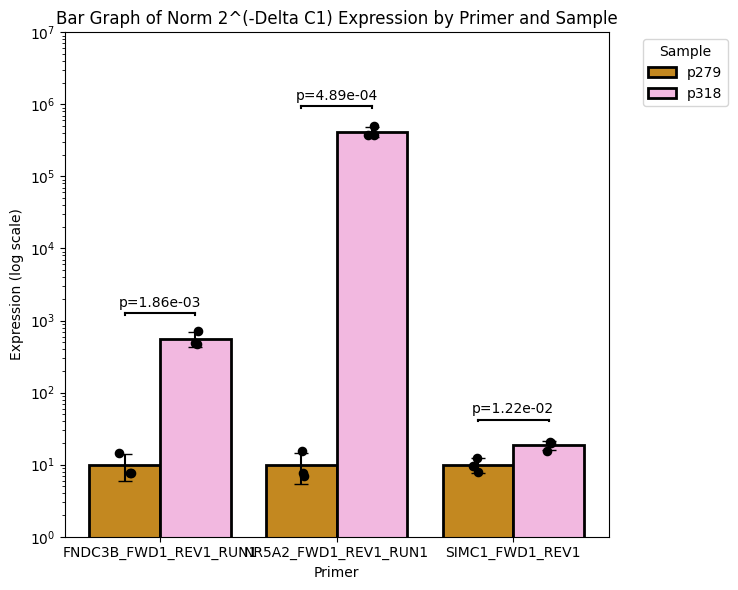

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load the CSV file
X = pd.read_csv("p318_p279_QPCR_Oncoprotein_Replicates.csv", sep=',', index_col=0, header=None)

# Transpose the dataframe
X = X.transpose()
X = X.dropna(axis=0, how='all')

# List of columns to be converted to numeric
columns_to_convert = ['Norm 2^(-Delta C1) Rep1', 'Norm 2^(-Delta C1) Rep2', 'Norm 2^(-Delta C1) Rep3']

# Apply pd.to_numeric to specific columns if they exist
for col in columns_to_convert:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop rows with all NaN values
X = X.dropna(axis=0, how='all')

# Multiply all relevant values by 10 to adjust for log scale visualization
X[columns_to_convert] *= 10

# Filter rows based on 'Primer' column (assuming 'Primer' column contains strings to filter by)
primers_to_keep = ['FNDC3B_FWD1_REV1_RUN1', 'NR5A2_FWD1_REV1_RUN1', 'SIMC1_FWD1_REV1']  # Replace with actual Primer values you want to keep

# Filter rows based on the specified 'Primer' values
X_BALL = X[X['Primer'].isin(primers_to_keep)].copy()

# Set the order of the 'Primer' column
X_BALL['Primer'] = pd.Categorical(X_BALL['Primer'], categories=primers_to_keep, ordered=True)

# Reorder the rows within each primer set
X_BALL['Sample'] = pd.Categorical(X_BALL['Sample'], categories=['p279', 'p318'], ordered=True)
X_BALL = X_BALL.sort_values(['Primer', 'Sample'])

# Melt the dataframe to have replicates as rows
df_melted = pd.melt(X_BALL, id_vars=['Sample', 'Primer'], 
                    value_vars=columns_to_convert,
                    var_name='Replicate', value_name='Expression')

# Calculate means and standard deviations based on individual replicates
df_means = df_melted.groupby(['Sample', 'Primer'])['Expression'].mean().reset_index()
df_std = df_melted.groupby(['Sample', 'Primer'])['Expression'].std().reset_index()

# Perform t-test between p279 and p318 based on replicate values for each primer group
p_values = []
for primer in primers_to_keep:
    group = df_melted[df_melted['Primer'] == primer]
    p279_values = group[group['Sample'] == 'p279']['Expression']
    p318_values = group[group['Sample'] == 'p318']['Expression']

    # Perform t-test using individual replicate values
    t_stat, p_val = ttest_ind(p279_values, p318_values)
    p_values.append((primer, p_val))

# Set the colors for the bars
all_colors = sns.color_palette("colorblind")
colorblind_2 = [all_colors[1], all_colors[6]]  # Colors for p279 and p318
custom_palette = sns.color_palette(colorblind_2)

# Create the bar graph with error bars
plt.figure(figsize=(7.5, 6))
barplot = sns.barplot(
    data=df_means, 
    x='Primer', 
    y='Expression', 
    hue='Sample', 
    palette=custom_palette, 
    edgecolor='black', 
    linewidth=2, 
    capsize=0.1,
    ci=None  # Disable default confidence intervals
)

# Adjust the x positions of the bars and error bars
bar_width = barplot.patches[0].get_width()  # Width of a single bar
grouped_bars = len(['p279', 'p318'])  # Number of bars per group (Primer)

# Add error bars manually by iterating through both Primer and Sample
for i, primer in enumerate(primers_to_keep):
    for j, sample in enumerate(['p279', 'p318']):
        # Extract the row matching the current Primer and Sample
        row = df_means[(df_means['Primer'] == primer) & (df_means['Sample'] == sample)]
        std_val = df_std[(df_std['Primer'] == primer) & (df_std['Sample'] == sample)]['Expression'].values[0]
        
        if not row.empty:
            # Extract mean height
            height = row['Expression'].values[0]
            
            # Calculate x position for each bar in the group
            bar_x = i + (j - (grouped_bars - 1) / 2) * bar_width

            # Add the error bar
            plt.errorbar(bar_x, height, yerr=std_val, fmt='none', ecolor='black', capsize=5)

            # Plot individual black dots for replicates, offset by the same bar_x logic
            replicate_values = df_melted[(df_melted['Primer'] == primer) & (df_melted['Sample'] == sample)]['Expression']
            jittered_x = np.random.normal(loc=bar_x, scale=0.02, size=len(replicate_values))  # Slight jitter for replicates
            plt.scatter(jittered_x, replicate_values, color='black', s=35, zorder=3)  # s=100 for large black dots

# Add p-values above the bars with brackets, raised higher on the y-axis
for i, (primer, p_val) in enumerate(p_values):
    x = i
    y = df_means[df_means['Primer'] == primer]['Expression'].max() * 2.5  # Raised higher
    plt.text(x, y, f'p={p_val:.2e}', ha='center', va='bottom', fontsize=10)
    plt.plot([x-0.2, x+0.2], [y*0.9, y*0.9], color='black', linewidth=1.5)
    plt.plot([x-0.2, x-0.2], [y*0.85, y*0.9], color='black', linewidth=1.5)
    plt.plot([x+0.2, x+0.2], [y*0.85, y*0.9], color='black', linewidth=1.5)

# Set the y-axis to a log scale and adjust the limit
plt.yscale('log')
plt.ylim(1, 10**7)

plt.xlabel('Primer')
plt.ylabel('Expression (log scale)')
plt.title('Bar Graph of Norm 2^(-Delta C1) Expression by Primer and Sample')
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
#plt.savefig('Figure_Panels/Fig_5F.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
## This Series of COde Creates the Sample Specific Oncoprotien Target Gene Lists and requres the combined bed files as input ##
## You can also skip ahead and load the oncoprotein target gene lists. 

Sample_bed = ['DJ_Hs_p160_KMT2A_Cterm_230613.bed']
bed2 = 'DJ_Hs_p160_KMT2A_Nterm_230613.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    p160_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['KMT2Ar_CnR_230626_V2/DJ_Hs_p179_KMT2A_Cterm_230613.bed']
bed2 = 'KMT2Ar_CnR_230626_V2/DJ_Hs_p179_KMT2A_Nterm_230613.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    p179_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_p186_KMT2A_Cterm_230613.bed']
bed2 = 'DJ_Hs_p186_KMT2A_Nterm_230613.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    p186_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_p214_KMT2A_Cterm_230613.bed']
bed2 = 'DJ_Hs_p214_KMT2A_Nterm_230613.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    p214_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_p247_KMT2A_Cterm_230613.bed']
bed2 = 'DJ_Hs_p247_KMT2A_Nterm_230613.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    p247_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_p279_KMT2A_Cterm_230613.bed']
bed2 = 'DJ_Hs_p279_KMT2A_Nterm_230613.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    p279_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_p318_KMT2A_Cterm_230613.bed']
bed2 = 'DJ_Hs_p318_KMT2A_Nterm_230613.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    p318_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_p454_KMT2A_Cterm_230613.bed']
bed2 = 'DJ_Hs_p454_KMT2A_Nterm_230613.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    p454_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)


Sample_bed = ['DJ_Hs_KOPN8_KMT2A_Cterm_200331.bed']
bed2 = 'DJ_Hs_KOPN8_KMT2A_Nterm_200331.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    KOPN8_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_SEM_KMT2A_Cterm_200331.bed']
bed2 = 'DJ_Hs_SEM_KMT2A_Nterm_200331.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    SEM_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_RS411_KMT2A_Cterm_200331.bed']
bed2 = 'DJ_Hs_RS411_KMT2A_Nterm_200331.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    RS411_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_ML2_KMT2A_Cterm_200331.bed']
bed2 = 'DJ_Hs_ML2_KMT2A_Nterm_200331.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    ML2_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_A4_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_A4_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A4_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_A5_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_A5_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A5_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_A6_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_A6_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A6_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_TB11_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_TB11_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    TB11_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_TB13_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_TB13_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    TB13_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_MLL_Cterm_CD34_1208.bed']
bed2 = 'DJ_Hs_MLL_Nterm_CD34_1208.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    CD34_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_MLL_Cterm_A109C_1208.bed']
bed2 = 'DJ_Hs_MLL_Nterm_A109C_1208.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A109_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_MLL_Cterm_A384C_1208.bed']
bed2 = 'DJ_Hs_MLL_Nterm_A384C_1208.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A384_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_MLL_Cterm_A107C_1208.bed']
bed2 = 'DJ_Hs_MLL_Nterm_A107C_1208.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A107_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_TB000694_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_TB000694_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    TB000694_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_TB051939_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_TB051939_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    TB051939_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_TB920488_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_TB920488_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    TB920488_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)


Sample_bed = ['DJ_Hs_TB971992_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_TB971992_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    TB971992_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_TB040576_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_TB040576_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    TB040576_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_TB995291_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_TB995291_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    TB995291_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_TB986292_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_TB986292_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    TB986292_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)


Sample_bed = ['DJ_Hs_A93949_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_A93949_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A93949_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_A95941_KMT2A_Cterm_200504.bed']
bed2 = 'DJ_Hs_A95941_KMT2A_Nterm_200504.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A95941_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_A70498_KMT2A_Cterm_221101.bed']
bed2 = 'DJ_Hs_A70498_KMT2A_Nterm_221101.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A70498_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_A93692_KMT2A_Cterm_221101.bed']
bed2 = 'DJ_Hs_A93692_KMT2A_Nterm_221101.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A93692_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_A89691_KMT2A_Cterm_221101.bed']
bed2 = 'DJ_Hs_A89691_KMT2A_Nterm_221101.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A89691_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_A82485_KMT2A_Cterm_221101.bed']
bed2 = 'DJ_Hs_A82485_KMT2A_Nterm_221101.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A82485_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_A73051_KMT2A_Cterm_221101.bed']
bed2 = 'DJ_Hs_A73051_KMT2A_Nterm_221101.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A73051_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_A80956_KMT2A_Cterm_221101.bed']
bed2 = 'DJ_Hs_A80956_KMT2A_Nterm_221101.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    A80956_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_5395_KMT2A_Cterm_05T_040324.bed']
bed2 = 'DJ_Hs_5395_KMT2A_Nterm_05T_040324.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    R5395_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)


Sample_bed = ['DJ_Hs_5652_KMT2A_Cterm_05T_040324.bed']
bed2 = 'DJ_Hs_5652_KMT2A_Nterm_05T_040324.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    R5652_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_148752_500K_KMT2A_Cterm_240416.bed']
bed2 = 'DJ_Hs_148752_500K_KMT2A_Nterm_240416.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    TC148752_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)

Sample_bed = ['DJ_Hs_152985_500K_KMT2A_Cterm_240416.bed']
bed2 = 'DJ_Hs_152985_500K_KMT2A_Nterm_240416.bed'
peakfile = 'MLLr_MasterPeaks_AllData_Revision_noIgG.bed'

for bed in Sample_bed:
    TC152985_NC_Score = Count_N_C(bed, bed2, peakfile, log_fold_change_cutoff=1.75, pval_cutoff=1e-05)


In [ ]:
# List of dataframes
dataframes = [
    p160_NC_Score, p179_NC_Score, p186_NC_Score, p214_NC_Score,
    p247_NC_Score, p279_NC_Score, p318_NC_Score, p454_NC_Score,
    KOPN8_NC_Score, SEM_NC_Score, RS411_NC_Score, ML2_NC_Score,
    A4_NC_Score, A5_NC_Score, A6_NC_Score, TB11_NC_Score,
    TB13_NC_Score, CD34_NC_Score, A109_NC_Score, A384_NC_Score,
    A107_NC_Score, TB000694_NC_Score, TB051939_NC_Score, TB920488_NC_Score,
    TB971992_NC_Score, TB040576_NC_Score, TB995291_NC_Score, TB986292_NC_Score,
    A93949_NC_Score, A95941_NC_Score, A70498_NC_Score, A93692_NC_Score,
    A89691_NC_Score, A82485_NC_Score, A73051_NC_Score, A80956_NC_Score,
    R5395_NC_Score, R5652_NC_Score, TC148752_NC_Score, TC152985_NC_Score
]

def add_weighted_magnitude(dataframes):
    epsilon = 1e-10
    for df in dataframes:
        df['Weighted_Magnitude'] = df['log2_ratio_mean'] * -np.log10(df['log2_ratio_pvalue'] + epsilon)
    return dataframes

# Apply the function to add the 'Weighted_Magnitude' column to each dataframe
dataframes = add_weighted_magnitude(dataframes)

# Now dataframes list contains the updated dataframes with 'Weighted_Magnitude' column

In [ ]:
#p160_NC_Score.to_csv('p160_NC_Score.csv', index=True)
#p179_NC_Score.to_csv('p179_NC_Score.csv', index=True)
#p186_NC_Score.to_csv('p186_NC_Score.csv', index=True)
#p214_NC_Score.to_csv('p214_NC_Score.csv', index=True)

#p247_NC_Score.to_csv('p247_NC_Score.csv', index=True)
#p279_NC_Score.to_csv('p279_NC_Score.csv', index=True)
#p318_NC_Score.to_csv('p318_NC_Score.csv', index=True)
#p454_NC_Score.to_csv('p454_NC_Score.csv', index=True)

#KOPN8_NC_Score.to_csv('KOPN8_NC_Score.csv', index=True)
#SEM_NC_Score.to_csv('SEM_NC_Score.csv', index=True)
#RS411_NC_Score.to_csv('RS411_NC_Score.csv', index=True)
#ML2_NC_Score.to_csv('ML2_NC_Score.csv', index=True)

#A4_NC_Score.to_csv('A4_NC_Score.csv', index=True)
#A5_NC_Score.to_csv('A5_NC_Score.csv', index=True)
#A6_NC_Score.to_csv('A6_NC_Score.csv', index=True)
#TB11_NC_Score.to_csv('TB11_NC_Score.csv', index=True)

#TB13_NC_Score.to_csv('TB13_NC_Score.csv', index=True)
#CD34_NC_Score.to_csv('CD34_NC_Score.csv', index=True)
#A109_NC_Score.to_csv('A109_NC_Score.csv', index=True)
#A384_NC_Score.to_csv('A384_NC_Score.csv', index=True)

#A107_NC_Score.to_csv('A107_NC_Score.csv', index=True)
#TB000694_NC_Score.to_csv('TB000694_NC_Score.csv', index=True)
#TB051939_NC_Score.to_csv('TB051939_NC_Score.csv', index=True)
#TB920488_NC_Score.to_csv('TB920488_NC_Score.csv', index=True)

#TB971992_NC_Score.to_csv('TB971992_NC_Score.csv', index=True)
#TB040576_NC_Score.to_csv('TB040576_NC_Score.csv', index=True)
#TB995291_NC_Score.to_csv('TB995291_NC_Score.csv', index=True)
#TB986292_NC_Score.to_csv('TB986292_NC_Score.csv', index=True)

#A93949_NC_Score.to_csv('A93949_NC_Score.csv', index=True)
#A95941_NC_Score.to_csv('A95941_NC_Score.csv', index=True)
#A70498_NC_Score.to_csv('A70498_NC_Score.csv', index=True)
#A93692_NC_Score.to_csv('A93692_NC_Score.csv', index=True)

#A89691_NC_Score.to_csv('A89691_NC_Score.csv', index=True)
#A82485_NC_Score.to_csv('A82485_NC_Score.csv', index=True)
#A73051_NC_Score.to_csv('A73051_NC_Score.csv', index=True)
#A80956_NC_Score.to_csv('A80956_NC_Score.csv', index=True)

#R5395_NC_Score.to_csv('R5395_NC_Score.csv', index=True)
#R5652_NC_Score.to_csv('R5652_NC_Score.csv', index=True)
#TC148752_NC_Score.to_csv('TC148752_NC_Score.csv', index=True)
#TC152985_NC_Score.to_csv('TC152985_NC_Score.csv', index=True)

In [119]:
p160_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/p160_NC_Score.csv', sep=',', index_col=0)
p179_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/p179_NC_Score.csv', sep=',', index_col=0)
p186_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/p186_NC_Score.csv', sep=',', index_col=0)
p214_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/p214_NC_Score.csv', sep=',', index_col=0)

p247_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/p247_NC_Score.csv', sep=',', index_col=0)
p279_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/p279_NC_Score.csv', sep=',', index_col=0)
p318_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/p318_NC_Score.csv', sep=',', index_col=0)
p454_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/p454_NC_Score.csv', sep=',', index_col=0)

KOPN8_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/KOPN8_NC_Score.csv', sep=',', index_col=0)
SEM_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/SEM_NC_Score.csv', sep=',', index_col=0)
RS411_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/RS411_NC_Score.csv', sep=',', index_col=0)
ML2_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/ML2_NC_Score.csv', sep=',', index_col=0)

A4_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A4_NC_Score.csv', sep=',', index_col=0)
A5_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A5_NC_Score.csv', sep=',', index_col=0)
A6_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A6_NC_Score.csv', sep=',', index_col=0)
TB11_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/TB11_NC_Score.csv', sep=',', index_col=0)

TB13_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/TB13_NC_Score.csv', sep=',', index_col=0)
CD34_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/CD34_NC_Score.csv', sep=',', index_col=0)
A109_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A109_NC_Score.csv', sep=',', index_col=0)
A384_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A384_NC_Score.csv', sep=',', index_col=0)

A107_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A107_NC_Score.csv', sep=',', index_col=0)
TB000694_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/TB000694_NC_Score.csv', sep=',', index_col=0)
TB051939_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/TB051939_NC_Score.csv', sep=',', index_col=0)
TB920488_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/TB920488_NC_Score.csv', sep=',', index_col=0)

TB971992_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/TB971992_NC_Score.csv', sep=',', index_col=0)
TB040576_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/TB040576_NC_Score.csv', sep=',', index_col=0)
TB995291_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/TB995291_NC_Score.csv', sep=',', index_col=0)
TB986292_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/TB986292_NC_Score.csv', sep=',', index_col=0)

A93949_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A93949_NC_Score.csv', sep=',', index_col=0)
A95941_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A95941_NC_Score.csv', sep=',', index_col=0)
A70498_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A70498_NC_Score.csv', sep=',', index_col=0)
A93692_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A93692_NC_Score.csv', sep=',', index_col=0)

A89691_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A89691_NC_Score.csv', sep=',', index_col=0)
A82485_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A82485_NC_Score.csv', sep=',', index_col=0)
A73051_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A73051_NC_Score.csv', sep=',', index_col=0)
A80956_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/A80956_NC_Score.csv', sep=',', index_col=0)

R5395_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/R5395_NC_Score.csv', sep=',', index_col=0)
R5652_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/R5652_NC_Score.csv', sep=',', index_col=0)
TC148752_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/TC148752_NC_Score.csv', sep=',', index_col=0)
TC152985_NC_Score = pd.read_csv('Weighted_Magnitude_Matrixes/TC152985_NC_Score.csv', sep=',', index_col=0)

In [120]:
# Step 1: Load and prepare the gene list
ArchR_hg38_Gene_List =  pd.read_csv('rowDataGSM_hg38.csv', sep=',')
ArchR_hg38_Gene_List = ArchR_hg38_Gene_List.iloc[:, [1, 2, 3, 4, 5]]
ArchR_hg38_Gene_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
ArchR_hg38_Gene_List_1 = ArchR_hg38_Gene_List[ArchR_hg38_Gene_List['strand']==1]
ArchR_hg38_Gene_List_2 = ArchR_hg38_Gene_List[ArchR_hg38_Gene_List['strand']==2]
ArchR_hg38_Gene_List_2 = ArchR_hg38_Gene_List_2.iloc[:, [0, 2, 1, 3, 4]]
ArchR_hg38_Gene_List_2.columns = ['chrom', 'start', 'stop', 'strand','gene' ]
hg38_Gene_List = pd.concat([ArchR_hg38_Gene_List_1, ArchR_hg38_Gene_List_2])
hg38_Gene_List = hg38_Gene_List.sort_values(['chrom', 'start'],
              ascending = [True, True])
hg38_Gene_List['Real'] = [1 if (x - y)<2500000 else 0 for x,y in zip(hg38_Gene_List['stop'], hg38_Gene_List['start'])]
hg38_Gene_List_1 = hg38_Gene_List[hg38_Gene_List['Real']==1]

hg38_Gene_List_1 = hg38_Gene_List_1.iloc[:, [0, 1, 2, 3, 4]]

hg38_Gene_List_2 = hg38_Gene_List[hg38_Gene_List['Real']==0]

hg38_Gene_List_bed = BedTool.from_dataframe(hg38_Gene_List_1)

In [121]:
X_OPTGs = p160_NC_Score.loc[p160_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
p160_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = p179_NC_Score.loc[p179_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
p179_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = p186_NC_Score.loc[p186_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
p186_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = p214_NC_Score.loc[p214_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
p214_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = p247_NC_Score.loc[p247_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
p247_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = p279_NC_Score.loc[p279_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
p279_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = p318_NC_Score.loc[p318_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
p318_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = p454_NC_Score.loc[p454_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
p454_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = KOPN8_NC_Score.loc[KOPN8_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
KOPN8_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = SEM_NC_Score.loc[SEM_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
SEM_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = RS411_NC_Score.loc[RS411_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
RS411_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = ML2_NC_Score.loc[ML2_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
ML2_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = A4_NC_Score.loc[A4_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
A4_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = A5_NC_Score.loc[A5_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
A5_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = A6_NC_Score.loc[A6_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
A6_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = TB11_NC_Score.loc[TB11_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
TB11_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = TB13_NC_Score.loc[TB13_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
TB13_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = CD34_NC_Score.loc[CD34_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
CD34_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = A109_NC_Score.loc[A109_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
A109_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = A384_NC_Score.loc[A384_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
A384_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = A107_NC_Score.loc[A107_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
A107_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = TB000694_NC_Score.loc[TB000694_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
TB000694_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = TB051939_NC_Score.loc[TB051939_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
TB051939_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = TB920488_NC_Score.loc[TB920488_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
TB920488_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = TB971992_NC_Score.loc[TB971992_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
TB971992_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = TB040576_NC_Score.loc[TB040576_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
TB040576_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = TB995291_NC_Score.loc[TB995291_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
TB995291_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = TB986292_NC_Score.loc[TB986292_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
TB986292_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = A93949_NC_Score.loc[A93949_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
A93949_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = A95941_NC_Score.loc[A95941_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
A95941_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = A70498_NC_Score.loc[A70498_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
A70498_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = A93692_NC_Score.loc[A93692_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
A93692_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = A89691_NC_Score.loc[A89691_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
A89691_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = A82485_NC_Score.loc[A82485_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
A82485_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = A80956_NC_Score.loc[A80956_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
A80956_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = R5395_NC_Score.loc[R5395_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
R5395_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = R5652_NC_Score.loc[R5652_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
R5652_OPTGs_List = X_OPTGs_List.gene.values.tolist()

X_OPTGs = TC148752_NC_Score.loc[TC148752_NC_Score['enriched'], :]
X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
TC148752_OPTGs_List = X_OPTGs_List.gene.values.tolist()

#X_OPTGs = TC152985_NC_Score.loc[TC152985_NC_Score['enriched'], :]
#X_OPTGs_bed = BedTool.from_dataframe(X_OPTGs)
#X_OPTGs_List = hg38_Gene_List_bed.intersect(X_OPTGs_bed, u=True) 
#X_OPTGs_List =  pd.read_csv(X_OPTGs_List.fn, sep='\t')
#X_OPTGs_List.columns = ['chrom', 'start', 'stop', 'strand','gene']
#TC152985_OPTGs_List = X_OPTGs_List.gene.values.tolist()

In [122]:
import pandas as pd

# Combine all lists into a dictionary (you should include all your lists here)
optg_dict = {
'CD34': CD34_OPTGs_List, 'SEM': SEM_OPTGs_List, 'ML2': ML2_OPTGs_List, 'RS411': RS411_OPTGs_List, 'KOPN8': KOPN8_OPTGs_List,  
'A40725': A4_OPTGs_List, 'A58548': A5_OPTGs_List, 'A67194': A6_OPTGs_List, 'A107909': A107_OPTGs_List, 'A109016': A109_OPTGs_List, 
'A38481': A384_OPTGs_List, 'TB-11-3295': TB11_OPTGs_List, 'TB-13-0939': TB13_OPTGs_List, 'A70498': A70498_OPTGs_List, 
'A80956': A80956_OPTGs_List, 'A82485': A82485_OPTGs_List, 'A89691': A89691_OPTGs_List,'A93692': A93692_OPTGs_List,
'A93949': A93949_OPTGs_List, 'A95941': A95941_OPTGs_List, 'TB-00-0694': TB000694_OPTGs_List, 'TB-04-0576': TB040576_OPTGs_List, 
'TB-05-1939': TB051939_OPTGs_List, 'TB-92-0488': TB920488_OPTGs_List, 'TB-97-1992': TB971992_OPTGs_List, 'TB-98-6292 ': TB986292_OPTGs_List,
'TB-99-5291': TB995291_OPTGs_List, 'p160': p160_OPTGs_List, 'p179': p179_OPTGs_List, 'p186': p186_OPTGs_List, 'p214': p214_OPTGs_List,
'p247': p247_OPTGs_List, 'p279': p279_OPTGs_List, 'p318': p318_OPTGs_List, 'p454': p454_OPTGs_List, 'R3595': R5395_OPTGs_List, 
'R3652': R5652_OPTGs_List,'148752': TC148752_OPTGs_List
    #'A73051': A73051_OPTGs_List,
    #'152985': TC152985_OPTGs_List
    # ... include all other lists with their unique names as keys ...
}

# Inverting the mapping
gene_to_sample_map = {}
for sample_name, genes_list in optg_dict.items():
    for gene in genes_list:
        gene_to_sample_map.setdefault(gene, []).append(sample_name)

# Convert to a DataFrame
data_for_df = [{'oncoprotein_target_genes': gene, 'sample_name': sample_names} 
               for gene, sample_names in gene_to_sample_map.items()]

df = pd.DataFrame(data_for_df)

# Create a 'count' column to sort by the number of lists in which a gene occurred
df['count'] = df['sample_name'].apply(len)

# Sort the DataFrame by 'count' and 'oncoprotein_target_genes'
df.sort_values(by=['count', 'oncoprotein_target_genes'], ascending=[False, True], inplace=True)

# Drop the 'count' column as it's no longer needed after sorting
df.drop('count', axis=1, inplace=True)

# Reset index after sort
df.reset_index(drop=True, inplace=True)

# Show the DataFrame
print(df)

# Save to CSV
#df.to_csv('Figure_Panels/Supplementary_Information_Table2.csv', index=False)


     oncoprotein_target_genes  \
0                       MBNL1   
1                       SENP6   
2                   MBNL1-AS1   
3                    TMEM14EP   
4                      JMJD1C   
...                       ...   
1086                  ZNF385B   
1087                   ZNF532   
1088                   ZNF654   
1089                   ZNF827   
1090                    ZNRF2   

                                            sample_name  
0     [SEM, RS411, KOPN8, A58548, A109016, A82485, A...  
1     [SEM, RS411, KOPN8, A109016, A38481, A80956, A...  
2     [SEM, RS411, KOPN8, A109016, A82485, A89691, A...  
3     [SEM, RS411, KOPN8, A109016, A82485, A89691, A...  
4     [SEM, RS411, KOPN8, A38481, A82485, A89691, A9...  
...                                                 ...  
1086                                       [TB-04-0576]  
1087                                          [A109016]  
1088                                             [p247]  
1089                   

In [123]:
All_OPTG_Genes_set = p160_OPTGs_List + p179_OPTGs_List + p186_OPTGs_List + p214_OPTGs_List + p247_OPTGs_List +  p454_OPTGs_List 
All_OPTG_Genes_set = All_OPTG_Genes_set +  KOPN8_OPTGs_List + SEM_OPTGs_List + RS411_OPTGs_List + ML2_OPTGs_List
All_OPTG_Genes_set = All_OPTG_Genes_set  + A4_OPTGs_List + A5_OPTGs_List
All_OPTG_Genes_set = All_OPTG_Genes_set + A6_OPTGs_List + TB11_OPTGs_List + TB13_OPTGs_List + CD34_OPTGs_List + A109_OPTGs_List
All_OPTG_Genes_set = All_OPTG_Genes_set + A384_OPTGs_List + A107_OPTGs_List + TB000694_OPTGs_List + TB051939_OPTGs_List + TB920488_OPTGs_List
All_OPTG_Genes_set = All_OPTG_Genes_set + TB971992_OPTGs_List + TB040576_OPTGs_List + TB995291_OPTGs_List + TB986292_OPTGs_List + A93949_OPTGs_List 
All_OPTG_Genes_set = All_OPTG_Genes_set + A95941_OPTGs_List + A70498_OPTGs_List + A93692_OPTGs_List + A89691_OPTGs_List + A82485_OPTGs_List + A80956_OPTGs_List


# p279_OPTGs_List + p318_OPTGs_List + R5395_OPTGs_List + R5652_OPTGs_List + TC148752_OPTGs_List

All_OPTG_Genes_set = set(All_OPTG_Genes_set)

In [127]:
# Save list of gene names to a text file (one per line)
#with open('All_OPTG_Genes_set.txt', 'w') as file:
#    for gene in All_OPTG_Genes_set:
#        file.write(f"{gene}\n")

In [128]:
## This cell will load the oncoprotein target gene lists for the file provided on Github ##
with open('All_OPTG_Genes_set.txt', 'r') as file:
    All_OPTG_Genes_set = [line.strip() for line in file]  # Strip newline characters

/tmp/ipykernel_101832/3795574389.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OncoPeaks_WM_stat_LS_2['difference'] = OncoPeaks_WM_stat_LS_2['p279'] - OncoPeaks_WM_stat_LS_2['p318']
/tmp/ipykernel_101832/3795574389.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OncoPeaks_WM_stat_LS_2['z_score'] = (OncoPeaks_WM_stat_LS_2['difference'] - mean_diff) / std_diff


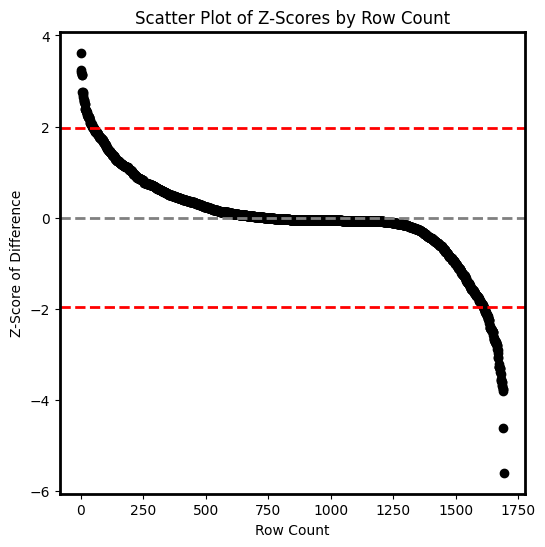

In [129]:
OncoPeaks_WM_stat_LS_2 = OncoPeaks_WM_stat[['p279', 'p318']]

# Create a new column for the difference between 'p279' and 'p318'
OncoPeaks_WM_stat_LS_2['difference'] = OncoPeaks_WM_stat_LS_2['p279'] - OncoPeaks_WM_stat_LS_2['p318']

# Calculate mean and standard deviation of the difference
mean_diff = OncoPeaks_WM_stat_LS_2['difference'].mean()
std_diff = OncoPeaks_WM_stat_LS_2['difference'].std()

# Calculate z-score for the difference
OncoPeaks_WM_stat_LS_2['z_score'] = (OncoPeaks_WM_stat_LS_2['difference'] - mean_diff) / std_diff

# Sort the dataframe by the absolute z-score to find the top differences
#OncoPeaks_WM_stat_LS_2['abs_z_score'] = OncoPeaks_WM_stat_LS_2['z_score'].abs()
#top_differences = OncoPeaks_WM_stat_LS_2.sort_values(by='abs_z_score', ascending=False)

top_differences = OncoPeaks_WM_stat_LS_2.sort_values(by='z_score', ascending=False)
top_differences_2 = top_differences

# Assuming 'top_differences' is already sorted by 'z_score'
top_differences = top_differences.reset_index(drop=True)
top_differences['row_count'] = top_differences.index + 1  # Row count starts at 1

# Even narrower figure width from previous (8,6) to (6,6)
plt.figure(figsize=(6, 6))
plt.scatter(top_differences['row_count'], top_differences['z_score'], alpha=1.0, color='black')

# Thicker red dotted lines with increased 'linewidth'
plt.axhline(1.96, color='red', linestyle='--', linewidth=2) # Thicker line for visibility
plt.axhline(-1.96, color='red', linestyle='--', linewidth=2) # Thicker line for visibility

plt.title('Scatter Plot of Z-Scores by Row Count')
plt.xlabel('Row Count')
plt.ylabel('Z-Score of Difference')

# Optional: Thicker grey line for z-score = 0 reference with 'linewidth' of 2
plt.axhline(0, color='grey', linestyle='--', linewidth=2)

# Thicker axes borders
ax = plt.gca()  # Get the current Axes instance
for axis in ['top','bottom','left','right']:  # Thicken all the axes borders
    ax.spines[axis].set_linewidth(2)

# Save the plot as a PNG file
#plt.savefig('Figure_Panels/Supplementary_Fig_4A.png', dpi=300, bbox_inches='tight')

plt.show()


In [130]:
import pandas as pd
from pybedtools import BedTool
# Reset the index so 'index' becomes a column with the interval information

top_differences = top_differences_2.copy()

top_differences.reset_index(inplace=True)

# Assuming 'top_differences' DataFrame exists and has an 'index' column with the interval information
# Let's create the two interval dataframes based on the z-score thresholds
greater_than_196 = top_differences['z_score'] > 1.96
less_than_neg_196 = top_differences['z_score'] < -1.96

# Make sure 'index' column is cast to string before using the .str accessor
df_279_intervals = top_differences[greater_than_196]['index'].astype(str).str.extract(r'(chr.*):(\d+)-(\d+)')
# Proceed with setting the columns and converting them to numeric types
df_279_intervals.columns = ['chrom', 'start', 'stop']
df_279_intervals['start'] = pd.to_numeric(df_279_intervals['start'])
df_279_intervals['stop'] = pd.to_numeric(df_279_intervals['stop'])
bed_279_intervals = BedTool.from_dataframe(df_279_intervals)


# Repeat for the less_than_neg_196 data
df_318_intervals = top_differences[less_than_neg_196]['index'].astype(str).str.extract(r'(chr.*):(\d+)-(\d+)')
# Proceed with setting the columns and converting them to numeric types
df_318_intervals.columns = ['chrom', 'start', 'stop']
df_318_intervals['start'] = pd.to_numeric(df_318_intervals['start'])
df_318_intervals['stop'] = pd.to_numeric(df_318_intervals['stop'])
bed_318_intervals = BedTool.from_dataframe(df_318_intervals)


# Assuming 'hg38_Gene_List_bed' is already defined and contains gene information for the hg38 assembly
# Overlapping genes for 279 Intervals
overlapping_genes_279 = hg38_Gene_List_bed.intersect(bed_279_intervals, u=True)
df_overlapping_genes_279 = pd.read_csv(overlapping_genes_279.fn, sep='\t', header=None)
df_overlapping_genes_279.columns = ['chrom', 'start', 'stop', 'strand', 'gene']
list_of_genes_279 = df_overlapping_genes_279['gene'].values.tolist()

# Overlapping genes for 318 Intervals
overlapping_genes_318 = hg38_Gene_List_bed.intersect(bed_318_intervals, u=True)
df_overlapping_genes_318 = pd.read_csv(overlapping_genes_318.fn, sep='\t', header=None)
df_overlapping_genes_318.columns = ['chrom', 'start', 'stop', 'strand', 'gene']
list_of_genes_318 = df_overlapping_genes_318['gene'].values.tolist()

# Now you have the gene lists for both 279 high and 318 high intervals


In [131]:
NonCanonical_AML_OPTGs = set(list_of_genes_318) - set(All_OPTG_Genes_set)
Switching_Canonical_AML_OPTGs = set(All_OPTG_Genes_set) & set(list_of_genes_318)

print(len(NonCanonical_AML_OPTGs))
print(len(Switching_Canonical_AML_OPTGs))

51
31


In [132]:
####     WAIT!!!       #####

####This is the CORRECT VERSION but it prints multiple gene names per interval so be careful###

# Copy the original dataframe
top_differences = top_differences_2.copy()

# Reset the index so 'index' becomes a column with the interval information
top_differences.reset_index(inplace=True)


# Create the two interval dataframes based on the z-score thresholds
df_greater_than_196 = top_differences[top_differences['z_score'] > 1.96]
df_less_than_neg_196 = top_differences[top_differences['z_score'] < -1.96]

# Create the two interval dataframes based on the z-score thresholds
greater_than_196 = top_differences['z_score'] > 1.96
less_than_neg_196 = top_differences['z_score'] < -1.96

# Extract chromosome, start, and stop positions for df_greater_than_196
df_279_intervals = top_differences[greater_than_196]['index'].astype(str).str.extract(r'(chr.*):(\d+)-(\d+)')
df_279_intervals.columns = ['chrom', 'start', 'stop']
df_279_intervals['start'] = pd.to_numeric(df_279_intervals['start'])
df_279_intervals['stop'] = pd.to_numeric(df_279_intervals['stop'])
bed_279_intervals = BedTool.from_dataframe(df_279_intervals)

# Extract chromosome, start, and stop positions for df_less_than_neg_196
df_318_intervals = top_differences[less_than_neg_196]['index'].astype(str).str.extract(r'(chr.*):(\d+)-(\d+)')
df_318_intervals.columns = ['chrom', 'start', 'stop']
df_318_intervals['start'] = pd.to_numeric(df_318_intervals['start'])
df_318_intervals['stop'] = pd.to_numeric(df_318_intervals['stop'])
bed_318_intervals = BedTool.from_dataframe(df_318_intervals)

# Assuming 'hg38_Gene_List_bed' is already defined and contains gene information for the hg38 assembly
# Overlapping genes for 279 Intervals
overlapping_genes_279 = bed_279_intervals.intersect(hg38_Gene_List_bed, wao=True)
df_overlapping_genes_279 = pd.read_csv(overlapping_genes_279.fn, sep='\t', header=None)
df_overlapping_genes_279.columns = ['chrom', 'start', 'stop', 'chrom_2', 'start_2', 'stop_2', 'strand', 'gene', 'overlap']
df_overlapping_genes_279['Feature'] = df_overlapping_genes_279['chrom'] + ':' + df_overlapping_genes_279['start'].astype(str) + '-' + df_overlapping_genes_279['stop'].astype(str)

# Group by 'Feature' and combine gene names separated by a comma and a space
df_grouped_279 = df_overlapping_genes_279.groupby('Feature')['gene'].apply(lambda x: ', '.join(x)).reset_index()

# Overlapping genes for 318 Intervals
overlapping_genes_318 = bed_318_intervals.intersect(hg38_Gene_List_bed, wao=True)
df_overlapping_genes_318 = pd.read_csv(overlapping_genes_318.fn, sep='\t', header=None)
df_overlapping_genes_318.columns = ['chrom', 'start', 'stop', 'chrom_2', 'start_2', 'stop_2', 'strand', 'gene', 'overlap']
df_overlapping_genes_318['Feature'] = df_overlapping_genes_318['chrom'] + ':' + df_overlapping_genes_318['start'].astype(str) + '-' + df_overlapping_genes_318['stop'].astype(str)

# Group by 'Feature' and combine gene names separated by a comma and a space
df_grouped_318 = df_overlapping_genes_318.groupby('Feature')['gene'].apply(lambda x: ', '.join(x)).reset_index()

# Merge combined gene names back to the original dataframes
result_279 = df_greater_than_196.merge(df_grouped_279, left_on='index', right_on='Feature', how='left')
result_318 = df_less_than_neg_196.merge(df_grouped_318, left_on='index', right_on='Feature', how='left')

# Save the results
#result_279.to_csv('Figure_Panels/Supplementary_Information_Table_B-ALL_Genes.csv', index=False)
#result_318.to_csv('Figure_Panels/AML_specific_intervals_n_Genes_318.csv', index=False)

# Convert the NonCanonical_AML_OPTGs list to a regex pattern
pattern = '|'.join(NonCanonical_AML_OPTGs)

# Filter result_318 based on partial matches with the NonCanonical_AML_OPTGs
result_NC = result_318[result_318['gene'].str.contains(pattern, case=False, na=False)]


# Filter result_318 to exclude rows based on partial matches with the NonCanonical_AML_OPTGs
result_Canonical_AML_Specific = result_318[~result_318['gene'].str.contains(pattern, case=False, na=False)]


#result_NC.to_csv('Figure_Panels/Supplementary_Information_Table_GMP-like_Genes.csv.csv', index=False)
#result_Canonical_AML_Specific.to_csv('Figure_Panels/Supplementary_Information_Table_Canonical_AML_Genes.csv.csv', index=False)
# Save the results

In [138]:
All_OPTGs = All_OPTG_Genes_set
AML_Specific = list_of_genes_318

All_OPTGs = set(All_OPTGs)
AML_Specific = set(AML_Specific)
#Canonical_AML = set(Canonical_AML)
#AML_Specific = set(AML_Specific)

# Count the total number of unique strings in each group
total_All_OPTGs = len(All_OPTGs)
total_AML_Specific = len(AML_Specific)

# Identify unique and shared genes
unique_All_OPTGs = All_OPTGs - AML_Specific
unique_AML_Specific = AML_Specific - All_OPTGs
shared_genes = All_OPTGs & AML_Specific

# Print the counts
print(f"(1) Total unique genes in the first group: {total_All_OPTGs}")
print(f"(2) Total unique genes in the second group: {total_AML_Specific}")

print(f"(3) Unique genes to the first group: {len(unique_All_OPTGs)}")
print(f"(4) Unique genes to the second group: {len(unique_AML_Specific)}")
print(f"(5) Shared genes between the first and second groups: {len(shared_genes)}")

print(f"(6) Shared_genes: {print(shared_genes)}")

(1) Total unique genes in the first group: 947
(2) Total unique genes in the second group: 82
(3) Unique genes to the first group: 916
(4) Unique genes to the second group: 51
(5) Shared genes between the first and second groups: 31
{'FKBP5', 'MIR5690', 'SATB1-AS1', 'ELF1', 'THSD7A', 'PCNX1', 'TBC1D5', 'JMJD1C', 'FAF1', 'FLT3', 'ZBTB16', 'YBX3', 'KLRK1', 'SAMSN1', 'KLRC3', 'AKAP13', 'LOC101928100', 'ARPP21', 'BAZ1A', 'SATB1', 'KLRC4', 'NR3C1', 'SUPT3H', 'CCNL1', 'CNST', 'ZC3H12C', 'RUNX2', 'KLRC4-KLRK1', 'NT5C2', 'CDKN2C', 'RREB1'}
(6) Shared_genes: None


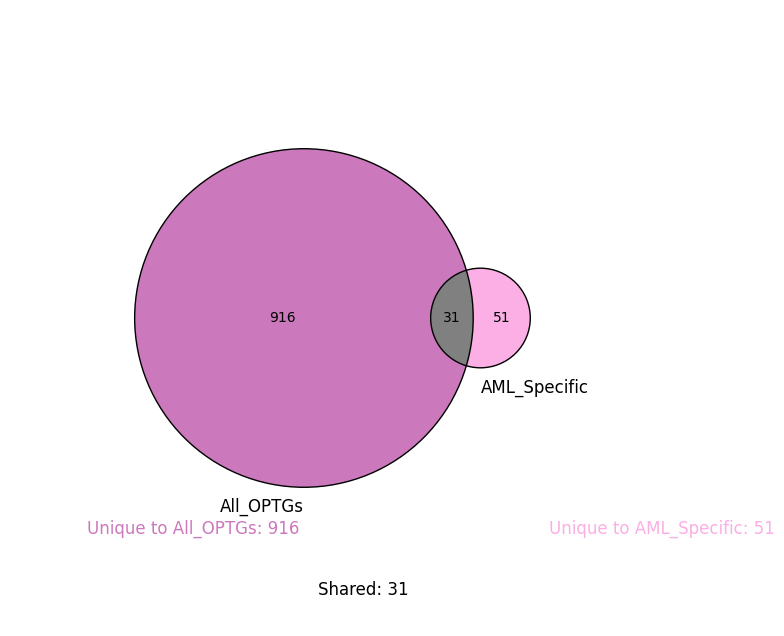

In [139]:
all_colors = sns.color_palette("colorblind")
#custom_colors = [all_colors[9], all_colors[1]]

#all_colors = sns.color_palette("colorblind")
#colorblind_2 = [all_colors[4], all_colors[6]]

# Define colors for each cluster and the overlap
cluster_colors = {'10': all_colors[4], '01': all_colors[6], '11': 'grey'}

# Create a Venn diagram and save to a file
plt.figure(figsize=(10, 8))
venn_diagram = venn2(subsets=(len(unique_All_OPTGs), len(unique_AML_Specific), len(shared_genes)),
                     set_labels=('All_OPTGs', 'AML_Specific'))
venn2_circles(subsets=(len(unique_All_OPTGs), len(unique_AML_Specific), len(shared_genes)), linewidth=1, color="black")

# Apply the color scheme
for area in ('10', '01', '11'):
    venn_diagram.get_patch_by_id(area).set_color(cluster_colors[area])
    venn_diagram.get_patch_by_id(area).set_edgecolor('none')
    venn_diagram.get_patch_by_id(area).set_alpha(1)

# Place the count labels outside the plot area. You may adjust the x and y coordinates as needed.
plt.text(-0.75, -0.70, f"Unique to All_OPTGs: {len(unique_All_OPTGs)}", fontsize=12, color=cluster_colors['10'])
plt.text(0.75, -0.70, f"Unique to AML_Specific: {len(unique_AML_Specific)}", fontsize=12, color=cluster_colors['01'])
plt.text(0, -0.90, f"Shared: {len(shared_genes)}", fontsize=12, color='black')

# Set the axis limits if the text is still not displaying correctly
plt.xlim([-1, 1])
plt.ylim([-1, 1])

#plt.title("Venn Diagram of All_OPTGs and AML_Specific")
#plt.savefig('Figure_Panels/Fig_5G.png')  # Saves the Venn diagram as a PNG file
plt.show()  # Show the plot for verification

In [140]:
BALL_Specific = list_of_genes_279

All_OPTGs = set(All_OPTGs)
BALL_Specific = set(BALL_Specific)
#Canonical_AML = set(Canonical_AML)
#AML_Specific = set(AML_Specific)

# Count the total number of unique strings in each group
total_All_OPTGs = len(All_OPTGs)
total_BALL_Specific = len(BALL_Specific)

# Identify unique and shared genes
unique_All_OPTGs = All_OPTGs - BALL_Specific
unique_BALL_Specific = BALL_Specific - All_OPTGs
shared_genes = All_OPTGs & BALL_Specific

# Print the counts
print(f"(1) Total unique genes in the first group: {total_All_OPTGs}")
print(f"(2) Total unique genes in the second group: {total_BALL_Specific}")

print(f"(3) Unique genes to the first group: {len(unique_All_OPTGs)}")
print(f"(4) Unique genes to the second group: {len(unique_BALL_Specific)}")
print(f"(5) Shared genes between the first and second groups: {len(shared_genes)}")

print(f"(6) Shared_genes: {print(shared_genes)}")

(1) Total unique genes in the first group: 947
(2) Total unique genes in the second group: 66
(3) Unique genes to the first group: 883
(4) Unique genes to the second group: 2
(5) Shared genes between the first and second groups: 64
{'PPP2R5C', 'C11orf74', 'PCDHGA7', 'CLEC14A', 'PCDHGC5', 'TM9SF3', 'MSI2', 'PCDHGB6', 'VAV3', 'PCDHGB7', 'RAG2', 'IGF2BP2', 'MSH6', 'PCDHGB1', 'PCDHGA3', 'KLRF2', 'FOXP1-AS1', 'FOXP1', 'PCDHGB5', 'PCDHGA11', 'PCDHGA10', 'AK5', 'MED13L', 'PCDHGB4', 'ZMYND8', 'DSE', 'CLEC2A', 'KCNK12', 'RAG1', 'PCDHGA2', 'LOC101928269', 'ANTXR2', 'CDCA7', 'PCDHGA1', 'MIR548AQ', 'PCDHGC3', 'GPR174', 'DNTT', 'PCDHGA6', 'PIK3AP1', 'PCDHGA12', 'PCDHGA8', 'BCL7A', 'CEP78', 'BANK1', 'PCDHGB2', 'PCDHGC4', 'MPZL1', 'PCDHGA9', 'CD34', 'PRDM8', 'BLNK', 'LOC101927377', 'TCF4', 'RUNX1', 'WDR66', 'IGF2BP2-AS1', 'PCDHGA5', 'CLEC2B', 'EBF1', 'PCDHGA4', 'GALNT2', 'ETS2', 'PCDHGB3'}
(6) Shared_genes: None


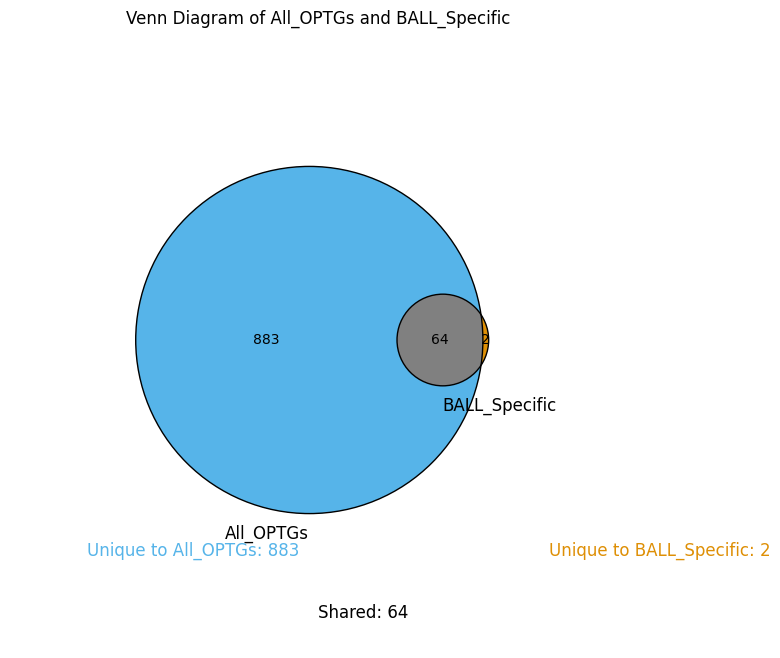

In [141]:
all_colors = sns.color_palette("colorblind")
#custom_colors = [all_colors[9], all_colors[1]]

#all_colors = sns.color_palette("colorblind")
#colorblind_2 = [all_colors[4], all_colors[6]]

# Define colors for each cluster and the overlap
cluster_colors = {'10': all_colors[9], '01': all_colors[1], '11': 'grey'}

# Create a Venn diagram and save to a file
plt.figure(figsize=(10, 8))
venn_diagram = venn2(subsets=(len(unique_All_OPTGs), len(unique_BALL_Specific), len(shared_genes)),
                     set_labels=('All_OPTGs', 'BALL_Specific'))
venn2_circles(subsets=(len(unique_All_OPTGs), len(unique_BALL_Specific), len(shared_genes)), linewidth=1, color="black")

# Apply the color scheme
for area in ('10', '01', '11'):
    venn_diagram.get_patch_by_id(area).set_color(cluster_colors[area])
    venn_diagram.get_patch_by_id(area).set_edgecolor('none')
    venn_diagram.get_patch_by_id(area).set_alpha(1)

# Place the count labels outside the plot area. You may adjust the x and y coordinates as needed.
plt.text(-0.75, -0.70, f"Unique to All_OPTGs: {len(unique_All_OPTGs)}", fontsize=12, color=cluster_colors['10'])
plt.text(0.75, -0.70, f"Unique to BALL_Specific: {len(unique_BALL_Specific)}", fontsize=12, color=cluster_colors['01'])
plt.text(0, -0.90, f"Shared: {len(shared_genes)}", fontsize=12, color='black')

# Set the axis limits if the text is still not displaying correctly
plt.xlim([-1, 1])
plt.ylim([-1, 1])

plt.title("Venn Diagram of All_OPTGs and BALL_Specific")
#plt.savefig('Figure_Panels/Fig_5G.png')  # Saves the Venn diagram as a PNG file
plt.show()  # Show the plot for verification

/tmp/ipykernel_101832/908632330.py:54: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x='Sample_2', y='Z-Score Expression', hue='Condition', data=melted_data,


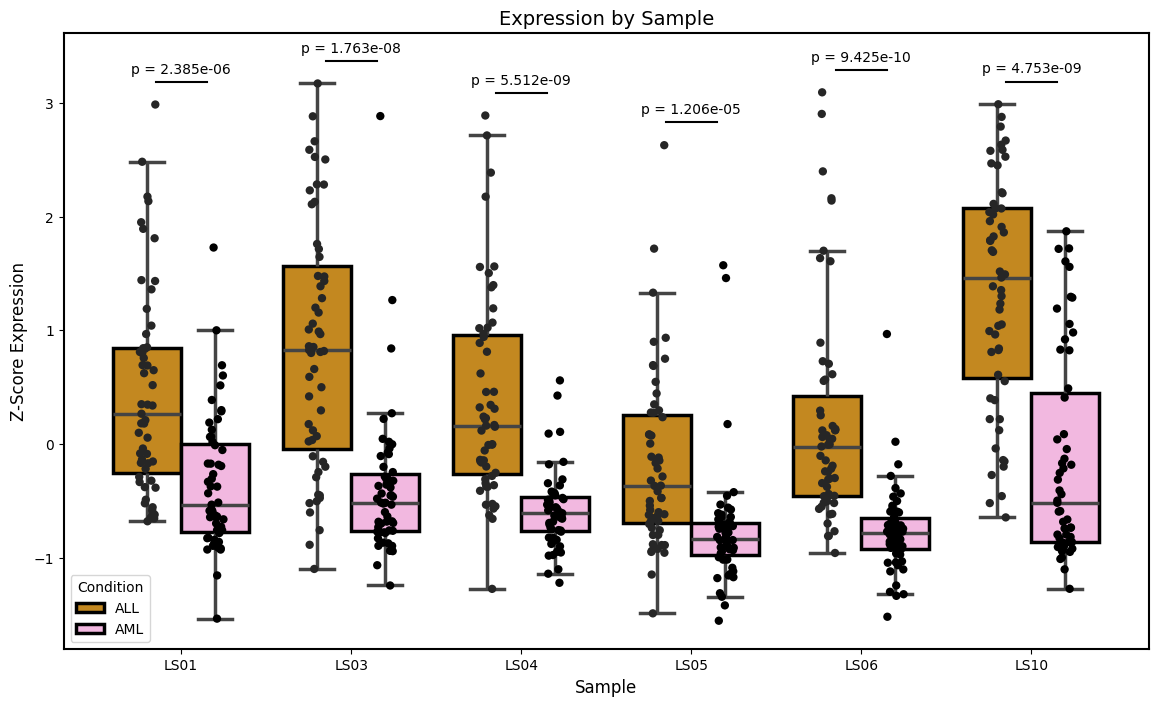

In [142]:
# This one uses a Wilcoxon Signed-rank Test with a one-sided hypothesis ###

# Read your data
MLLr_Lineage_Switching_RNA = pd.read_csv('MLLr_Lineage_Switching_Blood_Genes.csv', header=2)

# Assuming list_of_genes_279 is defined elsewhere in your code
# list_of_genes_279 = [...]

# Filter the DataFrame to only include the desired genes
filtered_data = MLLr_Lineage_Switching_RNA[MLLr_Lineage_Switching_RNA['external_gene_name'].isin(list_of_genes_279)].copy()

# Define the columns for ALL and AML
all_columns = ['LS01P', 'LS03P', 'LS04P', 'LS05P', 'LS06P', 'LS10P']
aml_columns = ['LS01R', 'LS03R', 'LS04R', 'LS05R', 'LS06R', 'LS10R']
all_and_aml_columns = all_columns + aml_columns

# Calculate z-scores for each gene across ALL and AML samples
filtered_data.loc[:, all_and_aml_columns] = filtered_data[all_and_aml_columns].apply(zscore, axis=1)

# Melt the data for seaborn boxplot
melted_data = pd.melt(filtered_data, id_vars='external_gene_name', value_vars=all_and_aml_columns, var_name='Sample', value_name='Z-Score Expression')

# Define conditions
melted_data['Condition'] = melted_data['Sample'].apply(lambda x: 'ALL' if 'P' in x else 'AML')

# Create 'Sample_2' column
sample_map = {
    'LS01P': 'LS01', 'LS01R': 'LS01', 
    'LS03P': 'LS03', 'LS03R': 'LS03', 
    'LS04P': 'LS04', 'LS04R': 'LS04', 
    'LS05P': 'LS05', 'LS05R': 'LS05', 
    'LS06P': 'LS06', 'LS06R': 'LS06', 
    'LS10P': 'LS10', 'LS10R': 'LS10'
}
melted_data['Sample_2'] = melted_data['Sample'].map(sample_map)

# Ensure the order of the samples in the plot
sample_order = ['LS01', 'LS03', 'LS04', 'LS05', 'LS06', 'LS10']
melted_data['Sample_2'] = pd.Categorical(melted_data['Sample_2'], categories=sample_order, ordered=True)
melted_data.sort_values('Sample_2', inplace=True)

# Use the colorblind palette for colors
all_colors = sns.color_palette("colorblind")
colorblind_2 = {'ALL': all_colors[1], 'AML': all_colors[6]}

# Adjust the figure size as needed
plt.figure(figsize=(14, 8))

# Plotting with seaborn using the colorblind palette
ax = sns.boxplot(x='Sample_2', y='Z-Score Expression', hue='Condition', data=melted_data, 
                 palette=colorblind_2, showfliers=False, linewidth=2.5, dodge=True, boxprops=dict(edgecolor="black"))

# Overlay individual points using stripplot, with correct alignment
sns.stripplot(x='Sample_2', y='Z-Score Expression', hue='Condition', data=melted_data, 
              dodge=True, color='black', alpha=1, jitter=True, size=6)

# Remove duplicate legends
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Condition')

# Define box pairs for statistical annotation
box_pairs = [
    (("LS01", "ALL"), ("LS01", "AML")),
    (("LS03", "ALL"), ("LS03", "AML")),
    (("LS04", "ALL"), ("LS04", "AML")),
    (("LS05", "ALL"), ("LS05", "AML")),
    (("LS06", "ALL"), ("LS06", "AML")),
    (("LS10", "ALL"), ("LS10", "AML"))
]

# Calculate p-values for each pair using the Wilcoxon signed-rank test
p_values = []
for pair in box_pairs:
    sample1 = melted_data[(melted_data['Sample_2'] == pair[0][0]) & (melted_data['Condition'] == pair[0][1])]['Z-Score Expression']
    sample2 = melted_data[(melted_data['Sample_2'] == pair[1][0]) & (melted_data['Condition'] == pair[1][1])]['Z-Score Expression']
    stat, p_value = wilcoxon(sample1, sample2, alternative='greater')
    p_values.append(p_value)

# Manually add p-values and brackets
for i, (pair, p_val) in enumerate(zip(box_pairs, p_values)):
    # Get the x position of the two samples being compared
    sample1 = pair[0][0]
    x1 = sample_order.index(sample1)
    
    # Set the y position above the current max boxplot value for both ALL and AML
    y = melted_data[(melted_data['Sample_2'] == sample1)]['Z-Score Expression'].max() + 0.2
    
    # Plot the bracket and p-value
    plt.plot([x1-0.15, x1+0.15], [y, y], lw=1.5, color='black')
    plt.text(x1, y+0.05, f"p = {p_val:.3e}", ha='center', va='bottom', fontsize=10, color='black')

# Increase the linewidth of the plot borders for aesthetics
for _, spine in ax.spines.items():
    spine.set_linewidth(1.5)

# Label the axes and set a title
ax.set_xlabel('Sample', fontsize=12)
ax.set_ylabel('Z-Score Expression', fontsize=12)
ax.set_title('Expression by Sample', fontsize=14)

#plt.savefig('Figure_Panels/Fig_5I.png')
# Show the plot
plt.show()


/tmp/ipykernel_101832/3719485837.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[all_and_aml_columns] = filtered_data[all_and_aml_columns].apply(zscore, axis=1)
/tmp/ipykernel_101832/3719485837.py:52: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x='Sample_2', y='Z-Score Expression', hue='Condition', data=melted_data, color='black', alpha=1, jitter=True, dodge=True)


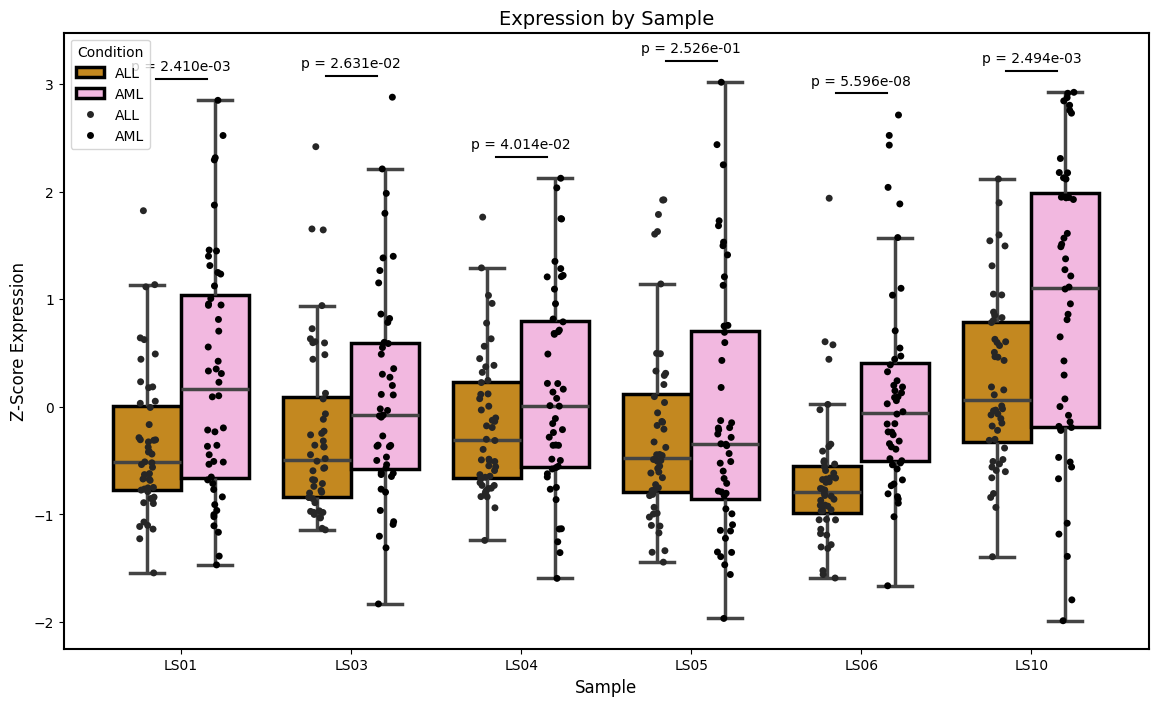

In [143]:
# This one uses a Wilcoxon Signed-rank Test with a one-sided hypothesis ###

# Read your data
MLLr_Lineage_Switching_RNA = pd.read_csv('MLLr_Lineage_Switching_Blood_Genes.csv', header=2)

# Assuming list_of_genes_279 is defined elsewhere in your code
# list_of_genes_279 = [...]

# Filter the DataFrame to only include the desired genes
# Filter the DataFrame to only include the desired genes
filtered_data = MLLr_Lineage_Switching_RNA[MLLr_Lineage_Switching_RNA['external_gene_name'].isin(NonCanonical_AML_OPTGs)]

# Define the columns for ALL and AML
all_columns = ['LS01P', 'LS03P', 'LS04P', 'LS05P', 'LS06P', 'LS10P']
aml_columns = ['LS01R', 'LS03R', 'LS04R', 'LS05R', 'LS06R', 'LS10R']
all_and_aml_columns = all_columns + aml_columns

# Calculate z-scores for each gene across ALL and AML samples
filtered_data[all_and_aml_columns] = filtered_data[all_and_aml_columns].apply(zscore, axis=1)

# Melt the data for seaborn boxplot
melted_data = pd.melt(filtered_data, id_vars='external_gene_name', value_vars=all_and_aml_columns, var_name='Sample', value_name='Z-Score Expression')

# Define conditions
melted_data['Condition'] = melted_data['Sample'].apply(lambda x: 'ALL' if 'P' in x else 'AML')

# Create 'sample_2' column
sample_map = {
    'LS01P': 'LS01', 'LS01R': 'LS01', 
    'LS03P': 'LS03', 'LS03R': 'LS03', 
    'LS04P': 'LS04', 'LS04R': 'LS04', 
    'LS05P': 'LS05', 'LS05R': 'LS05', 
    'LS06P': 'LS06', 'LS06R': 'LS06', 
    'LS10P': 'LS10', 'LS10R': 'LS10'
}
melted_data['Sample_2'] = melted_data['Sample'].map(sample_map)

# Ensure the order of the samples in the plot
sample_order = ['LS01', 'LS03', 'LS04', 'LS05', 'LS06', 'LS10']
melted_data['Sample_2'] = pd.Categorical(melted_data['Sample_2'], categories=sample_order, ordered=True)
melted_data.sort_values('Sample_2', inplace=True)

# Use the colorblind palette for colors
all_colors = sns.color_palette("colorblind")
colorblind_2 = {'ALL': all_colors[1], 'AML': all_colors[6]}

# Adjust the figure size as needed
plt.figure(figsize=(14, 8))

# Plotting with seaborn using the colorblind palette
ax = sns.boxplot(x='Sample_2', y='Z-Score Expression', hue='Condition', data=melted_data, palette=colorblind_2, showfliers=False, linewidth=2.5, boxprops=dict(edgecolor="black"))
sns.stripplot(x='Sample_2', y='Z-Score Expression', hue='Condition', data=melted_data, color='black', alpha=1, jitter=True, dodge=True)

# Define box pairs for statistical annotation
box_pairs = [
    (("LS01", "ALL"), ("LS01", "AML")),
    (("LS03", "ALL"), ("LS03", "AML")),
    (("LS04", "ALL"), ("LS04", "AML")),
    (("LS05", "ALL"), ("LS05", "AML")),
    (("LS06", "ALL"), ("LS06", "AML")),
    (("LS10", "ALL"), ("LS10", "AML"))
]

# Calculate p-values for each pair using the Wilcoxon signed-rank test
p_values = []
for pair in box_pairs:
    sample1 = melted_data[
        (melted_data['Sample_2'] == pair[0][0]) & 
        (melted_data['Condition'] == pair[0][1])
    ]['Z-Score Expression']
    sample2 = melted_data[
        (melted_data['Sample_2'] == pair[1][0]) & 
        (melted_data['Condition'] == pair[1][1])
    ]['Z-Score Expression']
    stat, p_value = wilcoxon(sample1, sample2, alternative='less')
    p_values.append(p_value)
    
# Manually add p-values and brackets
for i, (pair, p_val) in enumerate(zip(box_pairs, p_values)):
    # Get the x position of the two samples being compared
    sample1 = pair[0][0]
    x1 = sample_order.index(sample1)
    
    # Set the y position above the current max boxplot value for both ALL and AML
    y = melted_data[(melted_data['Sample_2'] == sample1)]['Z-Score Expression'].max() + 0.2
    
    # Plot the bracket and p-value
    plt.plot([x1-0.15, x1+0.15], [y, y], lw=1.5, color='black')
    plt.text(x1, y+0.05, f"p = {p_val:.3e}", ha='center', va='bottom', fontsize=10, color='black')

# Increase the linewidth of the plot borders for aesthetics
for _, spine in ax.spines.items():
    spine.set_linewidth(1.5)

# Label the axes and set a title
ax.set_xlabel('Sample', fontsize=12)
ax.set_ylabel('Z-Score Expression', fontsize=12)
ax.set_title('Expression by Sample', fontsize=14)

#plt.savefig('Figure_Panels/Fig_5J.png')
# Show the plot
plt.show()


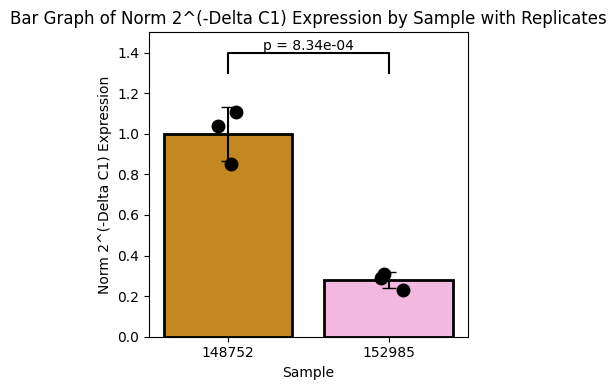

In [144]:
# Load the data
Oncogene_Oncoprotein_QPCR = pd.read_csv("QPCR_Oncogene_Oncoprotein_Replicates.csv", sep=',', index_col=0)

# Transpose the DataFrame
df = Oncogene_Oncoprotein_QPCR.transpose()

# Convert necessary columns to numeric
df['Norm 2^(-Delta C1) Rep1'] = pd.to_numeric(df['Norm 2^(-Delta C1) Rep1'], errors='coerce')
df['Norm 2^(-Delta C1) Rep2'] = pd.to_numeric(df['Norm 2^(-Delta C1) Rep2'], errors='coerce')
df['Norm 2^(-Delta C1) Rep3'] = pd.to_numeric(df['Norm 2^(-Delta C1) Rep3'], errors='coerce')

# Step 1: Filter rows and create a copy
df_filtered = df.loc[df.index.isin(['148752', '152985'])].copy()

# Reorder the rows to ensure p279 comes first
df_filtered = df_filtered.loc[['148752', '152985']]

# Drop columns with any NaN values
df_filtered = df_filtered.dropna(axis=1)

# Reset the index to bring 'Sample' back as a column
df_filtered = df_filtered.reset_index()

# Rename columns to match the variables
df_filtered.columns = ['Sample', 'Primer', 'Norm 2^(-Delta C1) Rep1', 'Norm 2^(-Delta C1) Rep2', 'Norm 2^(-Delta C1) Rep3', 
                       'Delta Delta Cq Expression', 'Delta Delta Cq St. Deviation', 'Oncoprotein Score', 'Target Norm Oncoprotein Score']

# Melt the dataframe to have replicates as rows
df_melted = pd.melt(df_filtered, id_vars=['Sample'], 
                    value_vars=['Norm 2^(-Delta C1) Rep1', 'Norm 2^(-Delta C1) Rep2', 'Norm 2^(-Delta C1) Rep3'],
                    var_name='Replicate', value_name='Expression')

# Calculate means and standard deviations based on individual replicates
df_means = df_melted.groupby('Sample')['Expression'].mean().reset_index()
df_std = df_melted.groupby('Sample')['Expression'].std().reset_index()

# Perform t-test between p279 and p318 based on replicate values
p279_values = df_melted[df_melted['Sample'] == '148752']['Expression']
p318_values = df_melted[df_melted['Sample'] == '152985']['Expression']

# Perform t-test using individual replicate values
t_stat, p_val = ttest_ind(p279_values, p318_values)

# Set the colors for the bars
all_colors = sns.color_palette("colorblind")
colorblind_2 = [all_colors[1], all_colors[6]]  # Colors for 148752 and 152985
custom_palette = sns.color_palette(colorblind_2)

# Create the bar graph with error bars
plt.figure(figsize=(4, 4))
barplot = sns.barplot(
    data=df_means, 
    x='Sample', 
    y='Expression', 
    hue='Sample',  # Assign x variable to hue
    palette=custom_palette, 
    edgecolor='black', 
    linewidth=2, 
    capsize=0.1,
    err_kws={'linewidth': 1.5},  # Replace errwidth with err_kws
    legend=False  # Suppress the legend
)

# Add error bars manually based on std deviation
for i, sample in enumerate(['148752', '152985']):
    mean_val = df_means[df_means['Sample'] == sample]['Expression'].values[0]
    std_val = df_std[df_std['Sample'] == sample]['Expression'].values[0]
    plt.errorbar(i, mean_val, yerr=std_val, fmt='none', ecolor='black', capsize=5)

# Overlay individual replicates as large black dots in a strip plot
sns.stripplot(
    data=df_melted, 
    x='Sample', 
    y='Expression', 
    hue=None,  # Don't assign hue, just plot the dots
    color='black', 
    size=10, 
    jitter=True  # Slightly offset the dots to avoid overlap
)

# Add p-value above the bars
x1, x2 = 0, 1
y, h, col = df_means['Expression'].max() + 0.3, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5, y + h, f"p = {p_val:.2e}", ha='center', va='bottom', color=col)

# Customize the plot
plt.ylim(0, 1.5)
plt.xlabel('Sample')
plt.ylabel('Norm 2^(-Delta C1) Expression')
plt.title('Bar Graph of Norm 2^(-Delta C1) Expression by Sample with Replicates')
plt.tight_layout()

# Save the plot
#plt.savefig('Figure_Panels/Fig_6C.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [53]:
#This code will quantify the ENL signal over different groups of Oncoprotein Peaks
#You can skip ahead and load the resulting table from p148752_152985_ENL_Signal.csv

def quantify_signal(bed_all, bed_aml, total_bed):
    # Read the bed_all and bed_aml files directly
    tbp_coverage_all = pd.read_csv(bed_all, sep='\t', header=None)
    tbp_coverage_all = tbp_coverage_all.iloc[:, :3]
    tbp_coverage_all.columns = ['chrom', 'start', 'stop']
    tbp_coverage_all['bp'] = tbp_coverage_all['stop'] - tbp_coverage_all['start']
    tbp_coverage_all = tbp_coverage_all["bp"].sum()
    
    tbp_coverage_aml = pd.read_csv(bed_aml, sep='\t', header=None)
    tbp_coverage_aml = tbp_coverage_aml.iloc[:, :3]
    tbp_coverage_aml.columns = ['chrom', 'start', 'stop']
    tbp_coverage_aml['bp'] = tbp_coverage_aml['stop'] - tbp_coverage_aml['start']
    tbp_coverage_aml = tbp_coverage_aml["bp"].sum()
    
    # Convert the DataFrame to BedTool
    Sample_bed_all = BedTool(bed_all)
    Sample_bed_aml = BedTool(bed_aml)

    # Intersect ALL bed file
    Sample_overlap_int_sum_all = total_bed.intersect(Sample_bed_all, wao=True)
    Sample_overlap_int_sum_all = pd.read_csv(Sample_overlap_int_sum_all.fn, sep='\t', header=None)
    Sample_overlap_int_sum_all.columns = ['chrom', 'start', 'stop', 'chrom2', 'start2', 'stop2', 'blah1', 'blah2', 'overlap']
    Sample_overlap_int_sum_all = Sample_overlap_int_sum_all.groupby(['chrom', 'start', 'stop']).agg({'overlap': 'sum'}).reset_index()
    Sample_overlap_int_sum_all.columns = ['chrom', 'start', 'stop', 'Sample_sum']
    Sample_overlap_int_sum_all['ALL_signal'] = (Sample_overlap_int_sum_all['Sample_sum'] * ((1/tbp_coverage_all)*1000000000)) + 1
    Sample_overlap_int_sum_all['peak_size'] = Sample_overlap_int_sum_all['stop'] - Sample_overlap_int_sum_all['start']
    Sample_overlap_int_sum_all['ALL_sum_norm'] = ((Sample_overlap_int_sum_all['Sample_sum'] / Sample_overlap_int_sum_all['peak_size']) * ((1/tbp_coverage_all)*1000000000)) + 1
    
    # Intersect AML bed file
    Sample_overlap_int_sum_all_bed = BedTool.from_dataframe(Sample_overlap_int_sum_all[['chrom', 'start', 'stop', 'Sample_sum', 'ALL_signal', 'peak_size', 'ALL_sum_norm']])
    
    Sample_overlap_int_sum_aml = Sample_overlap_int_sum_all_bed.intersect(Sample_bed_aml, wao=True)
    Sample_overlap_int_sum_aml = pd.read_csv(Sample_overlap_int_sum_aml.fn, sep='\t', header=None)
    Sample_overlap_int_sum_aml.columns = ['chrom', 'start', 'stop', 'ALL_sum', 'ALL_signal', 'peak_size', 'ALL_sum_norm', 'chrom2', 'start2', 'stop2', 'blah1', 'blah2', 'overlap']
    Sample_overlap_int_sum_aml = Sample_overlap_int_sum_aml.groupby(['chrom', 'start', 'stop', 'ALL_sum', 'ALL_signal', 'peak_size', 'ALL_sum_norm']).agg({'overlap': 'sum'}).reset_index()
    Sample_overlap_int_sum_aml.columns = ['chrom', 'start', 'stop', 'ALL_sum', 'ALL_signal', 'peak_size', 'ALL_sum_norm', 'Sample_sum']
    Sample_overlap_int_sum_aml['AML_signal'] = (Sample_overlap_int_sum_aml['Sample_sum'] * ((1/tbp_coverage_aml)*1000000000)) + 1
    Sample_overlap_int_sum_aml['AML_sum_norm'] = ((Sample_overlap_int_sum_aml['Sample_sum'] / Sample_overlap_int_sum_aml['peak_size']) * ((1/tbp_coverage_aml)*1000000000)) + 1
    Sample_overlap_int_sum_aml['Difference'] = Sample_overlap_int_sum_aml['ALL_sum_norm'] - Sample_overlap_int_sum_aml['AML_sum_norm']
    Sample_overlap_int_sum_aml = Sample_overlap_int_sum_aml.sort_values(by='Difference', ascending=True)
    
    return Sample_overlap_int_sum_aml

# Create OncoPeaks_WM_stat_bed

OncoPeaks_WM_stat_bed = OncoPeaks_WM_stat.copy()

# Move index to a column
OncoPeaks_WM_stat_bed.reset_index(inplace=True)

# Split the 'location' column into 'chrom', 'start', and 'stop'
OncoPeaks_WM_stat_bed[['chrom', 'start', 'stop']] = OncoPeaks_WM_stat_bed['index'].str.extract(r'(chr\w+):(\d+)-(\d+)')
OncoPeaks_WM_stat_bed = OncoPeaks_WM_stat_bed[['chrom', 'start', 'stop']]

# Convert 'start' and 'stop' columns to integers
OncoPeaks_WM_stat_bed['start'] = OncoPeaks_WM_stat_bed['start'].astype(int)
OncoPeaks_WM_stat_bed['stop'] = OncoPeaks_WM_stat_bed['stop'].astype(int)

# Convert the DataFrame to BED format
OncoPeaks_WM_stat_bed = BedTool.from_dataframe(OncoPeaks_WM_stat_bed[['chrom', 'start', 'stop']])

# Example usage
bed_all = 'DJ_Hs_148752_ENL_combined.bed'
bed_aml = 'DJ_Hs_152985_ENL_combined.bed'

LS2_ENL_Signal = quantify_signal(bed_all, bed_aml, OncoPeaks_WM_stat_bed)

# Step 1: Sort the dataframe
LS2_ENL_Signal = LS2_ENL_Signal.sort_values(by=['chrom', 'start', 'stop'])

# Convert to BED format
bed_LS2_ENL_Signal = BedTool.from_dataframe(LS2_ENL_Signal[['chrom', 'start', 'stop']])

# Assuming 'hg38_Gene_List_bed' is already defined and contains gene information for the hg38 assembly
# Intersect with the gene list to find overlapping genes
overlapping_genes = bed_LS2_ENL_Signal.intersect(hg38_Gene_List_bed, wao=True)

# Read the intersect result into a dataframe
df_overlapping_genes = pd.read_csv(overlapping_genes.fn, sep='\t', header=None)
df_overlapping_genes.columns = [
    'chrom', 'start', 'stop', 'chrom_2', 'start_2', 'stop_2', 
    'strand', 'gene', 'overlap'
]

# Create a 'Feature' column to group by
df_overlapping_genes['Feature'] = df_overlapping_genes['chrom'] + ':' + df_overlapping_genes['start'].astype(str) + '-' + df_overlapping_genes['stop'].astype(str)

# Expand the dataframe to include each gene as a separate row
df_overlapping_genes_expanded = df_overlapping_genes.assign(gene=df_overlapping_genes['gene'].str.split(', ')).explode('gene')

# Create a 'Feature' column in the original dataframe for merging
LS2_ENL_Signal['Feature'] = LS2_ENL_Signal['chrom'] + ':' + LS2_ENL_Signal['start'].astype(str) + '-' + LS2_ENL_Signal['stop'].astype(str)

# Merge the expanded genes dataframe with the original dataframe
result_LS2 = LS2_ENL_Signal.merge(df_overlapping_genes_expanded[['Feature', 'gene']], on='Feature', how='left')

# Drop the 'Feature' column if not needed
result_LS2 = result_LS2.drop(columns=['Feature'])

result_LS2 = result_LS2.sort_values(by='Difference', ascending=True)

# Corrected merge function for non-canonical AML
def merge_dataframes(LS2_ENL_Signal, result_279, result_NC):
    # Initialize 'Peak_type' column in LS2_ENL_Signal
    LS2_ENL_Signal['Peak_type'] = 'Oncoprotein_Target'
    
    # Ensure the Feature column is used for splitting
    for df in [result_279, result_NC]:
        df[['chrom', 'start', 'stop']] = df['Feature'].str.extract(r'(chr\w+):(\d+)-(\d+)')
        df['start'] = pd.to_numeric(df['start'], errors='coerce')
        df['stop'] = pd.to_numeric(df['stop'], errors='coerce')
    
    # Sorting dataframes
    LS2_ENL_Signal = LS2_ENL_Signal.sort_values(by=['chrom', 'start', 'stop'])
    result_279 = result_279.sort_values(by=['chrom', 'start', 'stop'])
    result_NC = result_NC.sort_values(by=['chrom', 'start', 'stop'])
    
    # Move 'chrom', 'start', 'stop' to the first columns in result_279 and result_NC
    cols = ['chrom', 'start', 'stop'] + [col for col in result_279.columns if col not in ['chrom', 'start', 'stop']]
    result_279 = result_279[cols]
    result_NC = result_NC[cols]
    
    # Expand the dataframes to include each gene as a separate row
    result_279_expanded = result_279.assign(gene_279=result_279['gene'].str.split(', ')).explode('gene_279')
    result_NC_expanded = result_NC.assign(gene_NC=result_NC['gene'].str.split(', ')).explode('gene_NC')
    
    # Merging LS2_ENL_Signal with result_279_expanded
    merged_df = pd.merge(LS2_ENL_Signal, result_279_expanded[['chrom', 'start', 'stop', 'gene_279']], on=['chrom', 'start', 'stop'], how='left')
    merged_df.loc[merged_df['gene_279'].notna(), 'Peak_type'] = 'ALL_specific'
    
    # Merging the result with result_NC_expanded
    merged_df = pd.merge(merged_df, result_NC_expanded[['chrom', 'start', 'stop', 'gene_NC']], on=['chrom', 'start', 'stop'], how='left')
    merged_df.loc[merged_df['gene_NC'].notna(), 'Peak_type'] = 'AML_specific'
    
    return merged_df

# Assuming LS2_ENL_Signal, result_279, and result_NC are already defined
# Calling the function to merge dataframes
final_merged_df = merge_dataframes(LS2_ENL_Signal, result_279, result_NC)

# Assuming final_merged_df and result_LS2 are already defined
# Ensure the 'chrom', 'start', and 'stop' columns are in the correct data type
final_merged_df['start'] = pd.to_numeric(final_merged_df['start'], errors='coerce')
final_merged_df['stop'] = pd.to_numeric(final_merged_df['stop'], errors='coerce')
result_LS2['start'] = pd.to_numeric(result_LS2['start'], errors='coerce')
result_LS2['stop'] = pd.to_numeric(result_LS2['stop'], errors='coerce')

# Merge the final_merged_df with result_LS2
p148752_152985_ENL_Signal = pd.merge(final_merged_df, result_LS2, on=['chrom', 'start', 'stop'], how='left')

/tmp/ipykernel_101832/1831875828.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['chrom', 'start', 'stop']] = df['Feature'].str.extract(r'(chr\w+):(\d+)-(\d+)')
/tmp/ipykernel_101832/1831875828.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start'] = pd.to_numeric(df['start'], errors='coerce')
/tmp/ipykernel_101832/1831875828.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [145]:
#p148752_152985_ENL_Signal.to_csv('p148752_152985_ENL_Signal.csv', index=True)
p148752_152985_ENL_Signal = pd.read_csv("p148752_152985_ENL_Signal.csv", sep=',', index_col=0)

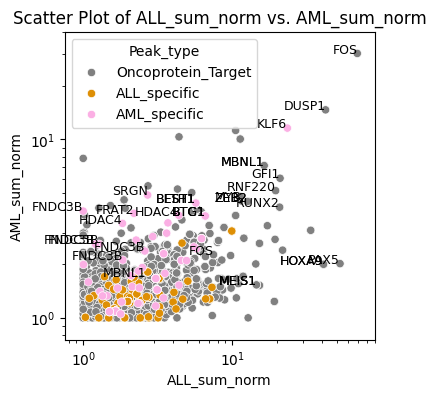

In [146]:
# Ensure the boxes are ordered
p148752_152985_ENL_Signal['Peak_type'] = pd.Categorical(p148752_152985_ENL_Signal['Peak_type'], categories=['Oncoprotein_Target', 'ALL_specific', 'AML_specific'], ordered=True)

plt.figure(figsize=(4, 4))

# Use the colorblind palette for colors
all_colors = sns.color_palette("colorblind")
colorblind_palette = {'Oncoprotein_Target': 'grey', 'ALL_specific': all_colors[1], 'AML_specific': all_colors[6]}

# Create the scatter plot
ax = sns.scatterplot(data=p148752_152985_ENL_Signal.sort_values(by='Peak_type', ascending=True), 
                     x='ALL_sum_norm_x', y='AML_sum_norm_x', hue='Peak_type', palette=colorblind_palette)
plt.xlabel('ALL_sum_norm')
plt.ylabel('AML_sum_norm')
plt.xlim(0.75, 90)  # Adjust these limits as needed
plt.ylim(0.75, 40)  # Adjust these limits as needed
plt.xscale('log')
plt.yscale('log')
plt.title('Scatter Plot of ALL_sum_norm vs. AML_sum_norm')
plt.legend(title='Peak_type')

# List of genes to annotate
genes_to_annotate = ['HOXA9', 'MEIS1', 'FOS', 'KLF6', 'DUSP1', 'RUNX2', 'MYB', 'SRGN', 'BEST1', 'FTH1',
                     'RNF220', 'ZEB2', 'FNDC3B', 'GFI1', 'MBNL1', 'FRAT2', 'HDAC4','BTG1','PAX5']

# Annotate the points
for index, row in p148752_152985_ENL_Signal.iterrows():
    for gene in genes_to_annotate:
        if gene in row['gene']:
            plt.text(row['ALL_sum_norm_x'], row['AML_sum_norm_x'], gene, fontsize=9, ha='right')
            break  # Only annotate with the first matching gene

#plt.savefig('Figure_Panels/Fig_6F.png', dpi=300, bbox_inches='tight')
plt.show()


In [147]:
#This code will quantify the DOT1L signal over different groups of Oncoprotein Peaks
#You can skip ahead and load the resulting table from p148752_152985_DOT1L_Signal.csv

def quantify_signal(bed_all, bed_aml, total_bed):
    # Read the bed_all and bed_aml files directly
    tbp_coverage_all = pd.read_csv(bed_all, sep='\t', header=None)
    tbp_coverage_all = tbp_coverage_all.iloc[:, :3]
    tbp_coverage_all.columns = ['chrom', 'start', 'stop']
    tbp_coverage_all['bp'] = tbp_coverage_all['stop'] - tbp_coverage_all['start']
    tbp_coverage_all = tbp_coverage_all["bp"].sum()
    
    tbp_coverage_aml = pd.read_csv(bed_aml, sep='\t', header=None)
    tbp_coverage_aml = tbp_coverage_aml.iloc[:, :3]
    tbp_coverage_aml.columns = ['chrom', 'start', 'stop']
    tbp_coverage_aml['bp'] = tbp_coverage_aml['stop'] - tbp_coverage_aml['start']
    tbp_coverage_aml = tbp_coverage_aml["bp"].sum()
    
    # Convert the DataFrame to BedTool
    Sample_bed_all = BedTool(bed_all)
    Sample_bed_aml = BedTool(bed_aml)

    # Intersect ALL bed file
    Sample_overlap_int_sum_all = total_bed.intersect(Sample_bed_all, wao=True)
    Sample_overlap_int_sum_all = pd.read_csv(Sample_overlap_int_sum_all.fn, sep='\t', header=None)
    Sample_overlap_int_sum_all.columns = ['chrom', 'start', 'stop', 'chrom2', 'start2', 'stop2', 'blah1', 'blah2', 'overlap']
    Sample_overlap_int_sum_all = Sample_overlap_int_sum_all.groupby(['chrom', 'start', 'stop']).agg({'overlap': 'sum'}).reset_index()
    Sample_overlap_int_sum_all.columns = ['chrom', 'start', 'stop', 'Sample_sum']
    Sample_overlap_int_sum_all['ALL_signal'] = (Sample_overlap_int_sum_all['Sample_sum'] * ((1/tbp_coverage_all)*1000000000)) + 1
    Sample_overlap_int_sum_all['peak_size'] = Sample_overlap_int_sum_all['stop'] - Sample_overlap_int_sum_all['start']
    Sample_overlap_int_sum_all['ALL_sum_norm'] = ((Sample_overlap_int_sum_all['Sample_sum'] / Sample_overlap_int_sum_all['peak_size']) * ((1/tbp_coverage_all)*1000000000)) + 1
    
    # Intersect AML bed file
    Sample_overlap_int_sum_all_bed = BedTool.from_dataframe(Sample_overlap_int_sum_all[['chrom', 'start', 'stop', 'Sample_sum', 'ALL_signal', 'peak_size', 'ALL_sum_norm']])
    
    Sample_overlap_int_sum_aml = Sample_overlap_int_sum_all_bed.intersect(Sample_bed_aml, wao=True)
    Sample_overlap_int_sum_aml = pd.read_csv(Sample_overlap_int_sum_aml.fn, sep='\t', header=None)
    Sample_overlap_int_sum_aml.columns = ['chrom', 'start', 'stop', 'ALL_sum', 'ALL_signal', 'peak_size', 'ALL_sum_norm', 'chrom2', 'start2', 'stop2', 'blah1', 'blah2', 'overlap']
    Sample_overlap_int_sum_aml = Sample_overlap_int_sum_aml.groupby(['chrom', 'start', 'stop', 'ALL_sum', 'ALL_signal', 'peak_size', 'ALL_sum_norm']).agg({'overlap': 'sum'}).reset_index()
    Sample_overlap_int_sum_aml.columns = ['chrom', 'start', 'stop', 'ALL_sum', 'ALL_signal', 'peak_size', 'ALL_sum_norm', 'Sample_sum']
    Sample_overlap_int_sum_aml['AML_signal'] = (Sample_overlap_int_sum_aml['Sample_sum'] * ((1/tbp_coverage_aml)*1000000000)) + 1
    Sample_overlap_int_sum_aml['AML_sum_norm'] = ((Sample_overlap_int_sum_aml['Sample_sum'] / Sample_overlap_int_sum_aml['peak_size']) * ((1/tbp_coverage_aml)*1000000000)) + 1
    Sample_overlap_int_sum_aml['Difference'] = Sample_overlap_int_sum_aml['ALL_sum_norm'] - Sample_overlap_int_sum_aml['AML_sum_norm']
    Sample_overlap_int_sum_aml = Sample_overlap_int_sum_aml.sort_values(by='Difference', ascending=True)
    
    return Sample_overlap_int_sum_aml

# Create OncoPeaks_WM_stat_bed

OncoPeaks_WM_stat_bed = OncoPeaks_WM_stat.copy()

# Move index to a column
OncoPeaks_WM_stat_bed.reset_index(inplace=True)

# Split the 'location' column into 'chrom', 'start', and 'stop'
OncoPeaks_WM_stat_bed[['chrom', 'start', 'stop']] = OncoPeaks_WM_stat_bed['index'].str.extract(r'(chr\w+):(\d+)-(\d+)')
OncoPeaks_WM_stat_bed = OncoPeaks_WM_stat_bed[['chrom', 'start', 'stop']]

# Convert 'start' and 'stop' columns to integers
OncoPeaks_WM_stat_bed['start'] = OncoPeaks_WM_stat_bed['start'].astype(int)
OncoPeaks_WM_stat_bed['stop'] = OncoPeaks_WM_stat_bed['stop'].astype(int)

# Convert the DataFrame to BED format
OncoPeaks_WM_stat_bed = BedTool.from_dataframe(OncoPeaks_WM_stat_bed[['chrom', 'start', 'stop']])
# Example usage
bed_all = 'DJ_Hs_148752_Dot1L_combined.bed'
bed_aml = 'DJ_Hs_152985_Dot1L_combined.bed'

LS2_ENL_Signal = quantify_signal(bed_all, bed_aml, OncoPeaks_WM_stat_bed)

# Step 1: Sort the dataframe
LS2_ENL_Signal = LS2_ENL_Signal.sort_values(by=['chrom', 'start', 'stop'])

# Convert to BED format
bed_LS2_ENL_Signal = BedTool.from_dataframe(LS2_ENL_Signal[['chrom', 'start', 'stop']])

# Assuming 'hg38_Gene_List_bed' is already defined and contains gene information for the hg38 assembly
# Intersect with the gene list to find overlapping genes
overlapping_genes = bed_LS2_ENL_Signal.intersect(hg38_Gene_List_bed, wao=True)

# Read the intersect result into a dataframe
df_overlapping_genes = pd.read_csv(overlapping_genes.fn, sep='\t', header=None)
df_overlapping_genes.columns = [
    'chrom', 'start', 'stop', 'chrom_2', 'start_2', 'stop_2', 
    'strand', 'gene', 'overlap'
]

# Create a 'Feature' column to group by
df_overlapping_genes['Feature'] = df_overlapping_genes['chrom'] + ':' + df_overlapping_genes['start'].astype(str) + '-' + df_overlapping_genes['stop'].astype(str)

# Expand the dataframe to include each gene as a separate row
df_overlapping_genes_expanded = df_overlapping_genes.assign(gene=df_overlapping_genes['gene'].str.split(', ')).explode('gene')

# Create a 'Feature' column in the original dataframe for merging
LS2_ENL_Signal['Feature'] = LS2_ENL_Signal['chrom'] + ':' + LS2_ENL_Signal['start'].astype(str) + '-' + LS2_ENL_Signal['stop'].astype(str)

# Merge the expanded genes dataframe with the original dataframe
result_LS2 = LS2_ENL_Signal.merge(df_overlapping_genes_expanded[['Feature', 'gene']], on='Feature', how='left')

# Drop the 'Feature' column if not needed
result_LS2 = result_LS2.drop(columns=['Feature'])

result_LS2 = result_LS2.sort_values(by='Difference', ascending=True)

# Corrected merge function for non-canonical AML
def merge_dataframes(LS2_ENL_Signal, result_279, result_NC):
    # Initialize 'Peak_type' column in LS2_ENL_Signal
    LS2_ENL_Signal['Peak_type'] = 'Oncoprotein_Target'
    
    # Ensure the Feature column is used for splitting
    for df in [result_279, result_NC]:
        df[['chrom', 'start', 'stop']] = df['Feature'].str.extract(r'(chr\w+):(\d+)-(\d+)')
        df['start'] = pd.to_numeric(df['start'], errors='coerce')
        df['stop'] = pd.to_numeric(df['stop'], errors='coerce')
    
    # Sorting dataframes
    LS2_ENL_Signal = LS2_ENL_Signal.sort_values(by=['chrom', 'start', 'stop'])
    result_279 = result_279.sort_values(by=['chrom', 'start', 'stop'])
    result_NC = result_NC.sort_values(by=['chrom', 'start', 'stop'])
    
    # Move 'chrom', 'start', 'stop' to the first columns in result_279 and result_NC
    cols = ['chrom', 'start', 'stop'] + [col for col in result_279.columns if col not in ['chrom', 'start', 'stop']]
    result_279 = result_279[cols]
    result_NC = result_NC[cols]
    
    # Expand the dataframes to include each gene as a separate row
    result_279_expanded = result_279.assign(gene_279=result_279['gene'].str.split(', ')).explode('gene_279')
    result_NC_expanded = result_NC.assign(gene_NC=result_NC['gene'].str.split(', ')).explode('gene_NC')
    
    # Merging LS2_ENL_Signal with result_279_expanded
    merged_df = pd.merge(LS2_ENL_Signal, result_279_expanded[['chrom', 'start', 'stop', 'gene_279']], on=['chrom', 'start', 'stop'], how='left')
    merged_df.loc[merged_df['gene_279'].notna(), 'Peak_type'] = 'ALL_specific'
    
    # Merging the result with result_NC_expanded
    merged_df = pd.merge(merged_df, result_NC_expanded[['chrom', 'start', 'stop', 'gene_NC']], on=['chrom', 'start', 'stop'], how='left')
    merged_df.loc[merged_df['gene_NC'].notna(), 'Peak_type'] = 'AML_specific'
    
    return merged_df

# Assuming LS2_ENL_Signal, result_279, and result_NC are already defined
# Calling the function to merge dataframes
final_merged_df = merge_dataframes(LS2_ENL_Signal, result_279, result_NC)

# Assuming final_merged_df and result_LS2 are already defined
# Ensure the 'chrom', 'start', and 'stop' columns are in the correct data type
final_merged_df['start'] = pd.to_numeric(final_merged_df['start'], errors='coerce')
final_merged_df['stop'] = pd.to_numeric(final_merged_df['stop'], errors='coerce')
result_LS2['start'] = pd.to_numeric(result_LS2['start'], errors='coerce')
result_LS2['stop'] = pd.to_numeric(result_LS2['stop'], errors='coerce')

# Merge the final_merged_df with result_LS2
p148752_152985_DOT1L_Signal = pd.merge(final_merged_df, result_LS2, on=['chrom', 'start', 'stop'], how='left')

/tmp/ipykernel_101832/4279100268.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['chrom', 'start', 'stop']] = df['Feature'].str.extract(r'(chr\w+):(\d+)-(\d+)')
/tmp/ipykernel_101832/4279100268.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['chrom', 'start', 'stop']] = df['Feature'].str.extract(r'(chr\w+):(\d+)-(\d+)')
/tmp/ipykernel_101832/4279100268.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [148]:
#p148752_152985_DOT1L_Signal.to_csv('p148752_152985_DOT1L_Signal.csv', index=True)
p148752_152985_DOT1L_Signal = pd.read_csv("p148752_152985_DOT1L_Signal.csv", sep=',', index_col=0)

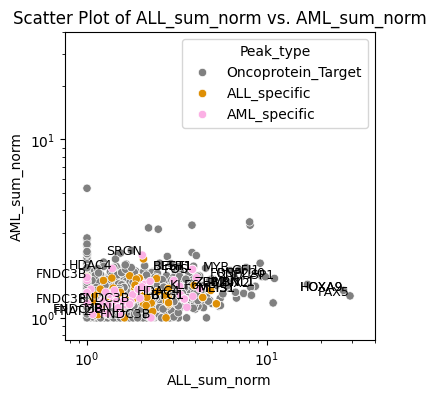

In [149]:
# Ensure the boxes are ordered
p148752_152985_DOT1L_Signal['Peak_type'] = pd.Categorical(p148752_152985_DOT1L_Signal['Peak_type'], categories=['Oncoprotein_Target', 'ALL_specific', 'AML_specific'], ordered=True)

plt.figure(figsize=(4, 4))

# Use the colorblind palette for colors
all_colors = sns.color_palette("colorblind")
colorblind_palette = {'Oncoprotein_Target': 'grey', 'ALL_specific': all_colors[1], 'AML_specific': all_colors[6]}

# Create the scatter plot
ax = sns.scatterplot(data=p148752_152985_DOT1L_Signal.sort_values(by='Peak_type', ascending=True), 
                     x='ALL_sum_norm_x', y='AML_sum_norm_x', hue='Peak_type', palette=colorblind_palette)
plt.xlabel('ALL_sum_norm')
plt.ylabel('AML_sum_norm')
plt.xlim(0.75, 40)  # Adjust these limits as needed
plt.ylim(0.75, 40)  # Adjust these limits as needed
plt.xscale('log')
plt.yscale('log')
plt.title('Scatter Plot of ALL_sum_norm vs. AML_sum_norm')
plt.legend(title='Peak_type')

# List of genes to annotate
genes_to_annotate = ['HOXA9', 'MEIS1', 'FOS', 'KLF6', 'DUSP1', 'RUNX2', 'MYB', 'SRGN', 'BEST1', 'FTH1',
                     'RNF220', 'ZEB2', 'FNDC3B', 'GFI1', 'MBNL1', 'FRAT2', 'HDAC4','BTG1','PAX5']

# Annotate the points
for index, row in p148752_152985_DOT1L_Signal.iterrows():
    for gene in genes_to_annotate:
        if gene in row['gene']:
            plt.text(row['ALL_sum_norm_x'], row['AML_sum_norm_x'], gene, fontsize=9, ha='right')
            break  # Only annotate with the first matching gene

#plt.savefig('Figure_Panels/Supplementary_Fig_5B.png', dpi=300, bbox_inches='tight')
plt.show()


In [69]:
#This code will quantify the Menin signal over different groups of Oncoprotein Peaks
#You can skip ahead and load the resulting table from p148752_152985_Menin_Signal.csv

def quantify_signal(bed_all, bed_aml, total_bed):
    # Read the bed_all and bed_aml files directly
    tbp_coverage_all = pd.read_csv(bed_all, sep='\t', header=None)
    tbp_coverage_all = tbp_coverage_all.iloc[:, :3]
    tbp_coverage_all.columns = ['chrom', 'start', 'stop']
    tbp_coverage_all['bp'] = tbp_coverage_all['stop'] - tbp_coverage_all['start']
    tbp_coverage_all = tbp_coverage_all["bp"].sum()
    
    tbp_coverage_aml = pd.read_csv(bed_aml, sep='\t', header=None)
    tbp_coverage_aml = tbp_coverage_aml.iloc[:, :3]
    tbp_coverage_aml.columns = ['chrom', 'start', 'stop']
    tbp_coverage_aml['bp'] = tbp_coverage_aml['stop'] - tbp_coverage_aml['start']
    tbp_coverage_aml = tbp_coverage_aml["bp"].sum()
    
    # Convert the DataFrame to BedTool
    Sample_bed_all = BedTool(bed_all)
    Sample_bed_aml = BedTool(bed_aml)

    # Intersect ALL bed file
    Sample_overlap_int_sum_all = total_bed.intersect(Sample_bed_all, wao=True)
    Sample_overlap_int_sum_all = pd.read_csv(Sample_overlap_int_sum_all.fn, sep='\t', header=None)
    Sample_overlap_int_sum_all.columns = ['chrom', 'start', 'stop', 'chrom2', 'start2', 'stop2', 'blah1', 'blah2', 'overlap']
    Sample_overlap_int_sum_all = Sample_overlap_int_sum_all.groupby(['chrom', 'start', 'stop']).agg({'overlap': 'sum'}).reset_index()
    Sample_overlap_int_sum_all.columns = ['chrom', 'start', 'stop', 'Sample_sum']
    Sample_overlap_int_sum_all['ALL_signal'] = (Sample_overlap_int_sum_all['Sample_sum'] * ((1/tbp_coverage_all)*1000000000)) + 1
    Sample_overlap_int_sum_all['peak_size'] = Sample_overlap_int_sum_all['stop'] - Sample_overlap_int_sum_all['start']
    Sample_overlap_int_sum_all['ALL_sum_norm'] = ((Sample_overlap_int_sum_all['Sample_sum'] / Sample_overlap_int_sum_all['peak_size']) * ((1/tbp_coverage_all)*1000000000)) + 1
    
    # Intersect AML bed file
    Sample_overlap_int_sum_all_bed = BedTool.from_dataframe(Sample_overlap_int_sum_all[['chrom', 'start', 'stop', 'Sample_sum', 'ALL_signal', 'peak_size', 'ALL_sum_norm']])
    
    Sample_overlap_int_sum_aml = Sample_overlap_int_sum_all_bed.intersect(Sample_bed_aml, wao=True)
    Sample_overlap_int_sum_aml = pd.read_csv(Sample_overlap_int_sum_aml.fn, sep='\t', header=None)
    Sample_overlap_int_sum_aml.columns = ['chrom', 'start', 'stop', 'ALL_sum', 'ALL_signal', 'peak_size', 'ALL_sum_norm', 'chrom2', 'start2', 'stop2', 'blah1', 'blah2', 'overlap']
    Sample_overlap_int_sum_aml = Sample_overlap_int_sum_aml.groupby(['chrom', 'start', 'stop', 'ALL_sum', 'ALL_signal', 'peak_size', 'ALL_sum_norm']).agg({'overlap': 'sum'}).reset_index()
    Sample_overlap_int_sum_aml.columns = ['chrom', 'start', 'stop', 'ALL_sum', 'ALL_signal', 'peak_size', 'ALL_sum_norm', 'Sample_sum']
    Sample_overlap_int_sum_aml['AML_signal'] = (Sample_overlap_int_sum_aml['Sample_sum'] * ((1/tbp_coverage_aml)*1000000000)) + 1
    Sample_overlap_int_sum_aml['AML_sum_norm'] = ((Sample_overlap_int_sum_aml['Sample_sum'] / Sample_overlap_int_sum_aml['peak_size']) * ((1/tbp_coverage_aml)*1000000000)) + 1
    Sample_overlap_int_sum_aml['Difference'] = Sample_overlap_int_sum_aml['ALL_sum_norm'] - Sample_overlap_int_sum_aml['AML_sum_norm']
    Sample_overlap_int_sum_aml = Sample_overlap_int_sum_aml.sort_values(by='Difference', ascending=True)
    
    return Sample_overlap_int_sum_aml

# Create OncoPeaks_WM_stat_bed

OncoPeaks_WM_stat_bed = OncoPeaks_WM_stat.copy()

# Move index to a column
OncoPeaks_WM_stat_bed.reset_index(inplace=True)

# Split the 'location' column into 'chrom', 'start', and 'stop'
OncoPeaks_WM_stat_bed[['chrom', 'start', 'stop']] = OncoPeaks_WM_stat_bed['index'].str.extract(r'(chr\w+):(\d+)-(\d+)')
OncoPeaks_WM_stat_bed = OncoPeaks_WM_stat_bed[['chrom', 'start', 'stop']]

# Convert 'start' and 'stop' columns to integers
OncoPeaks_WM_stat_bed['start'] = OncoPeaks_WM_stat_bed['start'].astype(int)
OncoPeaks_WM_stat_bed['stop'] = OncoPeaks_WM_stat_bed['stop'].astype(int)

# Convert the DataFrame to BED format
OncoPeaks_WM_stat_bed = BedTool.from_dataframe(OncoPeaks_WM_stat_bed[['chrom', 'start', 'stop']])
# Example usage
bed_all = 'DJ_Hs_148752_Menin_combined.bed'
bed_aml = 'DJ_Hs_152985_Menin_combined.bed'

LS2_ENL_Signal = quantify_signal(bed_all, bed_aml, OncoPeaks_WM_stat_bed)

# Step 1: Sort the dataframe
LS2_ENL_Signal = LS2_ENL_Signal.sort_values(by=['chrom', 'start', 'stop'])

# Convert to BED format
bed_LS2_ENL_Signal = BedTool.from_dataframe(LS2_ENL_Signal[['chrom', 'start', 'stop']])

# Assuming 'hg38_Gene_List_bed' is already defined and contains gene information for the hg38 assembly
# Intersect with the gene list to find overlapping genes
overlapping_genes = bed_LS2_ENL_Signal.intersect(hg38_Gene_List_bed, wao=True)

# Read the intersect result into a dataframe
df_overlapping_genes = pd.read_csv(overlapping_genes.fn, sep='\t', header=None)
df_overlapping_genes.columns = [
    'chrom', 'start', 'stop', 'chrom_2', 'start_2', 'stop_2', 
    'strand', 'gene', 'overlap'
]

# Create a 'Feature' column to group by
df_overlapping_genes['Feature'] = df_overlapping_genes['chrom'] + ':' + df_overlapping_genes['start'].astype(str) + '-' + df_overlapping_genes['stop'].astype(str)

# Expand the dataframe to include each gene as a separate row
df_overlapping_genes_expanded = df_overlapping_genes.assign(gene=df_overlapping_genes['gene'].str.split(', ')).explode('gene')

# Create a 'Feature' column in the original dataframe for merging
LS2_ENL_Signal['Feature'] = LS2_ENL_Signal['chrom'] + ':' + LS2_ENL_Signal['start'].astype(str) + '-' + LS2_ENL_Signal['stop'].astype(str)

# Merge the expanded genes dataframe with the original dataframe
result_LS2 = LS2_ENL_Signal.merge(df_overlapping_genes_expanded[['Feature', 'gene']], on='Feature', how='left')

# Drop the 'Feature' column if not needed
result_LS2 = result_LS2.drop(columns=['Feature'])

result_LS2 = result_LS2.sort_values(by='Difference', ascending=True)

# Corrected merge function for non-canonical AML
def merge_dataframes(LS2_ENL_Signal, result_279, result_NC):
    # Initialize 'Peak_type' column in LS2_ENL_Signal
    LS2_ENL_Signal['Peak_type'] = 'Oncoprotein_Target'
    
    # Ensure the Feature column is used for splitting
    for df in [result_279, result_NC]:
        df[['chrom', 'start', 'stop']] = df['Feature'].str.extract(r'(chr\w+):(\d+)-(\d+)')
        df['start'] = pd.to_numeric(df['start'], errors='coerce')
        df['stop'] = pd.to_numeric(df['stop'], errors='coerce')
    
    # Sorting dataframes
    LS2_ENL_Signal = LS2_ENL_Signal.sort_values(by=['chrom', 'start', 'stop'])
    result_279 = result_279.sort_values(by=['chrom', 'start', 'stop'])
    result_NC = result_NC.sort_values(by=['chrom', 'start', 'stop'])
    
    # Move 'chrom', 'start', 'stop' to the first columns in result_279 and result_NC
    cols = ['chrom', 'start', 'stop'] + [col for col in result_279.columns if col not in ['chrom', 'start', 'stop']]
    result_279 = result_279[cols]
    result_NC = result_NC[cols]
    
    # Expand the dataframes to include each gene as a separate row
    result_279_expanded = result_279.assign(gene_279=result_279['gene'].str.split(', ')).explode('gene_279')
    result_NC_expanded = result_NC.assign(gene_NC=result_NC['gene'].str.split(', ')).explode('gene_NC')
    
    # Merging LS2_ENL_Signal with result_279_expanded
    merged_df = pd.merge(LS2_ENL_Signal, result_279_expanded[['chrom', 'start', 'stop', 'gene_279']], on=['chrom', 'start', 'stop'], how='left')
    merged_df.loc[merged_df['gene_279'].notna(), 'Peak_type'] = 'ALL_specific'
    
    # Merging the result with result_NC_expanded
    merged_df = pd.merge(merged_df, result_NC_expanded[['chrom', 'start', 'stop', 'gene_NC']], on=['chrom', 'start', 'stop'], how='left')
    merged_df.loc[merged_df['gene_NC'].notna(), 'Peak_type'] = 'AML_specific'
    
    return merged_df

# Assuming LS2_ENL_Signal, result_279, and result_NC are already defined
# Calling the function to merge dataframes
final_merged_df = merge_dataframes(LS2_ENL_Signal, result_279, result_NC)

# Assuming final_merged_df and result_LS2 are already defined
# Ensure the 'chrom', 'start', and 'stop' columns are in the correct data type
final_merged_df['start'] = pd.to_numeric(final_merged_df['start'], errors='coerce')
final_merged_df['stop'] = pd.to_numeric(final_merged_df['stop'], errors='coerce')
result_LS2['start'] = pd.to_numeric(result_LS2['start'], errors='coerce')
result_LS2['stop'] = pd.to_numeric(result_LS2['stop'], errors='coerce')

# Merge the final_merged_df with result_LS2
p148752_152985_Menin_Signal = pd.merge(final_merged_df, result_LS2, on=['chrom', 'start', 'stop'], how='left')

/tmp/ipykernel_101832/937827487.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['chrom', 'start', 'stop']] = df['Feature'].str.extract(r'(chr\w+):(\d+)-(\d+)')
/tmp/ipykernel_101832/937827487.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start'] = pd.to_numeric(df['start'], errors='coerce')
/tmp/ipykernel_101832/937827487.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [71]:
#p148752_152985_Menin_Signal.to_csv('p148752_152985_Menin_Signal.csv', index=True)
p148752_152985_Menin_Signal = pd.read_csv("p148752_152985_Menin_Signal.csv", sep=',', index_col=0)

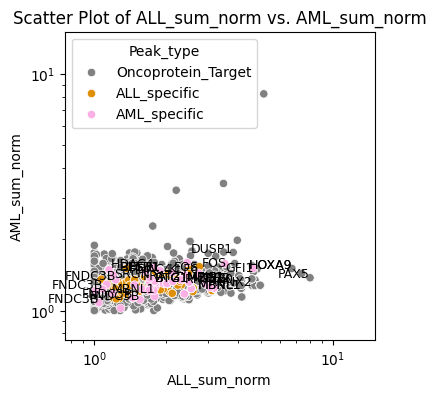

In [74]:
# Ensure the boxes are ordered
p148752_152985_Menin_Signal['Peak_type'] = pd.Categorical(p148752_152985_Menin_Signal['Peak_type'], categories=['Oncoprotein_Target', 'ALL_specific', 'AML_specific'], ordered=True)

plt.figure(figsize=(4, 4))

# Use the colorblind palette for colors
all_colors = sns.color_palette("colorblind")
colorblind_palette = {'Oncoprotein_Target': 'grey', 'ALL_specific': all_colors[1], 'AML_specific': all_colors[6]}

# Create the scatter plot
ax = sns.scatterplot(data=p148752_152985_Menin_Signal.sort_values(by='Peak_type', ascending=True), 
                     x='ALL_sum_norm_x', y='AML_sum_norm_x', hue='Peak_type', palette=colorblind_palette)
plt.xlabel('ALL_sum_norm')
plt.ylabel('AML_sum_norm')
plt.xlim(0.75, 15)  # Adjust these limits as needed
plt.ylim(0.75, 15)  # Adjust these limits as needed
plt.xscale('log')
plt.yscale('log')
plt.title('Scatter Plot of ALL_sum_norm vs. AML_sum_norm')
plt.legend(title='Peak_type')

# List of genes to annotate
genes_to_annotate = ['HOXA9', 'MEIS1', 'FOS', 'KLF6', 'DUSP1', 'RUNX2', 'MYB', 'SRGN', 'BEST1', 'FTH1',
                     'RNF220', 'ZEB2', 'FNDC3B', 'GFI1', 'MBNL1', 'FRAT2', 'HDAC4','BTG1','PAX5']

# Annotate the points
for index, row in p148752_152985_Menin_Signal.iterrows():
    for gene in genes_to_annotate:
        if gene in row['gene']:
            plt.text(row['ALL_sum_norm_x'], row['AML_sum_norm_x'], gene, fontsize=9, ha='right')
            break  # Only annotate with the first matching gene

#plt.savefig('Figure_Panels/Fig_6E.png', dpi=300, bbox_inches='tight')
plt.show()


In [48]:
#This code will quantify the ENL signal from multipel samples over different groups of Oncoprotein Peaks
#You can skip ahead and load the resulting table from ENL_OncoPeak_Quant.csv

def quantify_signal(sample_bed, total_bed):
    # Read the bed_all and bed_aml files directly
    sample_bed = pd.read_csv(sample_bed, sep='\t', header=None)
    sample_bed = sample_bed.iloc[:, :3]
    sample_bed_3column = sample_bed.iloc[:, :3]
    tbp_coverage = sample_bed_3column
    tbp_coverage.columns = ['chrom', 'start', 'stop']
    tbp_coverage['bp'] = tbp_coverage['stop'] - tbp_coverage['start']
    tbp_coverage = tbp_coverage["bp"].sum()
    
    # Convert the DataFrame to BedTool
    Sample_bed = BedTool.from_dataframe(sample_bed_3column)
    
    # Intersect ALL bed file
    Sample_overlap_int_sum = total_bed.intersect(Sample_bed, wao=True)
    Sample_overlap_int_sum = pd.read_csv(Sample_overlap_int_sum.fn, sep='\t', header=None)
    Sample_overlap_int_sum.columns = ['chrom', 'start', 'stop', 'chrom2', 'start2', 'stop2', 'blah1', 'overlap'] # 'blah2', 
    Sample_overlap_int_sum = Sample_overlap_int_sum.groupby(['chrom', 'start', 'stop']).agg({'overlap': 'sum'}).reset_index()
    Sample_overlap_int_sum.columns = ['chrom', 'start', 'stop', 'Sample_sum']
    Sample_overlap_int_sum['Sample_signal'] = (Sample_overlap_int_sum['Sample_sum'] * ((1/tbp_coverage)*1000000000)) + 1
    Sample_overlap_int_sum['peak_size'] = Sample_overlap_int_sum['stop'] - Sample_overlap_int_sum['start']
    Sample_overlap_int_sum['Sample_sum_norm'] = ((Sample_overlap_int_sum['Sample_sum'] / Sample_overlap_int_sum['peak_size']) * ((1/tbp_coverage)*1000000000)) + 1
    
    return Sample_overlap_int_sum[['chrom', 'start', 'stop', 'Sample_sum_norm']]

def add_peak_type(Sample_overlap_int_sum, result_279, result_NC):
    # Initialize 'Peak_type' column in Sample_overlap_int_sum
    Sample_overlap_int_sum['Peak_type'] = 'Oncoprotein_Target'
    
    # Ensure the Feature column is used for splitting
    for df in [result_279, result_NC]:
        df[['chrom', 'start', 'stop']] = df['Feature'].str.extract(r'(chr\w+):(\d+)-(\d+)')
        df['start'] = pd.to_numeric(df['start'], errors='coerce')
        df['stop'] = pd.to_numeric(df['stop'], errors='coerce')
    
    # Sorting dataframes
    Sample_overlap_int_sum = Sample_overlap_int_sum.sort_values(by=['chrom', 'start', 'stop'])
    result_279 = result_279.sort_values(by=['chrom', 'start', 'stop'])
    result_NC = result_NC.sort_values(by=['chrom', 'start', 'stop'])
    
    # Move 'chrom', 'start', 'stop' to the first columns in result_279 and result_NC
    cols_279 = ['chrom', 'start', 'stop'] + [col for col in result_279.columns if col not in ['chrom', 'start', 'stop']]
    cols_NC = ['chrom', 'start', 'stop'] + [col for col in result_NC.columns if col not in ['chrom', 'start', 'stop']]
    result_279 = result_279[cols_279]
    result_NC = result_NC[cols_NC]
    
    # Merging Sample_overlap_int_sum with result_279
    merged_df = pd.merge(Sample_overlap_int_sum, result_279, on=['chrom', 'start', 'stop'], how='left')
    
    # Rename 'gene' to 'gene_279'
    merged_df.rename(columns={'gene': 'gene_279'}, inplace=True)
    merged_df.loc[merged_df['gene_279'].notna(), 'Peak_type'] = 'ALL_specific'
    
    # Merging the result with result_NC
    merged_df = pd.merge(merged_df, result_NC, on=['chrom', 'start', 'stop'], how='left')
    
    # Rename 'gene' to 'gene_NC'
    merged_df.rename(columns={'gene': 'gene_NC'}, inplace=True)
    merged_df.loc[merged_df['gene_NC'].notna(), 'Peak_type'] = 'NC_specific'
    
    return merged_df

# Create OncoPeaks_WM_stat_bed

OncoPeaks_WM_stat_bed = OncoPeaks_WM_stat.copy()

# Move index to a column
OncoPeaks_WM_stat_bed.reset_index(inplace=True)

# Split the 'location' column into 'chrom', 'start', and 'stop'
OncoPeaks_WM_stat_bed[['chrom', 'start', 'stop']] = OncoPeaks_WM_stat_bed['index'].str.extract(r'(chr\w+):(\d+)-(\d+)')
OncoPeaks_WM_stat_bed = OncoPeaks_WM_stat_bed[['chrom', 'start', 'stop']]

# Convert 'start' and 'stop' columns to integers
OncoPeaks_WM_stat_bed['start'] = OncoPeaks_WM_stat_bed['start'].astype(int)
OncoPeaks_WM_stat_bed['stop'] = OncoPeaks_WM_stat_bed['stop'].astype(int)

# Convert the DataFrame to BED format
OncoPeaks_WM_stat_bed = BedTool.from_dataframe(OncoPeaks_WM_stat_bed[['chrom', 'start', 'stop']])

# Usage example
sample_bed = 'DJ_Hs_p279_ENL_combined.bed'
total_bed = OncoPeaks_WM_stat_bed

Sample_overlap_int_sum = quantify_signal(sample_bed, total_bed)
final_merged_df = add_peak_type(Sample_overlap_int_sum, result_279, result_NC)

DJ_Hs_p279_ENL_Quant = final_merged_df
DJ_Hs_p279_ENL_Quant['Sample'] = 'p279'

# Usage example
sample_bed = 'DJ_Hs_p318_ENL_combined.bed'
total_bed = OncoPeaks_WM_stat_bed

Sample_overlap_int_sum = quantify_signal(sample_bed, total_bed)
final_merged_df = add_peak_type(Sample_overlap_int_sum, result_279, result_NC)

DJ_Hs_p318_ENL_Quant = final_merged_df
DJ_Hs_p318_ENL_Quant['Sample'] = 'p318'


# Usage example
sample_bed = 'DJ_Hs_148752_ENL_combined.bed'
total_bed = OncoPeaks_WM_stat_bed

Sample_overlap_int_sum = quantify_signal(sample_bed, total_bed)
final_merged_df = add_peak_type(Sample_overlap_int_sum, result_279, result_NC)

DJ_Hs_148752_ENL_Quant = final_merged_df
DJ_Hs_148752_ENL_Quant['Sample'] = '148752'


# Usage example
sample_bed = 'DJ_Hs_152985_ENL_combined.bed'
total_bed = OncoPeaks_WM_stat_bed

Sample_overlap_int_sum = quantify_signal(sample_bed, total_bed)
final_merged_df = add_peak_type(Sample_overlap_int_sum, result_279, result_NC)

DJ_Hs_152985_ENL_Quant = final_merged_df
DJ_Hs_152985_ENL_Quant['Sample'] = '152985'

ENL_OncoPeak_Quant = pd.concat((DJ_Hs_p279_ENL_Quant, DJ_Hs_p318_ENL_Quant, DJ_Hs_148752_ENL_Quant, DJ_Hs_152985_ENL_Quant))

/tmp/ipykernel_101832/657542668.py:19: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  Sample_overlap_int_sum = pd.read_csv(Sample_overlap_int_sum.fn, sep='\t', header=None)
/tmp/ipykernel_101832/657542668.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['chrom', 'start', 'stop']] = df['Feature'].str.extract(r'(chr\w+):(\d+)-(\d+)')
/tmp/ipykernel_101832/657542668.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start'] = pd.to_numeric(df

In [150]:
#ENL_OncoPeak_Quant.to_csv('ENL_OncoPeak_Quant.csv', index=True)
ENL_OncoPeak_Quant = pd.read_csv("ENL_OncoPeak_Quant.csv", sep=',', index_col=0)

Number of p-values: 12
Sample: p279, Pair: ('Oncoprotein_Target', 'ALL_specific'), Corrected p-value: 6.659377490295559e-14
Sample: p279, Pair: ('Oncoprotein_Target', 'NC_specific'), Corrected p-value: 0.06661528503193073
Sample: p279, Pair: ('ALL_specific', 'NC_specific'), Corrected p-value: 7.765889149441047e-05
Sample: p318, Pair: ('Oncoprotein_Target', 'ALL_specific'), Corrected p-value: 1.0
Sample: p318, Pair: ('Oncoprotein_Target', 'NC_specific'), Corrected p-value: 1.002614406159085e-19
Sample: p318, Pair: ('ALL_specific', 'NC_specific'), Corrected p-value: 1.187183046398144e-14
Sample: 148752, Pair: ('Oncoprotein_Target', 'ALL_specific'), Corrected p-value: 0.0001292233861197768
Sample: 148752, Pair: ('Oncoprotein_Target', 'NC_specific'), Corrected p-value: 0.0001325260309478547
Sample: 148752, Pair: ('ALL_specific', 'NC_specific'), Corrected p-value: 1.0
Sample: 152985, Pair: ('Oncoprotein_Target', 'ALL_specific'), Corrected p-value: 1.0
Sample: 152985, Pair: ('Oncoprotein_Tar

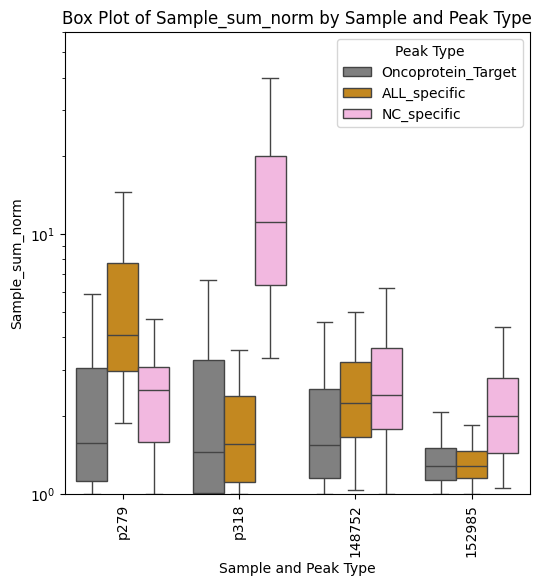

In [151]:
# Ensure the Peak_type is ordered correctly
ENL_OncoPeak_Quant['Peak_type'] = pd.Categorical(
    ENL_OncoPeak_Quant['Peak_type'], 
    categories=['Oncoprotein_Target', 'ALL_specific', 'NC_specific'], 
    ordered=True
)

plt.figure(figsize=(6, 6))

# Use the colorblind palette for colors
all_colors = sns.color_palette("colorblind")
colorblind_palette = {'Oncoprotein_Target': 'grey', 'ALL_specific': all_colors[1], 'NC_specific': all_colors[6]}

# Create the boxplot without outliers
ax = sns.boxplot(
    data=ENL_OncoPeak_Quant, x='Sample', y='Sample_sum_norm', 
    hue='Peak_type', palette=colorblind_palette, showfliers=False
)

plt.xlabel('Sample and Peak Type')
plt.ylabel('Sample_sum_norm')
plt.yscale('log')
plt.ylim(1, 60)  # Log scale means the lower limit can't be 0
plt.title('Box Plot of Sample_sum_norm by Sample and Peak Type')
plt.legend(title='Peak Type')
plt.xticks(rotation=90)

# Define the pairs for comparison
box_pairs = [
    (("p279", "Oncoprotein_Target"), ("p279", "ALL_specific")),
    (("p279", "Oncoprotein_Target"), ("p279", "NC_specific")),
    (("p279", "ALL_specific"), ("p279", "NC_specific")),
    
    (("p318", "Oncoprotein_Target"), ("p318", "ALL_specific")),
    (("p318", "Oncoprotein_Target"), ("p318", "NC_specific")),
    (("p318", "ALL_specific"), ("p318", "NC_specific")),
    
    (("148752", "Oncoprotein_Target"), ("148752", "ALL_specific")),
    (("148752", "Oncoprotein_Target"), ("148752", "NC_specific")),
    (("148752", "ALL_specific"), ("148752", "NC_specific")),
    
    (("152985", "Oncoprotein_Target"), ("152985", "ALL_specific")),
    (("152985", "Oncoprotein_Target"), ("152985", "NC_specific")),
    (("152985", "ALL_specific"), ("152985", "NC_specific")),
]

# Get the unique samples
samples = ENL_OncoPeak_Quant['Sample'].unique()

# Calculate p-values for each pair using Mann-Whitney U Test
p_values = []
pairwise_comparisons = []
for sample in samples:
    data = ENLOncoPeak_Quant[ENL_OncoPeak_Quant['Sample'] == sample]
    if len(data) > 0:
        pairs = [
            ('Oncoprotein_Target', 'ALL_specific'),
            ('Oncoprotein_Target', 'NC_specific'),
            ('ALL_specific', 'NC_specific')
        ]
        for pair in pairs:
            group1 = data[data['Peak_type'] == pair[0]]['Sample_sum_norm']
            group2 = data[data['Peak_type'] == pair[1]]['Sample_sum_norm']
            if len(group1) > 0 and len(group2) > 0:
                stat, p_value = mannwhitneyu(group1, group2)
                p_values.append(p_value)
                pairwise_comparisons.append((sample, pair))
            else:
                p_values.append(1)  # No significant difference

# Debugging: Print p-values length before correction
print(f"Number of p-values: {len(p_values)}")

# Check if p_values is empty to avoid division by zero
if len(p_values) > 0:
    # Correct for multiple comparisons
    reject, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')

    # Display results
    for i, (sample, pair) in enumerate(pairwise_comparisons):
        print(f"Sample: {sample}, Pair: {pair}, Corrected p-value: {corrected_p_values[i]}")

# Add statistical annotation (if desired)
# Note: You need to adapt the annotation part based on your test results and specific needs
# add_stat_annotation(...)

#plt.savefig('Figure_Panels/Fig_6G.png', dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_101832/2766140769.py:62: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(


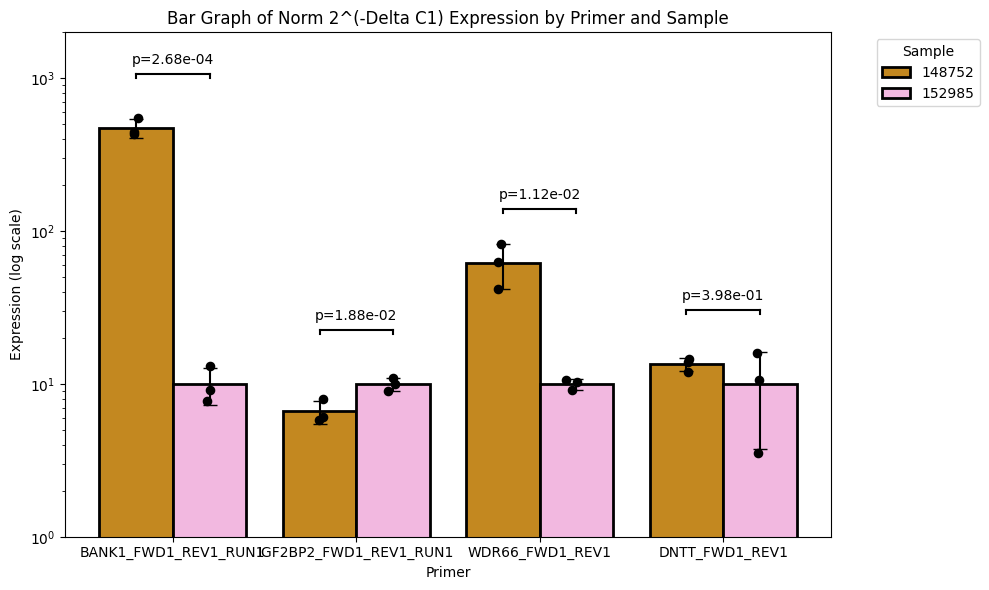

0  Sample                  Primer  Norm 2^(-Delta C1) Rep1  \
2  148752    BANK1_FWD1_REV1_RUN1               550.379859   
1  152985    BANK1_FWD1_REV1_RUN1                 7.766299   
4  148752  IGF2BP2_FWD1_REV1_RUN1                 5.802534   
3  152985  IGF2BP2_FWD1_REV1_RUN1                 9.990915   
6  148752         WDR66_FWD1_REV1                62.511346   
5  152985         WDR66_FWD1_REV1                10.628030   
8  148752          DNTT_FWD1_REV1                11.955690   
7  152985          DNTT_FWD1_REV1                15.944689   

0  Norm 2^(-Delta C1) Rep2  Norm 2^(-Delta C1) Rep3 Delta Delta Cq Expression  \
2               428.969565               443.122758               47.41572547   
1                13.072397                 9.161313                         1   
4                 6.056135                 7.949199               0.660262108   
3                11.002749                 9.006343                         1   
6                82.289987          

In [152]:
# Load the CSV file
X = pd.read_csv("152985_148752_QPCR_Oncoprotein_Table.csv", sep=',', index_col=0, header=None)

# Transpose the dataframe
X = X.transpose()
X = X.dropna(axis=0, how='all')

# List of columns to be converted to numeric
columns_to_convert = ['Norm 2^(-Delta C1) Rep1', 'Norm 2^(-Delta C1) Rep2', 'Norm 2^(-Delta C1) Rep3']

# Apply pd.to_numeric to specific columns if they exist
for col in columns_to_convert:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop rows with all NaN values
X = X.dropna(axis=0, how='all')

# Multiply all relevant values by 10 to adjust for log scale visualization
X[columns_to_convert] *= 10

# Filter rows based on 'Primer' column (assuming 'Primer' column contains strings to filter by)
primers_to_keep = ['BANK1_FWD1_REV1_RUN1', 'IGF2BP2_FWD1_REV1_RUN1', 'WDR66_FWD1_REV1', 'DNTT_FWD1_REV1']  # Replace with actual Primer values you want to keep

# Filter rows based on the specified 'Primer' values
X_BALL = X[X['Primer'].isin(primers_to_keep)].copy()

# Set the order of the 'Primer' column
X_BALL['Primer'] = pd.Categorical(X_BALL['Primer'], categories=primers_to_keep, ordered=True)

# Reorder the rows within each primer set
X_BALL['Sample'] = pd.Categorical(X_BALL['Sample'], categories=['148752', '152985'], ordered=True)
X_BALL = X_BALL.sort_values(['Primer', 'Sample'])

# Melt the dataframe to have replicates as rows
df_melted = pd.melt(X_BALL, id_vars=['Sample', 'Primer'], 
                    value_vars=columns_to_convert,
                    var_name='Replicate', value_name='Expression')

# Calculate means and standard deviations based on individual replicates
df_means = df_melted.groupby(['Sample', 'Primer'])['Expression'].mean().reset_index()
df_std = df_melted.groupby(['Sample', 'Primer'])['Expression'].std().reset_index()

# Perform t-test between samples based on replicate values for each primer group
p_values = []
for primer in primers_to_keep:
    group = df_melted[df_melted['Primer'] == primer]
    p148752_values = group[group['Sample'] == '148752']['Expression']
    p152985_values = group[group['Sample'] == '152985']['Expression']

    # Perform t-test using individual replicate values
    t_stat, p_val = ttest_ind(p148752_values, p152985_values)
    p_values.append((primer, p_val))

# Set the colors for the bars
all_colors = sns.color_palette("colorblind")
colorblind_2 = [all_colors[1], all_colors[6]]  # Colors for 148752 and 152985
custom_palette = sns.color_palette(colorblind_2)

# Create the bar graph with error bars
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_means, 
    x='Primer', 
    y='Expression', 
    hue='Sample', 
    palette=custom_palette, 
    edgecolor='black', 
    linewidth=2, 
    capsize=0.1,
    ci=None  # Disable default confidence intervals
)

# Adjust the x positions of the bars and error bars
bar_width = barplot.patches[0].get_width()  # Width of a single bar
grouped_bars = len(['148752', '152985'])  # Number of bars per group (Primer)

# Add error bars manually by iterating through both Primer and Sample
for i, primer in enumerate(primers_to_keep):
    for j, sample in enumerate(['148752', '152985']):
        # Extract the row matching the current Primer and Sample
        row = df_means[(df_means['Primer'] == primer) & (df_means['Sample'] == sample)]
        std_val = df_std[(df_std['Primer'] == primer) & (df_std['Sample'] == sample)]['Expression'].values[0]
        
        if not row.empty:
            # Extract mean height
            height = row['Expression'].values[0]
            
            # Calculate x position for each bar in the group
            bar_x = i + (j - (grouped_bars - 1) / 2) * bar_width

            # Add the error bar
            plt.errorbar(bar_x, height, yerr=std_val, fmt='none', ecolor='black', capsize=5)

            # Plot individual black dots for replicates, offset by the same bar_x logic
            replicate_values = df_melted[(df_melted['Primer'] == primer) & (df_melted['Sample'] == sample)]['Expression']
            jittered_x = np.random.normal(loc=bar_x, scale=0.02, size=len(replicate_values))  # Slight jitter for replicates
            plt.scatter(jittered_x, replicate_values, color='black', s=35, zorder=3)  # s=35 for smaller black dots

# Add p-values above the bars with brackets, raised higher on the y-axis
for i, (primer, p_val) in enumerate(p_values):
    x = i
    y = df_means[df_means['Primer'] == primer]['Expression'].max() * 2.5  # Raised higher
    plt.text(x, y, f'p={p_val:.2e}', ha='center', va='bottom', fontsize=10)
    plt.plot([x-0.2, x+0.2], [y*0.9, y*0.9], color='black', linewidth=1.5)
    plt.plot([x-0.2, x-0.2], [y*0.85, y*0.9], color='black', linewidth=1.5)
    plt.plot([x+0.2, x+0.2], [y*0.85, y*0.9], color='black', linewidth=1.5)

# Set the y-axis to a log scale and adjust the limit
plt.yscale('log')
plt.ylim(1, 2000)

plt.xlabel('Primer')
plt.ylabel('Expression (log scale)')
plt.title('Bar Graph of Norm 2^(-Delta C1) Expression by Primer and Sample')
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
# plt.savefig('Figure_Panels/Supplementary_Fig_5C.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Display the first 50 rows of the dataframe
print(X_BALL.head(50))


/tmp/ipykernel_101832/796120818.py:62: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(


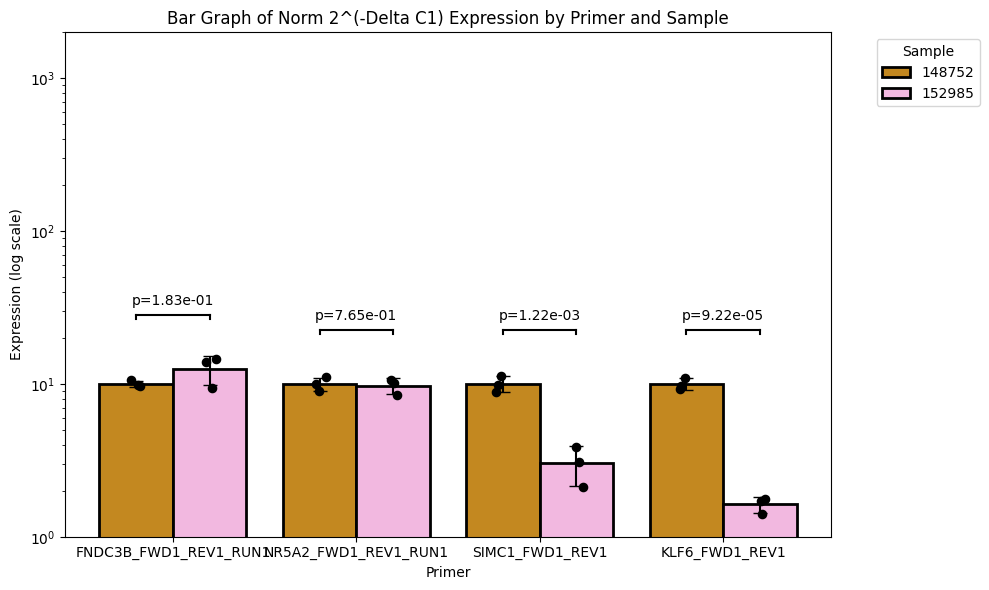

0   Sample                 Primer  Norm 2^(-Delta C1) Rep1  \
10  148752  FNDC3B_FWD1_REV1_RUN1                10.561784   
9   152985  FNDC3B_FWD1_REV1_RUN1                13.831050   
12  148752   NR5A2_FWD1_REV1_RUN1                11.025269   
11  152985   NR5A2_FWD1_REV1_RUN1                10.540261   
14  148752        SIMC1_FWD1_REV1                11.267209   
13  152985        SIMC1_FWD1_REV1                 3.880733   
16  148752         KLF6_FWD1_REV1                11.004025   
15  152985         KLF6_FWD1_REV1                 1.762799   

0   Norm 2^(-Delta C1) Rep2  Norm 2^(-Delta C1) Rep3  \
10                 9.639186                 9.799029   
9                 14.479902                 9.441397   
12                 9.921881                 9.052834   
11                10.196178                 8.428988   
14                 8.910296                 9.822491   
13                 3.076553                 2.130579   
16                 9.289405                 9.706

In [154]:
# Load the CSV file
X = pd.read_csv("152985_148752_QPCR_Oncoprotein_Table.csv", sep=',', index_col=0, header=None)

# Transpose the dataframe
X = X.transpose()
X = X.dropna(axis=0, how='all')

# List of columns to be converted to numeric
columns_to_convert = ['Norm 2^(-Delta C1) Rep1', 'Norm 2^(-Delta C1) Rep2', 'Norm 2^(-Delta C1) Rep3']

# Apply pd.to_numeric to specific columns if they exist
for col in columns_to_convert:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop rows with all NaN values
X = X.dropna(axis=0, how='all')

# Multiply all relevant values by 10 to adjust for log scale visualization
X[columns_to_convert] *= 10

# Filter rows based on 'Primer' column (assuming 'Primer' column contains strings to filter by)
primers_to_keep = ['FNDC3B_FWD1_REV1_RUN1', 'NR5A2_FWD1_REV1_RUN1', 'SIMC1_FWD1_REV1', 'KLF6_FWD1_REV1']  # Replace with actual Primer values you want to keep

# Filter rows based on the specified 'Primer' values
X_BALL = X[X['Primer'].isin(primers_to_keep)].copy()

# Set the order of the 'Primer' column
X_BALL['Primer'] = pd.Categorical(X_BALL['Primer'], categories=primers_to_keep, ordered=True)

# Reorder the rows within each primer set
X_BALL['Sample'] = pd.Categorical(X_BALL['Sample'], categories=['148752', '152985'], ordered=True)
X_BALL = X_BALL.sort_values(['Primer', 'Sample'])

# Melt the dataframe to have replicates as rows
df_melted = pd.melt(X_BALL, id_vars=['Sample', 'Primer'], 
                    value_vars=columns_to_convert,
                    var_name='Replicate', value_name='Expression')

# Calculate means and standard deviations based on individual replicates
df_means = df_melted.groupby(['Sample', 'Primer'])['Expression'].mean().reset_index()
df_std = df_melted.groupby(['Sample', 'Primer'])['Expression'].std().reset_index()

# Perform t-test between samples based on replicate values for each primer group
p_values = []
for primer in primers_to_keep:
    group = df_melted[df_melted['Primer'] == primer]
    p148752_values = group[group['Sample'] == '148752']['Expression']
    p152985_values = group[group['Sample'] == '152985']['Expression']

    # Perform t-test using individual replicate values
    t_stat, p_val = ttest_ind(p148752_values, p152985_values)
    p_values.append((primer, p_val))

# Set the colors for the bars
all_colors = sns.color_palette("colorblind")
colorblind_2 = [all_colors[1], all_colors[6]]  # Colors for 148752 and 152985
custom_palette = sns.color_palette(colorblind_2)

# Create the bar graph with error bars
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_means, 
    x='Primer', 
    y='Expression', 
    hue='Sample', 
    palette=custom_palette, 
    edgecolor='black', 
    linewidth=2, 
    capsize=0.1,
    ci=None  # Disable default confidence intervals
)

# Adjust the x positions of the bars and error bars
bar_width = barplot.patches[0].get_width()  # Width of a single bar
grouped_bars = len(['148752', '152985'])  # Number of bars per group (Primer)

# Add error bars manually by iterating through both Primer and Sample
for i, primer in enumerate(primers_to_keep):
    for j, sample in enumerate(['148752', '152985']):
        # Extract the row matching the current Primer and Sample
        row = df_means[(df_means['Primer'] == primer) & (df_means['Sample'] == sample)]
        std_val = df_std[(df_std['Primer'] == primer) & (df_std['Sample'] == sample)]['Expression'].values[0]
        
        if not row.empty:
            # Extract mean height
            height = row['Expression'].values[0]
            
            # Calculate x position for each bar in the group
            bar_x = i + (j - (grouped_bars - 1) / 2) * bar_width

            # Add the error bar
            plt.errorbar(bar_x, height, yerr=std_val, fmt='none', ecolor='black', capsize=5)

            # Plot individual black dots for replicates, offset by the same bar_x logic
            replicate_values = df_melted[(df_melted['Primer'] == primer) & (df_melted['Sample'] == sample)]['Expression']
            jittered_x = np.random.normal(loc=bar_x, scale=0.02, size=len(replicate_values))  # Slight jitter for replicates
            plt.scatter(jittered_x, replicate_values, color='black', s=35, zorder=3)  # s=35 for smaller black dots

# Add p-values above the bars with brackets, raised higher on the y-axis
for i, (primer, p_val) in enumerate(p_values):
    x = i
    y = df_means[df_means['Primer'] == primer]['Expression'].max() * 2.5  # Raised higher
    plt.text(x, y, f'p={p_val:.2e}', ha='center', va='bottom', fontsize=10)
    plt.plot([x-0.2, x+0.2], [y*0.9, y*0.9], color='black', linewidth=1.5)
    plt.plot([x-0.2, x-0.2], [y*0.85, y*0.9], color='black', linewidth=1.5)
    plt.plot([x+0.2, x+0.2], [y*0.85, y*0.9], color='black', linewidth=1.5)

# Set the y-axis to a log scale and adjust the limit
plt.yscale('log')
plt.ylim(1, 2000)

plt.xlabel('Primer')
plt.ylabel('Expression (log scale)')
plt.title('Bar Graph of Norm 2^(-Delta C1) Expression by Primer and Sample')
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
#plt.savefig('Figure_Panels/Supplementary_Fig_5D.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Display the first 50 rows of the dataframe
print(X_BALL.head(50))


/tmp/ipykernel_101832/3539636953.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(
/tmp/ipykernel_101832/3539636953.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


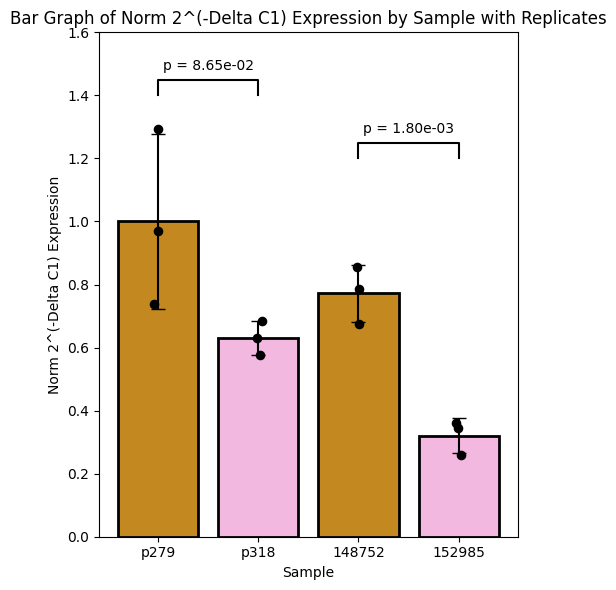

In [100]:
# Load the CSV file
X = pd.read_csv("KMT2C_QPCR_Oncoprotein_Replicates.csv", sep=',', index_col=0, header=None)

# Transpose the dataframe
X = X.dropna(axis=0, how='all')
X = X.transpose()

# Rename the columns to reflect replicate structure
X.columns = ['Sample', 'Primer', 'Norm 2^(-Delta C1) Rep1', 'Norm 2^(-Delta C1) Rep2', 'Norm 2^(-Delta C1) Rep3', 'Delta Delta Cq Expression', 'Delta Delta Cq St. Deviation', 'Oncoprotein Score']

# Convert replicates to numeric
X[['Norm 2^(-Delta C1) Rep1', 'Norm 2^(-Delta C1) Rep2', 'Norm 2^(-Delta C1) Rep3']] = X[['Norm 2^(-Delta C1) Rep1', 'Norm 2^(-Delta C1) Rep2', 'Norm 2^(-Delta C1) Rep3']].apply(pd.to_numeric)

# Melt the dataframe to have replicates as rows
df_melted = pd.melt(X, id_vars=['Sample', 'Primer'], 
                    value_vars=['Norm 2^(-Delta C1) Rep1', 'Norm 2^(-Delta C1) Rep2', 'Norm 2^(-Delta C1) Rep3'],
                    var_name='Replicate', value_name='Expression')

# Ensure that 'Sample' is treated as a categorical variable with the correct order
df_melted['Sample'] = pd.Categorical(df_melted['Sample'], categories=['p279', 'p318', '148752', '152985'], ordered=True)

# Calculate means and standard deviations based on individual replicates
df_means = df_melted.groupby('Sample')['Expression'].mean().reset_index()
df_std = df_melted.groupby('Sample')['Expression'].std().reset_index()

# Perform t-test between samples based on replicate values
p_values = []

# Define the pairs for t-tests
sample_pairs = [('p279', 'p318'), ('148752', '152985')]

for sample1, sample2 in sample_pairs:
    values1 = df_melted[df_melted['Sample'] == sample1]['Expression']
    values2 = df_melted[df_melted['Sample'] == sample2]['Expression']
    t_stat, p_val = ttest_ind(values1, values2)
    p_values.append(p_val)

# Set the colors for the bars
all_colors = sns.color_palette("colorblind")
colorblind_2 = [all_colors[1], all_colors[6]]  # Colors for p279/p318 and 148752/152985
custom_palette = sns.color_palette(colorblind_2 * 2)

# Order the samples for plotting
order = ['p279', 'p318', '148752', '152985']

# Create the bar graph with error bars
plt.figure(figsize=(5, 6))
barplot = sns.barplot(
    data=df_means, 
    x='Sample', 
    y='Expression', 
    palette=custom_palette, 
    edgecolor='black', 
    linewidth=2, 
    capsize=0.1,
    ci=None,  # Disable default confidence intervals
    order=order  # Explicitly set the order here
)

# Adjust the x positions of the bars and error bars
bar_width = barplot.patches[0].get_width()  # Width of a single bar

# Add error bars manually based on calculated standard deviation
for i, sample in enumerate(order):
    mean_value = df_means[df_means['Sample'] == sample]['Expression'].values[0]
    std_dev = df_std[df_std['Sample'] == sample]['Expression'].values[0]
    plt.errorbar(x=i, y=mean_value, yerr=std_dev, fmt='none', ecolor='black', capsize=5)

# Overlay individual replicates as black dots with slight jitter
for i, sample in enumerate(order):
    replicate_values = df_melted[df_melted['Sample'] == sample]['Expression']
    jittered_x = np.random.normal(loc=i, scale=0.02, size=len(replicate_values))  # Slight jitter for replicates
    plt.scatter(jittered_x, replicate_values, color='black', s=35, zorder=3)

# Add p-values above the bars
# p-value for p279 vs p318
x1, x2 = 0, 1
y1, h1, col = max(df_means['Expression']) + 0.4, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y1, y1 + h1, y1 + h1, y1], lw=1.5, c=col)
plt.text((x1 + x2) * .5, y1 + h1 + 0.02, f"p = {p_values[0]:.2e}", ha='center', va='bottom', color=col)

# p-value for 148752 vs 152985
x1, x2 = 2, 3
y2 = max(df_means['Expression']) + 0.2
plt.plot([x1, x1, x2, x2], [y2, y2 + h1, y2 + h1, y2], lw=1.5, c=col)
plt.text((x1 + x2) * .5, y2 + h1 + 0.02, f"p = {p_values[1]:.2e}", ha='center', va='bottom', color=col)

# Customize the plot
plt.ylim(0, max(df_means['Expression']) + 0.6)  # Adjust ylim to fit the text
plt.xlabel('Sample')
plt.ylabel('Norm 2^(-Delta C1) Expression')
plt.title('Bar Graph of Norm 2^(-Delta C1) Expression by Sample with Replicates')
plt.tight_layout()

# Save the plot if needed
#plt.savefig('Figure_Panels/Fig_6I.png')

plt.show()


T-test between MEN1_Non_Responder_RNA_Seq_P9 and MEN1_Non_Responder_RNA_Seq_PDX4: p-value = 0.0086207820
T-test between MEN1_Non_Responder_RNA_Seq_P9 and MEN1_Non_Responder_RNA_Seq_MV411_1uM: p-value = 0.0003556050
T-test between MEN1_Non_Responder_RNA_Seq_P9 and MEN1_Responder_RNA_Seq_PDX3: p-value = 0.0006147582
T-test between MEN1_Non_Responder_RNA_Seq_PDX4 and MEN1_Non_Responder_RNA_Seq_MV411_1uM: p-value = 0.3837738428
T-test between MEN1_Non_Responder_RNA_Seq_PDX4 and MEN1_Responder_RNA_Seq_PDX3: p-value = 0.5751103790
T-test between MEN1_Non_Responder_RNA_Seq_MV411_1uM and MEN1_Responder_RNA_Seq_PDX3: p-value = 0.6693504277


/tmp/ipykernel_89950/3987748960.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='sample', y='log2FC', data=combined_df, order=sample_order, palette=color_palette,


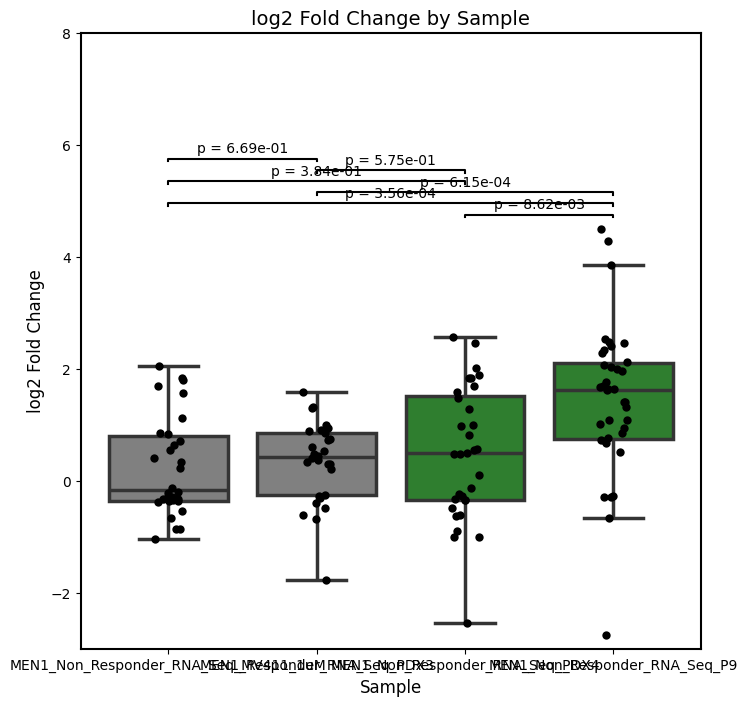

In [56]:
# Load and clean the CSV files
def load_and_clean_csv(file_path):
    df = pd.read_csv(file_path, index_col=0)
    df = df.dropna(subset=['log2FC', 'padj'])  # Remove rows where 'log2FC' or 'padj' is NaN
    df = df[df['padj'] < 0.05]  # Keep only rows where 'padj' is less than 0.05
    return df

MEN1_Non_Responder_RNA_Seq_P9 = load_and_clean_csv('MEN1_Non_Responder_RNA_Seq_P9.csv')
MEN1_Non_Responder_RNA_Seq_PDX4 = load_and_clean_csv('MEN1_Non_Responder_RNA_Seq_PDX4.csv')
MEN1_Non_Responder_RNA_Seq_MV411_1uM = load_and_clean_csv('MV411_1uM_SNDX5613.csv')
MEN1_Responder_RNA_Seq_PDX3 = load_and_clean_csv('PDX3_VTP50469.csv')

# Filter and label the datasets
def filter_and_label(df, sample):
    filtered_df = df.copy()
    filtered_df['sample'] = sample
    return filtered_df

NonCanonical_AML_df_P9 = filter_and_label(MEN1_Non_Responder_RNA_Seq_P9[MEN1_Non_Responder_RNA_Seq_P9['Gene'].isin(NonCanonical_AML_OPTGs)], 'MEN1_Non_Responder_RNA_Seq_P9')
NonCanonical_AML_df_PDX4 = filter_and_label(MEN1_Non_Responder_RNA_Seq_PDX4[MEN1_Non_Responder_RNA_Seq_PDX4['Gene'].isin(NonCanonical_AML_OPTGs)], 'MEN1_Non_Responder_RNA_Seq_PDX4')
NonCanonical_AML_df_MV411 = filter_and_label(MEN1_Non_Responder_RNA_Seq_MV411_1uM[MEN1_Non_Responder_RNA_Seq_MV411_1uM['Gene'].isin(NonCanonical_AML_OPTGs)], 'MEN1_Non_Responder_RNA_Seq_MV411_1uM')
NonCanonical_AML_df_PDX3 = filter_and_label(MEN1_Responder_RNA_Seq_PDX3[MEN1_Responder_RNA_Seq_PDX3['Gene'].isin(NonCanonical_AML_OPTGs)], 'MEN1_Responder_RNA_Seq_PDX3')

# Concatenate the dataframes and reset index
combined_df = pd.concat([NonCanonical_AML_df_P9, NonCanonical_AML_df_PDX4,
                         NonCanonical_AML_df_MV411, NonCanonical_AML_df_PDX3]).reset_index(drop=True)

# Ensure 'log2FC' column exists and contains data
if 'log2FC' not in combined_df.columns or combined_df['log2FC'].isnull().all():
    raise ValueError("'log2FC' column is missing or contains all null values.")

# Define sample order for the x-axis
sample_order = ['MEN1_Non_Responder_RNA_Seq_MV411_1uM', 'MEN1_Responder_RNA_Seq_PDX3',
                'MEN1_Non_Responder_RNA_Seq_PDX4', 'MEN1_Non_Responder_RNA_Seq_P9']

# Define box pairs for t-tests
box_pairs = [
    ('MEN1_Non_Responder_RNA_Seq_P9', 'MEN1_Non_Responder_RNA_Seq_PDX4'),
    ('MEN1_Non_Responder_RNA_Seq_P9', 'MEN1_Non_Responder_RNA_Seq_MV411_1uM'),
    ('MEN1_Non_Responder_RNA_Seq_P9', 'MEN1_Responder_RNA_Seq_PDX3'),
    ('MEN1_Non_Responder_RNA_Seq_PDX4', 'MEN1_Non_Responder_RNA_Seq_MV411_1uM'),
    ('MEN1_Non_Responder_RNA_Seq_PDX4', 'MEN1_Responder_RNA_Seq_PDX3'),
    ('MEN1_Non_Responder_RNA_Seq_MV411_1uM', 'MEN1_Responder_RNA_Seq_PDX3')
]

# Perform t-tests and calculate p-values
p_values = []
for pair in box_pairs:
    group1 = combined_df[combined_df['sample'] == pair[0]]['log2FC']
    group2 = combined_df[combined_df['sample'] == pair[1]]['log2FC']
    if not group1.empty and not group2.empty:
        stat, p_value = ttest_ind(group1, group2, equal_var=False)
        p_values.append(p_value)
        print(f"T-test between {pair[0]} and {pair[1]}: p-value = {p_value:.10f}")
    else:
        p_values.append(1)  # Append a high p-value if no data

# Define colors for each sample
colors = ['grey', 'grey', 'forestgreen', 'forestgreen']
color_palette = dict(zip(sample_order, colors))

# Plot
plt.figure(figsize=(8, 8))
ax = sns.boxplot(x='sample', y='log2FC', data=combined_df, order=sample_order, palette=color_palette,
                 showfliers=False, linewidth=2.5)
sns.stripplot(x='sample', y='log2FC', data=combined_df, color='black', jitter=True, dodge=True, order=sample_order, size=6)

# Adjust y-axis range
ax.set_ylim(-3, 8)

# Increase the linewidth of the plot borders
for _, spine in ax.spines.items():
    spine.set_linewidth(1.5)

# Manually add p-values above boxes
y_max = combined_df['log2FC'].max()
for i, (pair, p_val) in enumerate(zip(box_pairs, p_values)):
    x1 = sample_order.index(pair[0])
    x2 = sample_order.index(pair[1])
    y = y_max + 0.2 * (i + 1)
    ax.plot([x1, x1, x2, x2], [y, y + 0.05, y + 0.05, y], lw=1.5, color='black')
    ax.text((x1 + x2) * 0.5, y + 0.1, f"p = {p_val:.2e}", ha='center', va='bottom', color='black')

# Set title and labels
ax.set_xlabel('Sample', fontsize=12)
ax.set_ylabel('log2 Fold Change', fontsize=12)
ax.set_title('log2 Fold Change by Sample', fontsize=14)

# Save the plot if needed
# plt.savefig('Figure_Panels/Fig_6J.png, dpi=300, bbox_inches='tight')

plt.show()
